<a href="https://colab.research.google.com/github/Filipe-Miguel/CAS/blob/main/Final/CAS_FINAL_Laura_Filipe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CAS Applied Data Science - Final Project**

Filipe Maximiano Sousa & Laura Cunha Silva

Convolutional Neural Networks application to a Pig farms biossecurity classification

**Notes about this project**

1.   Description of the organization of pig farms in switzerland
2.   Describe biossecurity
3.   Describe biossecurity measurements
4.   Importance of good biossecurity

Wert values meaning:


*   0 = positive  
*   1 = negative
*   2 = critical problem

*Only keep biossecurity kriterium*

Kriterium classifications:


*   1. Biossecurity measures
*   2. Animal welfare and symptoms
*   3. Veterinary treatment and drug usage


After biossecurity classification is done explore:

*   Is there a correlation between the presence of clinical signs and the biossecurity classification attributed to each farm?
*   Is the tierkategories of the farms related to a specific biossecurity classification?








Import libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

Mount drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


Upload data

In [ ]:
import pandas as pd
df=pd.read_csv('/content/drive/MyDrive/CAS FINAL /Zuch.csv', encoding = "ISO-8859-1")
#df=pd.read_csv("/content/drive/MyDrive/CAS FINAL/Zuch.csv", encoding = "ISO-8859-1")

# Nova secção

Data cleaning 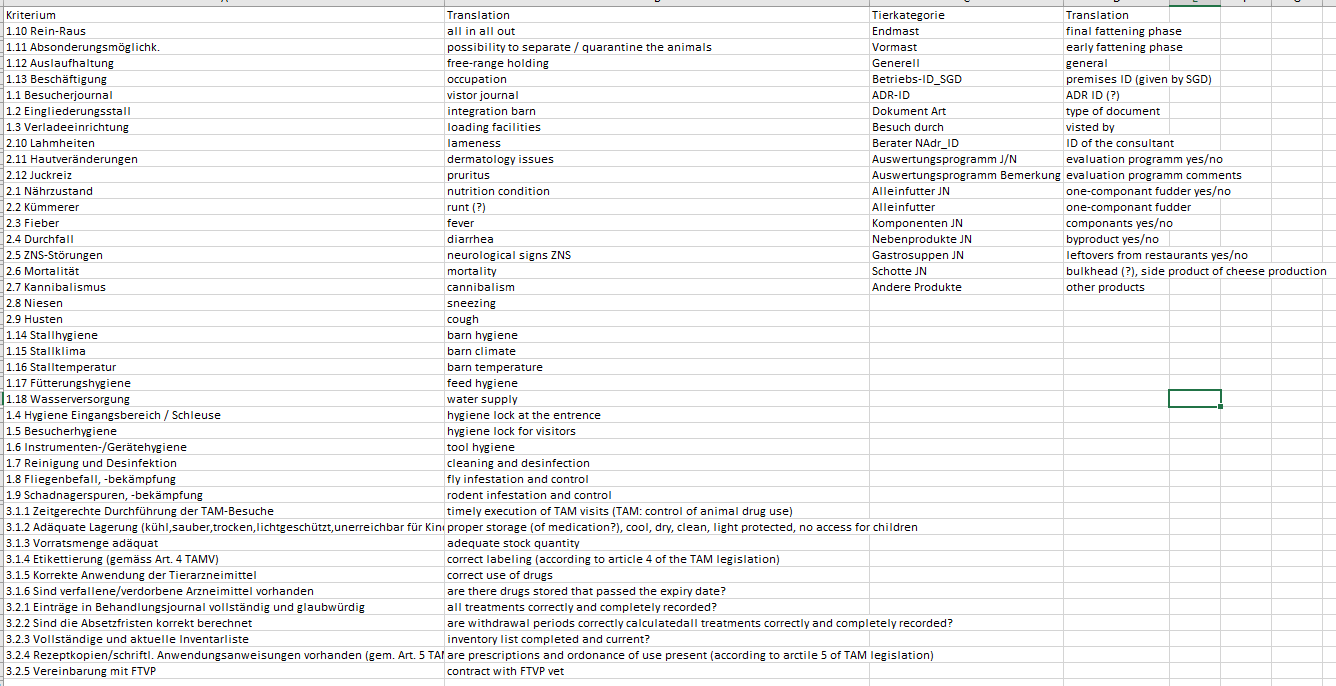

In [ ]:
#df structure
print(df.columns)

df.head()

Index(['Betriebs-ID_SGD', 'ADR-ID', 'DokID', 'Dokument Art', 'Besuchsdatum',
       'Besuch durch', 'Berater NAdr_ID', 'Auswertungsprogramm J/N',
       'Auswertungsprogramm Bemerkung', 'Alleinfutter JN', 'Alleinfutter',
       'Komponenten JN', 'Nebenprodukte JN', 'Gastrosuppen JN', 'Schotte JN',
       'Andere Produkte', 'Kriterium', 'Tierkategorie', 'Wert', 'Bemerkung',
       'ID', 'vet', 'ID_independent'],
      dtype='object')


Betriebs-ID_SGD  ADR-ID   DokID Dokument Art Besuchsdatum Besuch durch  \
0                9   19708  269317        Zucht   2012-02-14          SGD   
1                9   19708  269317        Zucht   2012-02-14          SGD   
2                9   19708  269317        Zucht   2012-02-14          SGD   
3                9   19708  269317        Zucht   2012-02-14          SGD   
4                9   19708  269317        Zucht   2012-02-14          SGD   

   Berater NAdr_ID  Auswertungsprogramm J/N Auswertungsprogramm Bemerkung  \
0          42455.0                      0.0                           NaN   
1          42455.0                      NaN                           NaN   
2          42455.0                      NaN                           NaN   
3          42455.0                      NaN                           NaN   
4          42455.0                      NaN                           NaN   

  Alleinfutter JN  ... Gastrosuppen JN Schotte JN Andere Produkte  \
0              ja  ...            nein       nein             NaN   
1              ja  ...            nein       nein             NaN   
2              ja  ...            nein       nein             NaN   
3              ja  ...            nein       nein             NaN   
4              ja  ...            nein       nein             NaN   

                            Kriterium Tierkategorie Wert      Bemerkung    ID  \
0                 1.3 Datenauswertung      Generell    0            NaN  1113   
1     1.10 Fliegenbefall, -bekämpfung      Generell    0  Fliegenschnur  1113   
2  1.11 Schadnagerspuren, -bekämpfung      Generell    0         Katzen  1113   
3                      1.12 Rein-Raus   Absetzjager    0            NaN  1113   
4                      1.12 Rein-Raus      Remonten    0            NaN  1113   

   vet ID_independent  
0  321           8828  
1  321           8828  
2  321           8828  
3  321           8828  
4  321           8828  

[5 rows x 23 columns]

The column names in Kriterium of df are different from the ones in the excel data. For example, the 1.10 is Rein-Haus and here is Fliegenbefall. Maybe it is because Zucht has different criteria, but we need to check that

In [ ]:
unique_values_df = df["Kriterium"].unique()
print(unique_values_df)

['1.3 Datenauswertung' '1.10 Fliegenbefall, -bekämpfung'
 '1.11 Schadnagerspuren, -bekämpfung' '1.12 Rein-Raus'
 '1.13 Absonderungsmöglichk.' '1.14 Auslaufhaltung' '1.15 Beschäftigung'
 '1.16 Stallhygiene' '1.17 Stallklima' '1.18 Stalltemperatur'
 '1.19 Fütterungshygiene' '1.1 Besucherjournal' '1.20 Wasserversorgung'
 '1.2 Eingliederungsstall' '1.4 Verladeeinrichtung'
 '1.5 Hygiene Eingangsbereich / Schleuse' '1.6 Besucherhygiene'
 '1.7 Instrumenten-/Gerätehygiene' '1.9 Reinigung und Desinfektion'
 '2.10 Niesen' '2.11 Husten' '2.12 Lahmheiten' '2.13 Hautveränderungen'
 '2.14 Juckreiz' '2.1 Nährzustand' '2.2 Kümmerer' '2.3 Fruchtbarkeit'
 '2.4 Milchfieber' '2.5 Fieber' '2.6 Durchfall' '2.7 ZNS-Störungen'
 '2.8 Mortalität' '2.9 Kannibalismus' '1.8 Eingriffe - Kastration'
 '3.1.1 Zeitgerechte Durchführung der TAM-Besuche'
 '3.1.2 Adäquate Lagerung (kühl,sauber,trocken,lichtgeschützt,unerreichbar für Kinder)'
 '3.1.3 Vorratsmenge adäquat' '3.1.4 Etikettierung (gemäss Art. 4 TAMV)'
 '3.1.5 

**Goal of this project:**
- Determine the biossecurity levels of the farms based on their in-farm performace

**Descriptive data analysis:**
- number of unique farms (TVD)
- number of unique vet ids (Berater NAdr_ID)
- Number of visits per month & vet ID (Besuchsdatum & Berater NAdr_ID)
- Number of 1/0 per criterium classification (kriterium)  

In [ ]:
#Number of unique farms
n = len(pd.unique(df["ID_independent"]))

print("Number of farms :",
      n)

n = len(pd.unique(df["ID"]))

print("No.of.unique values :",
      n)
#Number of evaluators = vet IDs
n1 = len(pd.unique(df['vet']))

print("Number of vets :",
      n1)

#Number of visits total
n2 = len(pd.unique(df['Besuchsdatum']))

print("Number of visits :",
      n2)

#Number of visits total
# Convert 'Date' column to datetime
df['Besuchsdatum'] = pd.to_datetime(df['Besuchsdatum'])
distinct_years_count = df['Besuchsdatum'].dt.year.nunique()
print("Number of distinct years:", distinct_years_count)


Number of farms : 20650
No.of.unique values : 2441
Number of vets : 251
Number of visits : 2248
Number of distinct years: 8


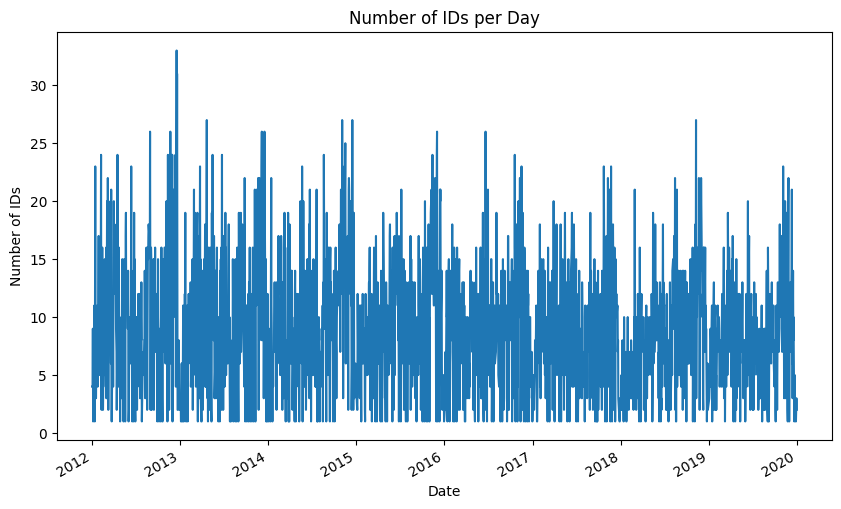

       ID_independent  DistinctDateCount
0                   1                  1
1                   2                  1
2                   3                  1
3                   4                  1
4                   5                  1
...               ...                ...
20645           34312                  1
20646           34315                  1
20647           34317                  1
20648           34321                  1
20649           34323                  1

[20650 rows x 2 columns]


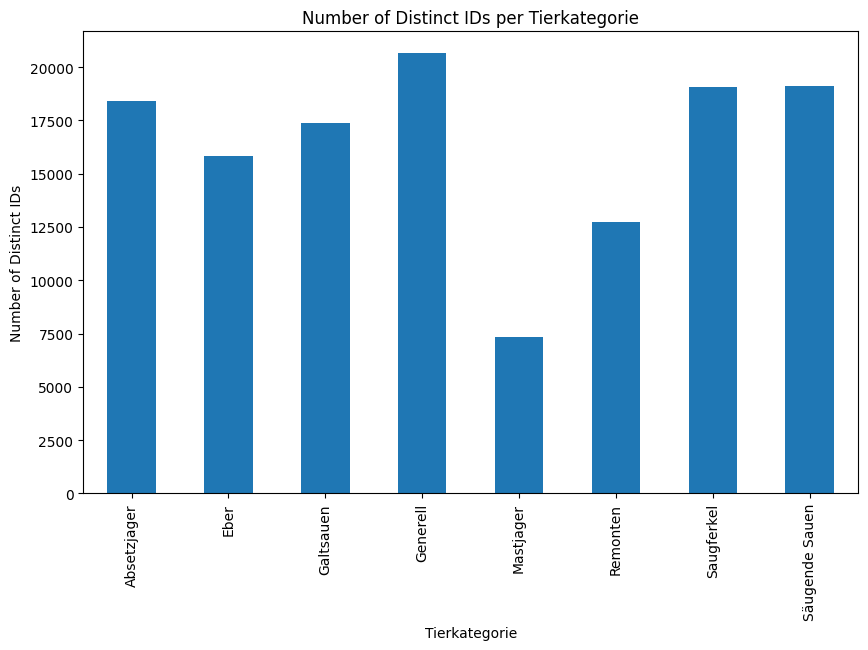

In [ ]:
#Number of visits per farm
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'Date' column to datetime
df['Besuchsdatum'] = pd.to_datetime(df['Besuchsdatum'])

# Group data by ID and Date and count the number of occurrences
grouped_data = df.groupby(['ID_independent', 'Besuchsdatum']).size().reset_index(name='Count')

# Plot number of IDs per day
plt.figure(figsize=(10, 6))
grouped_data.groupby('Besuchsdatum')['ID_independent'].count().plot(kind='line')
plt.xlabel('Date')
plt.ylabel('Number of IDs')
plt.title('Number of IDs per Day')
plt.show()

#create table with number of visits to each farm over the years 2012-2020
# Group data by 'ID' and count the number of distinct dates
distinct_dates = df.groupby('ID_independent')['Besuchsdatum'].nunique().reset_index()

# Rename the count column
distinct_dates = distinct_dates.rename(columns={'Besuchsdatum': 'DistinctDateCount'})

# Display the resulting table
print(distinct_dates)

#Distribution of the farm categories
# Group data by 'Tierkategorie' and count number of distinct IDs
grouped_data = df.groupby('Tierkategorie')['ID_independent'].nunique()

# Plot the number of distinct IDs based on 'Tierkategorie'
plt.figure(figsize=(10, 6))
grouped_data.plot(kind='bar')
plt.xlabel('Tierkategorie')
plt.ylabel('Number of Distinct IDs')
plt.title('Number of Distinct IDs per Tierkategorie')
plt.show()

In [ ]:
!pip install pivottablejs
from pivottablejs import pivot_ui

In [ ]:
pivot_ui(df)

In [ ]:
df

Betriebs-ID_SGD  ADR-ID   DokID Dokument Art Besuchsdatum  \
0                      9   19708  269317        Zucht   2012-02-14   
1                      9   19708  269317        Zucht   2012-02-14   
2                      9   19708  269317        Zucht   2012-02-14   
3                      9   19708  269317        Zucht   2012-02-14   
4                      9   19708  269317        Zucht   2012-02-14   
...                  ...     ...     ...          ...          ...   
2482425               16   15396  548133        Zucht   2019-08-06   
2482426               16   15396  548133        Zucht   2019-08-06   
2482427               16   15396  548133        Zucht   2019-08-06   
2482428               16   15396  548133        Zucht   2019-08-06   
2482429               16   15396  548133        Zucht   2019-08-06   

        Besuch durch  Berater NAdr_ID  Auswertungsprogramm J/N  \
0                SGD          42455.0                      0.0   
1                SGD          42455.0                      NaN   
2                SGD          42455.0                      NaN   
3                SGD          42455.0                      NaN   
4                SGD          42455.0                      NaN   
...              ...              ...                      ...   
2482425          BTA          57747.0                      NaN   
2482426          BTA          57747.0                      NaN   
2482427          BTA          57747.0                      NaN   
2482428          BTA          57747.0                      NaN   
2482429          BTA          57747.0                      NaN   

        Auswertungsprogramm Bemerkung Alleinfutter JN  ... Gastrosuppen JN  \
0                                 NaN              ja  ...            nein   
1                                 NaN              ja  ...            nein   
2                                 NaN              ja  ...            nein   
3                                 NaN              ja  ...            nein   
4                                 NaN              ja  ...            nein   
...                               ...             ...  ...             ...   
2482425                           NaN              ja  ...            nein   
2482426                           NaN              ja  ...            nein   
2482427                           NaN              ja  ...            nein   
2482428                           NaN              ja  ...            nein   
2482429                           NaN              ja  ...            nein   

        Schotte JN Andere Produkte  \
0             nein             NaN   
1             nein             NaN   
2             nein             NaN   
3             nein             NaN   
4             nein             NaN   
...            ...             ...   
2482425       nein             NaN   
2482426       nein             NaN   
2482427       nein             NaN   
2482428       nein             NaN   
2482429       nein             NaN   

                                                 Kriterium Tierkategorie Wert  \
0                                      1.3 Datenauswertung      Generell    0   
1                          1.10 Fliegenbefall, -bekämpfung      Generell    0   
2                       1.11 Schadnagerspuren, -bekämpfung      Generell    0   
3                                           1.12 Rein-Raus   Absetzjager    0   
4                                           1.12 Rein-Raus      Remonten    0   
...                                                    ...           ...  ...   
2482425  3.2.1 Einträge in Behandlungsjournal vollständ...      Generell    1   
2482426     3.2.2 Sind die Absetzfristen korrekt berechnet      Generell    1   
2482427      3.2.3 Vollständige und aktuelle Inventarliste      Generell    1   
2482428  3.2.4 Rezeptkopien/schriftl. Anwendungsanweisu...      Generell    0   
2482429                        3.2.5 Vereinbarung mit FTVP      Generell    0   

        

In [ ]:
print(df.columns)

Index(['Betriebs-ID_SGD', 'ADR-ID', 'DokID', 'Dokument Art', 'Besuchsdatum',
       'Besuch durch', 'Berater NAdr_ID', 'Auswertungsprogramm J/N',
       'Auswertungsprogramm Bemerkung', 'Alleinfutter JN', 'Alleinfutter',
       'Komponenten JN', 'Nebenprodukte JN', 'Gastrosuppen JN', 'Schotte JN',
       'Andere Produkte', 'Kriterium', 'Tierkategorie', 'Wert', 'Bemerkung',
       'ID', 'vet', 'ID_independent'],
      dtype='object')


In [ ]:
#Remove unnecessary variables
columns_to_remove = ['Betriebs-ID_SGD', 'ADR-ID', 'DokID', 'Dokument Art',
       'Besuch durch', 'Berater NAdr_ID',
       'Auswertungsprogramm Bemerkung', 'Alleinfutter JN', 'Alleinfutter',
       'Komponenten JN', 'Nebenprodukte JN', 'Gastrosuppen JN', 'Schotte JN',
       'Andere Produkte', 'Bemerkung']
df = df.drop(columns=columns_to_remove)
df.head()

Besuchsdatum  Auswertungsprogramm J/N                           Kriterium  \
0   2012-02-14                      0.0                 1.3 Datenauswertung   
1   2012-02-14                      NaN     1.10 Fliegenbefall, -bekämpfung   
2   2012-02-14                      NaN  1.11 Schadnagerspuren, -bekämpfung   
3   2012-02-14                      NaN                      1.12 Rein-Raus   
4   2012-02-14                      NaN                      1.12 Rein-Raus   

  Tierkategorie  Wert    ID  vet  ID_independent  
0      Generell     0  1113  321            8828  
1      Generell     0  1113  321            8828  
2      Generell     0  1113  321            8828  
3   Absetzjager     0  1113  321            8828  
4      Remonten     0  1113  321            8828

In [ ]:
df

Besuchsdatum  Auswertungsprogramm J/N  \
0         2012-02-14                      0.0   
1         2012-02-14                      NaN   
2         2012-02-14                      NaN   
3         2012-02-14                      NaN   
4         2012-02-14                      NaN   
...              ...                      ...   
2482425   2019-08-06                      NaN   
2482426   2019-08-06                      NaN   
2482427   2019-08-06                      NaN   
2482428   2019-08-06                      NaN   
2482429   2019-08-06                      NaN   

                                                 Kriterium Tierkategorie  \
0                                      1.3 Datenauswertung      Generell   
1                          1.10 Fliegenbefall, -bekämpfung      Generell   
2                       1.11 Schadnagerspuren, -bekämpfung      Generell   
3                                           1.12 Rein-Raus   Absetzjager   
4                                           1.12 Rein-Raus      Remonten   
...                                                    ...           ...   
2482425  3.2.1 Einträge in Behandlungsjournal vollständ...      Generell   
2482426     3.2.2 Sind die Absetzfristen korrekt berechnet      Generell   
2482427      3.2.3 Vollständige und aktuelle Inventarliste      Generell   
2482428  3.2.4 Rezeptkopien/schriftl. Anwendungsanweisu...      Generell   
2482429                        3.2.5 Vereinbarung mit FTVP      Generell   

         Wert    ID  vet  ID_independent  
0           0  1113  321            8828  
1           0  1113  321            8828  
2           0  1113  321            8828  
3           0  1113  321            8828  
4           0  1113  321            8828  
...       ...   ...  ...             ...  
2482425     1   286   33            2159  
2482426     1   286   33            2159  
2482427     1   286   33            2159  
2482428     0   286   33            2159  
2482429     0   286   33            2159  

[2482430 rows x 8 columns]

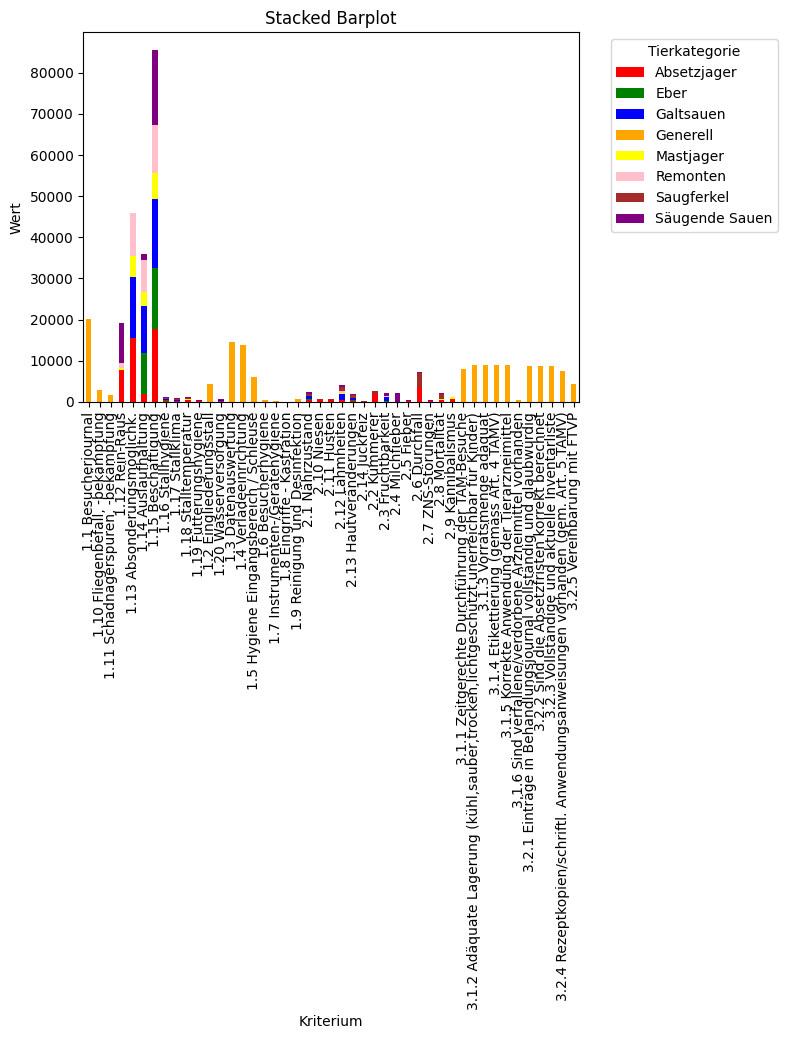

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a pivot table to reshape the data for the stacked barplot
pivot_table = df.pivot_table(index='Kriterium', columns='Tierkategorie', values='Wert', aggfunc='sum')

# Plot the stacked barplot
pivot_table.plot(kind='bar', stacked=True, color=['red', 'green', 'blue','orange','yellow','pink','brown','purple'])

# Add labels and title
plt.xlabel('Kriterium')
plt.ylabel('Wert')
plt.title('Stacked Barplot')

# Show the plot
plt.legend(title='Tierkategorie', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Count the number of observations per unique value in the 'Tierkategorie' column
observations_per_name = df['Tierkategorie'].value_counts()
print("Number of farms per Tierkategorie:")
print(observations_per_name)

Number of farms per Tierkategorie:
Tierkategorie
Absetzjager       386664
Säugende Sauen    381542
Galtsauen         347917
Generell          325146
Saugferkel        323848
Eber              284358
Remonten          279401
Mastjager         153554
Name: count, dtype: int64


In [ ]:
#Do all farms have the same tierkategories?
# Group by 'ID' and count the number of unique 'tierkategories' in each group
tierkategories_count = df.groupby('Tierkategorie')['ID_independent'].nunique()

print("Number of unique IDs per Tierkategorie:")
print(tierkategories_count)

Number of unique IDs per Tierkategorie:
Tierkategorie
Absetzjager       18433
Eber              15819
Galtsauen         17395
Generell          20650
Mastjager          7333
Remonten          12717
Saugferkel        19070
Säugende Sauen    19139
Name: ID_independent, dtype: int64


In [ ]:
#keep only observations that relate to kriterium 1
df_bs = df[df['Kriterium'].str.startswith('1')]

df_bs

Besuchsdatum  Auswertungsprogramm J/N  \
0         2012-02-14                      0.0   
1         2012-02-14                      NaN   
2         2012-02-14                      NaN   
3         2012-02-14                      NaN   
4         2012-02-14                      NaN   
...              ...                      ...   
2482330   2019-08-06                      NaN   
2482331   2019-08-06                      NaN   
2482332   2019-08-06                      NaN   
2482333   2019-08-06                      NaN   
2482334   2019-08-06                      NaN   

                                      Kriterium Tierkategorie  Wert    ID  \
0                           1.3 Datenauswertung      Generell     0  1113   
1               1.10 Fliegenbefall, -bekämpfung      Generell     0  1113   
2            1.11 Schadnagerspuren, -bekämpfung      Generell     0  1113   
3                                1.12 Rein-Raus   Absetzjager     0  1113   
4                                1.12 Rein-Raus      Remonten     0  1113   
...                                         ...           ...   ...   ...   
2482330  1.5 Hygiene Eingangsbereich / Schleuse      Generell     0   286   
2482331                     1.6 Besucherhygiene      Generell     0   286   
2482332         1.7 Instrumenten-/Gerätehygiene      Generell     0   286   
2482333              1.8 Eingriffe - Kastration      Generell     0   286   
2482334          1.9 Reinigung und Desinfektion      Generell     0   286   

         vet  ID_independent  
0        321            8828  
1        321            8828  
2        321            8828  
3        321            8828  
4        321            8828  
...      ...             ...  
2482330   33            2159  
2482331   33            2159  
2482332   33            2159  
2482333   33            2159  
2482334   33            2159  

[1069146 rows x 8 columns]

In [ ]:
#save the pivot
file_path = '/content/drive/MyDrive/CAS FINAL /check_transformation_nan.xlsx'

# Use the to_csv() method to save the DataFrame to a CSV file
df_bs.to_csv(file_path,index=False)

In [ ]:
#check it worked
unique_values= df_bs["Kriterium"].unique()

print(unique_values)

['1.3 Datenauswertung' '1.10 Fliegenbefall, -bekämpfung'
 '1.11 Schadnagerspuren, -bekämpfung' '1.12 Rein-Raus'
 '1.13 Absonderungsmöglichk.' '1.14 Auslaufhaltung' '1.15 Beschäftigung'
 '1.16 Stallhygiene' '1.17 Stallklima' '1.18 Stalltemperatur'
 '1.19 Fütterungshygiene' '1.1 Besucherjournal' '1.20 Wasserversorgung'
 '1.2 Eingliederungsstall' '1.4 Verladeeinrichtung'
 '1.5 Hygiene Eingangsbereich / Schleuse' '1.6 Besucherhygiene'
 '1.7 Instrumenten-/Gerätehygiene' '1.9 Reinigung und Desinfektion'
 '1.8 Eingriffe - Kastration']


In [ ]:
#pivot_table = df_bs.pivot_table(index='Kriterium', columns='Tierkategorie', values='Wert', aggfunc='sum')
#pivot_table

Check the number of classifications we have for each type of farm

In [ ]:
#Choose just the relevant columns
df_alt = df_bs[['Kriterium', 'Tierkategorie', 'Wert']]
df_alt

Kriterium Tierkategorie  Wert
0                           1.3 Datenauswertung      Generell     0
1               1.10 Fliegenbefall, -bekämpfung      Generell     0
2            1.11 Schadnagerspuren, -bekämpfung      Generell     0
3                                1.12 Rein-Raus   Absetzjager     0
4                                1.12 Rein-Raus      Remonten     0
...                                         ...           ...   ...
2482330  1.5 Hygiene Eingangsbereich / Schleuse      Generell     0
2482331                     1.6 Besucherhygiene      Generell     0
2482332         1.7 Instrumenten-/Gerätehygiene      Generell     0
2482333              1.8 Eingriffe - Kastration      Generell     0
2482334          1.9 Reinigung und Desinfektion      Generell     0

[1069146 rows x 3 columns]

In [ ]:
#Choose just the relevant columns
df_alt = df_bs[['Kriterium', 'Tierkategorie', 'Wert']]

#transform in numeric
df_alt['Wert'] = pd.to_numeric(df_alt['Wert'], errors='coerce')

print(df_alt['Wert'].dtype)

int64


In [ ]:
# Get unique values from the column
unique_values = df_alt['Wert'].unique()

# Print unique values
print(unique_values)

[0 1 2]


In [ ]:
df_alt

Kriterium Tierkategorie  Wert
0                           1.3 Datenauswertung      Generell     0
1               1.10 Fliegenbefall, -bekämpfung      Generell     0
2            1.11 Schadnagerspuren, -bekämpfung      Generell     0
3                                1.12 Rein-Raus   Absetzjager     0
4                                1.12 Rein-Raus      Remonten     0
...                                         ...           ...   ...
2482330  1.5 Hygiene Eingangsbereich / Schleuse      Generell     0
2482331                     1.6 Besucherhygiene      Generell     0
2482332         1.7 Instrumenten-/Gerätehygiene      Generell     0
2482333              1.8 Eingriffe - Kastration      Generell     0
2482334          1.9 Reinigung und Desinfektion      Generell     0

[1069146 rows x 3 columns]

In [ ]:
#we will change all the numeric values to 1 to count them and plot a stacked barplot
df_alt= df_alt

def replace_values(x):
    if x in [0, 1, 2]:
        return 1
    else:
        return x

df_alt = df_alt.applymap(replace_values)
df_alt

Kriterium Tierkategorie  Wert
0                           1.3 Datenauswertung      Generell     1
1               1.10 Fliegenbefall, -bekämpfung      Generell     1
2            1.11 Schadnagerspuren, -bekämpfung      Generell     1
3                                1.12 Rein-Raus   Absetzjager     1
4                                1.12 Rein-Raus      Remonten     1
...                                         ...           ...   ...
2482330  1.5 Hygiene Eingangsbereich / Schleuse      Generell     1
2482331                     1.6 Besucherhygiene      Generell     1
2482332         1.7 Instrumenten-/Gerätehygiene      Generell     1
2482333              1.8 Eingriffe - Kastration      Generell     1
2482334          1.9 Reinigung und Desinfektion      Generell     1

[1069146 rows x 3 columns]

In [ ]:
#now for the NaN - change all the Nan to 0
def replace_values(x):
 if pd.isnull(x):
        return 0
 else:
        return x

df_alt = df_alt.applymap(replace_values)


In [ ]:
#check it worked
unique_values =df_alt['Wert'].unique()
print(unique_values)

[1]


In [ ]:
#the same plot as up, but just with the selected criteria
# Create a pivot table to reshape the data for the stacked barplot
pivot_table = df_alt.pivot_table(index='Kriterium', columns='Tierkategorie', values='Wert', aggfunc='sum')
pivot_table

Tierkategorie                           Absetzjager     Eber  Galtsauen  \
Kriterium                                                                 
1.1 Besucherjournal                             NaN      NaN        NaN   
1.10 Fliegenbefall, -bekämpfung                 NaN      NaN        NaN   
1.11 Schadnagerspuren, -bekämpfung              NaN      NaN        NaN   
1.12 Rein-Raus                              18501.0      NaN        NaN   
1.13 Absonderungsmöglichk.                  18497.0      NaN    17478.0   
1.14 Auslaufhaltung                         18505.0  15883.0    17482.0   
1.15 Beschäftigung                          18513.0  15896.0    17491.0   
1.16 Stallhygiene                           18385.0  15790.0    17381.0   
1.17 Stallklima                             18387.0  15787.0    17380.0   
1.18 Stalltemperatur                        18390.0  15788.0    17389.0   
1.19 Fütterungshygiene                      18373.0  15774.0    17370.0   
1.2 Eingliederungsstall                         NaN      NaN        NaN   
1.20 Wasserversorgung                       18391.0  15786.0    17374.0   
1.3 Datenauswertung                             NaN      NaN        NaN   
1.4 Verladeeinrichtung                          NaN      NaN        NaN   
1.5 Hygiene Eingangsbereich / Schleuse          NaN      NaN        NaN   
1.6 Besucherhygiene                             NaN      NaN        NaN   
1.7 Instrumenten-/Gerätehygiene                 NaN      NaN        NaN   
1.8 Eingriffe - Kastration                      NaN      NaN        NaN   
1.9 Reinigung und Desinfektion                  NaN      NaN        NaN   

Tierkategorie                           Generell  Mastjager  Remonten  \
Kriterium                                                               
1.1 Besucherjournal                      20833.0        NaN       NaN   
1.10 Fliegenbefall, -bekämpfung          20639.0        NaN       NaN   
1.11 Schadnagerspuren, -bekämpfung       20618.0        NaN       NaN   
1.12 Rein-Raus                               NaN     7349.0   12755.0   
1.13 Absonderungsmöglichk.                   NaN     7349.0   12755.0   
1.14 Auslaufhaltung                          NaN     7349.0   12757.0   
1.15 Beschäftigung                           NaN     7349.0   12762.0   
1.16 Stallhygiene                            NaN     7304.0   12688.0   
1.17 Stallklima                              NaN     7303.0   12687.0   
1.18 Stalltemperatur                         NaN     7302.0   12681.0   
1.19 Fütterungshygiene                       NaN     7300.0   12678.0   
1.2 Eingliederungsstall                  20830.0        NaN       NaN   
1.20 Wasserversorgung                        NaN     7304.0   12682.0   
1.3 Datenauswertung                      20830.0        NaN       NaN   
1.4 Verladeeinrichtung                   20848.0        NaN       NaN   
1.5 Hygiene Eingangsbereich / Schleuse   20639.0        NaN       NaN   
1.6 Besucherhygiene                      20660.0        NaN       NaN   
1.7 Instrumenten-/Gerätehygiene          18307.0        NaN       NaN   
1.8 Eingriffe - Kastration               19891.0        NaN       NaN   
1.9 Reinigung und Desinfektion           20610.0        NaN       NaN   

Tierkategorie                           Saugferkel  Säugende Sauen  
Kriterium                                                           
1.1 Besucherjournal                            NaN             NaN  
1.10 Fliegenbefall, -bekämpfung                NaN             NaN  
1.11 Schadnagerspuren, -bekämpfung             NaN             NaN  
1.12 Rein-Raus                                 NaN         19175.0  
1.13 Absonderungsmöglichk.                     NaN             NaN  
1.14 Auslaufhaltung                            NaN         19179.0  
1.15 Beschäftigung                             NaN         19194.0  
1.16 Stallhygiene                          19054.0         19061.0  
1.17 Stallklima                            19052.0  

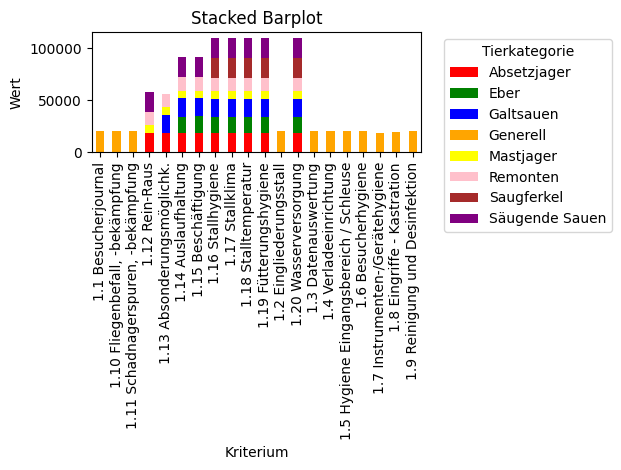

In [ ]:
# Plot the stacked barplot
pivot_table.plot(kind='bar', stacked=True, color=['red', 'green', 'blue','orange','yellow','pink','brown','purple'])

# Add labels and title
plt.xlabel('Kriterium')
plt.ylabel('Wert')
plt.title('Stacked Barplot')

# Show the plot
plt.legend(title='Tierkategorie', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Get column names
column_names = pivot_table.columns

# Print column names
print(column_names)

Index(['Absetzjager', 'Eber', 'Galtsauen', 'Generell', 'Mastjager', 'Remonten',
       'Saugferkel', 'Säugende Sauen'],
      dtype='object', name='Tierkategorie')


In [ ]:
#Is Auswertungsprogramm J/N related to the wert farm classification?
count_per_wert = df.groupby('Wert')['Auswertungsprogramm J/N'].value_counts(dropna=False)

print("Count of 'auswertungsprogram' values per 'wert' value:")
print(count_per_wert)

Count of 'auswertungsprogram' values per 'wert' value:
Wert  Auswertungsprogramm J/N
0     NaN                        2112856
      0.0                           6364
1     NaN                         346283
      1.0                          14466
2     NaN                           2461
Name: count, dtype: int64


In [ ]:
df_bs

Besuchsdatum  Auswertungsprogramm J/N  \
0         2012-02-14                      0.0   
1         2012-02-14                      NaN   
2         2012-02-14                      NaN   
3         2012-02-14                      NaN   
4         2012-02-14                      NaN   
...              ...                      ...   
2482330   2019-08-06                      NaN   
2482331   2019-08-06                      NaN   
2482332   2019-08-06                      NaN   
2482333   2019-08-06                      NaN   
2482334   2019-08-06                      NaN   

                                      Kriterium Tierkategorie  Wert    ID  \
0                           1.3 Datenauswertung      Generell     0  1113   
1               1.10 Fliegenbefall, -bekämpfung      Generell     0  1113   
2            1.11 Schadnagerspuren, -bekämpfung      Generell     0  1113   
3                                1.12 Rein-Raus   Absetzjager     0  1113   
4                                1.12 Rein-Raus      Remonten     0  1113   
...                                         ...           ...   ...   ...   
2482330  1.5 Hygiene Eingangsbereich / Schleuse      Generell     0   286   
2482331                     1.6 Besucherhygiene      Generell     0   286   
2482332         1.7 Instrumenten-/Gerätehygiene      Generell     0   286   
2482333              1.8 Eingriffe - Kastration      Generell     0   286   
2482334          1.9 Reinigung und Desinfektion      Generell     0   286   

         vet  ID_independent  
0        321            8828  
1        321            8828  
2        321            8828  
3        321            8828  
4        321            8828  
...      ...             ...  
2482330   33            2159  
2482331   33            2159  
2482332   33            2159  
2482333   33            2159  
2482334   33            2159  

[1069146 rows x 8 columns]

In [ ]:
#select just the General

general = df_bs[df_bs['Tierkategorie'] == 'Generell']
general

df_bs=general

# Pivot the table

In [ ]:
# Pivot the DataFrame to transform 'kriterium' unique values into columns and match the values
pivot_df = df_bs.pivot_table(index=['ID_independent', 'Besuchsdatum',"Tierkategorie"], columns='Kriterium', values='Wert', aggfunc='first')

# Reset the index
pivot_df.reset_index(inplace=True)

# Rename the name of the index column
pivot_df = pivot_df.rename_axis(None, axis=1)

pivot_df

ID_independent Besuchsdatum Tierkategorie  1.1 Besucherjournal  \
0                   1   2012-04-02      Generell                  1.0   
1                   2   2013-04-22      Generell                  1.0   
2                   3   2012-04-18      Generell                  1.0   
3                   4   2013-05-06      Generell                  1.0   
4                   5   2014-02-04      Generell                  1.0   
...               ...          ...           ...                  ...   
20645           34312   2018-10-10      Generell                  1.0   
20646           34315   2019-02-13      Generell                  1.0   
20647           34317   2019-03-15      Generell                  0.0   
20648           34321   2019-07-04      Generell                  1.0   
20649           34323   2019-10-02      Generell                  1.0   

       1.10 Fliegenbefall, -bekämpfung  1.11 Schadnagerspuren, -bekämpfung  \
0                                  0.0                                 0.0   
1                                  0.0                                 0.0   
2                                  0.0                                 0.0   
3                                  0.0                                 0.0   
4                                  0.0                                 0.0   
...                                ...                                 ...   
20645                              0.0                                 0.0   
20646                              0.0                                 0.0   
20647                              0.0                                 0.0   
20648                              0.0                                 0.0   
20649                              0.0                                 0.0   

       1.2 Eingliederungsstall  1.3 Datenauswertung  1.4 Verladeeinrichtung  \
0                          0.0                  0.0                     0.0   
1                          0.0                  0.0                     0.0   
2                          0.0                  1.0                     1.0   
3                          1.0                  1.0                     1.0   
4                          1.0                  1.0                     1.0   
...                        ...                  ...                     ...   
20645                      0.0                  0.0                     0.0   
20646                      0.0                  1.0                     1.0   
20647                      0.0                  0.0                     0.0   
20648                      1.0                  1.0                     1.0   
20649                      0.0                  0.0                     0.0   

       1.5 Hygiene Eingangsbereich / Schleuse  1.6 Besucherhygiene  \
0                                         1.0                  0.0   
1                                         1.0                  0.0   
2                                         0.0                  0.0   
3                                         0.0                  0.0   
4                                         0.0                  0.0   
...                                       ...                  ...   
20645                                     1.0                  0.0   
20646                                     0.0                  0.0   
20647                                     NaN                  0.0   
20648                                     0.0                  0.0   
20649                                     1.0                  0.0   

       1.7 Instrumenten-/Gerätehygiene  1.8 Eingriffe - Kastration  \
0                                  0.0                         0.0   
1                                  0.0                         0.0   
2                                  0.0                         0.0   
3                                  0.0                         0.0   
4                                  0.0               

In [ ]:
# Pivot the DataFrame to transform 'kriterium' unique values into columns and match the values
pivot_df = df_bs.pivot_table(index=['ID_independent', 'Besuchsdatum'], columns='Kriterium', values='Wert', aggfunc='first')

# Reset the index
pivot_df.reset_index(inplace=True)

# Rename the name of the index column
pivot_df = pivot_df.rename_axis(None, axis=1)

pivot_df

ID_independent Besuchsdatum  1.1 Besucherjournal  \
0                   1   2012-04-02                  1.0   
1                   2   2013-04-22                  1.0   
2                   3   2012-04-18                  1.0   
3                   4   2013-05-06                  1.0   
4                   5   2014-02-04                  1.0   
...               ...          ...                  ...   
20645           34312   2018-10-10                  1.0   
20646           34315   2019-02-13                  1.0   
20647           34317   2019-03-15                  0.0   
20648           34321   2019-07-04                  1.0   
20649           34323   2019-10-02                  1.0   

       1.10 Fliegenbefall, -bekämpfung  1.11 Schadnagerspuren, -bekämpfung  \
0                                  0.0                                 0.0   
1                                  0.0                                 0.0   
2                                  0.0                                 0.0   
3                                  0.0                                 0.0   
4                                  0.0                                 0.0   
...                                ...                                 ...   
20645                              0.0                                 0.0   
20646                              0.0                                 0.0   
20647                              0.0                                 0.0   
20648                              0.0                                 0.0   
20649                              0.0                                 0.0   

       1.2 Eingliederungsstall  1.3 Datenauswertung  1.4 Verladeeinrichtung  \
0                          0.0                  0.0                     0.0   
1                          0.0                  0.0                     0.0   
2                          0.0                  1.0                     1.0   
3                          1.0                  1.0                     1.0   
4                          1.0                  1.0                     1.0   
...                        ...                  ...                     ...   
20645                      0.0                  0.0                     0.0   
20646                      0.0                  1.0                     1.0   
20647                      0.0                  0.0                     0.0   
20648                      1.0                  1.0                     1.0   
20649                      0.0                  0.0                     0.0   

       1.5 Hygiene Eingangsbereich / Schleuse  1.6 Besucherhygiene  \
0                                         1.0                  0.0   
1                                         1.0                  0.0   
2                                         0.0                  0.0   
3                                         0.0                  0.0   
4                                         0.0                  0.0   
...                                       ...                  ...   
20645                                     1.0                  0.0   
20646                                     0.0                  0.0   
20647                                     NaN                  0.0   
20648                                     0.0                  0.0   
20649                                     1.0                  0.0   

       1.7 Instrumenten-/Gerätehygiene  1.8 Eingriffe - Kastration  \
0                                  0.0                         0.0   
1                                  0.0                         0.0   
2                                  0.0                         0.0   
3                                  0.0                         0.0   
4                                  0.0                         0.0   
...                                ...                         ...   
20645                              NaN                         0.0   
20646      

In [ ]:
#save the pivot
file_path = '/content/drive/MyDrive/CAS FINAL /Pivoted.csv'

#save the DataFrame to a CSV file
pivot_df.to_csv(file_path, index=False)

In [ ]:
#create a column with the year just
pivot_df['Year'] = pd.to_datetime(pivot_df['Besuchsdatum']).dt.year
# Move the 'Year' column to the desired position (after 'Besuchsdatum')
pivot_df = pivot_df[['ID_independent', 'Besuchsdatum', 'Year'] + [col for col in pivot_df.columns if col not in ['ID_independent', 'Besuchsdatum', 'Year']]]
pivot_df

ID_independent Besuchsdatum  Year  1.1 Besucherjournal  \
0                   1   2012-04-02  2012                  1.0   
1                   2   2013-04-22  2013                  1.0   
2                   3   2012-04-18  2012                  1.0   
3                   4   2013-05-06  2013                  1.0   
4                   5   2014-02-04  2014                  1.0   
...               ...          ...   ...                  ...   
20645           34312   2018-10-10  2018                  1.0   
20646           34315   2019-02-13  2019                  1.0   
20647           34317   2019-03-15  2019                  0.0   
20648           34321   2019-07-04  2019                  1.0   
20649           34323   2019-10-02  2019                  1.0   

       1.10 Fliegenbefall, -bekämpfung  1.11 Schadnagerspuren, -bekämpfung  \
0                                  0.0                                 0.0   
1                                  0.0                                 0.0   
2                                  0.0                                 0.0   
3                                  0.0                                 0.0   
4                                  0.0                                 0.0   
...                                ...                                 ...   
20645                              0.0                                 0.0   
20646                              0.0                                 0.0   
20647                              0.0                                 0.0   
20648                              0.0                                 0.0   
20649                              0.0                                 0.0   

       1.2 Eingliederungsstall  1.3 Datenauswertung  1.4 Verladeeinrichtung  \
0                          0.0                  0.0                     0.0   
1                          0.0                  0.0                     0.0   
2                          0.0                  1.0                     1.0   
3                          1.0                  1.0                     1.0   
4                          1.0                  1.0                     1.0   
...                        ...                  ...                     ...   
20645                      0.0                  0.0                     0.0   
20646                      0.0                  1.0                     1.0   
20647                      0.0                  0.0                     0.0   
20648                      1.0                  1.0                     1.0   
20649                      0.0                  0.0                     0.0   

       1.5 Hygiene Eingangsbereich / Schleuse  1.6 Besucherhygiene  \
0                                         1.0                  0.0   
1                                         1.0                  0.0   
2                                         0.0                  0.0   
3                                         0.0                  0.0   
4                                         0.0                  0.0   
...                                       ...                  ...   
20645                                     1.0                  0.0   
20646                                     0.0                  0.0   
20647                                     NaN                  0.0   
20648                                     0.0                  0.0   
20649                                     1.0                  0.0   

       1.7 Instrumenten-/Gerätehygiene  1.8 Eingriffe - Kastration  \
0                                  0.0                         0.0   
1                                  0.0                         0.0   
2                                  0.0                         0.0   
3                                  0.0                         0.0   
4                                  0.0                         0.0   
...                                ...                         ...   
20645    

In [ ]:
#exclude the long date column
exclude_columns = ['Besuchsdatum']

# Create a list of all columns without the excluded columns
columns = [col for col in df_bs.columns if col not in exclude_columns]

check = df_bs.pivot_table(index=['ID_independent'], columns='Kriterium', values='Wert', aggfunc='first')

check

Kriterium       1.1 Besucherjournal  1.10 Fliegenbefall, -bekämpfung  \
ID_independent                                                         
1                               1.0                              0.0   
2                               1.0                              0.0   
3                               1.0                              0.0   
4                               1.0                              0.0   
5                               1.0                              0.0   
...                             ...                              ...   
34312                           1.0                              0.0   
34315                           1.0                              0.0   
34317                           0.0                              0.0   
34321                           1.0                              0.0   
34323                           1.0                              0.0   

Kriterium       1.11 Schadnagerspuren, -bekämpfung  1.2 Eingliederungsstall  \
ID_independent                                                                
1                                              0.0                      0.0   
2                                              0.0                      0.0   
3                                              0.0                      0.0   
4                                              0.0                      1.0   
5                                              0.0                      1.0   
...                                            ...                      ...   
34312                                          0.0                      0.0   
34315                                          0.0                      0.0   
34317                                          0.0                      0.0   
34321                                          0.0                      1.0   
34323                                          0.0                      0.0   

Kriterium       1.3 Datenauswertung  1.4 Verladeeinrichtung  \
ID_independent                                                
1                               0.0                     0.0   
2                               0.0                     0.0   
3                               1.0                     1.0   
4                               1.0                     1.0   
5                               1.0                     1.0   
...                             ...                     ...   
34312                           0.0                     0.0   
34315                           1.0                     1.0   
34317                           0.0                     0.0   
34321                           1.0                     1.0   
34323                           0.0                     0.0   

Kriterium       1.5 Hygiene Eingangsbereich / Schleuse  1.6 Besucherhygiene  \
ID_independent                                                                
1                                                  1.0                  0.0   
2                                                  1.0                  0.0   
3                                                  0.0                  0.0   
4                                                  0.0                  0.0   
5                                                  0.0                  0.0   
...                                                ...                  ...   
34312                                              1.0                  0.0   
34315                                              0.0                  0.0   
34317                                              NaN                  0.0   
34321                                              0.0                  0.0   
34323                                              1.0                  0.0   

Kriterium       1.7 Instrumenten-/Gerätehygiene  1.8 Eingriffe - Kastration  \
ID_independent                                                                
1                            

Some checks:
- First check that the lenght of unique IDs is the same as the number of rows
- Second, check one column's unique values to see if they are just between 0 and 1
- Third, calculate average, mean, 1st quartile and 3rd quartile of all the columns coming from Kriterium in the pivot table and the same values for all the unique values of Kriterium in the table df_bs and compare if the values are the same

In [ ]:
specific_id = 2159

# Use boolean indexing to select rows with the specified 'ID'
selected_rows = df_bs[df_bs['ID_independent'] == specific_id]

# Print the selected rows
selected_rows

Besuchsdatum  Auswertungsprogramm J/N  \
2482269   2019-08-06                      0.0   
2482270   2019-08-06                      NaN   
2482271   2019-08-06                      NaN   
2482320   2019-08-06                      NaN   
2482328   2019-08-06                      NaN   
2482329   2019-08-06                      NaN   
2482330   2019-08-06                      NaN   
2482331   2019-08-06                      NaN   
2482332   2019-08-06                      NaN   
2482333   2019-08-06                      NaN   
2482334   2019-08-06                      NaN   

                                      Kriterium Tierkategorie  Wert   ID  vet  \
2482269                     1.3 Datenauswertung      Generell     0  286   33   
2482270         1.10 Fliegenbefall, -bekämpfung      Generell     0  286   33   
2482271      1.11 Schadnagerspuren, -bekämpfung      Generell     0  286   33   
2482320                     1.1 Besucherjournal      Generell     1  286   33   
2482328                 1.2 Eingliederungsstall      Generell     1  286   33   
2482329                  1.4 Verladeeinrichtung      Generell     1  286   33   
2482330  1.5 Hygiene Eingangsbereich / Schleuse      Generell     0  286   33   
2482331                     1.6 Besucherhygiene      Generell     0  286   33   
2482332         1.7 Instrumenten-/Gerätehygiene      Generell     0  286   33   
2482333              1.8 Eingriffe - Kastration      Generell     0  286   33   
2482334          1.9 Reinigung und Desinfektion      Generell     0  286   33   

         ID_independent  
2482269            2159  
2482270            2159  
2482271            2159  
2482320            2159  
2482328            2159  
2482329            2159  
2482330            2159  
2482331            2159  
2482332            2159  
2482333            2159  
2482334            2159

In [ ]:
# check if there are nan in the dataframe

# Count the number of NaN values in each column
nan_count_per_column = pivot_df.isnull().sum()

# Print the count of NaN values in each column
print(nan_count_per_column)


ID_independent                               0
Besuchsdatum                                 0
Year                                         0
1.1 Besucherjournal                         15
1.10 Fliegenbefall, -bekämpfung            206
1.11 Schadnagerspuren, -bekämpfung         228
1.2 Eingliederungsstall                     18
1.3 Datenauswertung                         15
1.4 Verladeeinrichtung                       0
1.5 Hygiene Eingangsbereich / Schleuse     207
1.6 Besucherhygiene                        184
1.7 Instrumenten-/Gerätehygiene           2492
1.8 Eingriffe - Kastration                 901
1.9 Reinigung und Desinfektion             234
dtype: int64


In [ ]:
#investigate
#identify the rows with nan
filtered_df = pivot_df[pivot_df['1.1 Besucherjournal'].isnull()]
filtered_df

ID_independent Besuchsdatum  Year  1.1 Besucherjournal  \
1931             3023   2018-10-01  2018                  NaN   
3765             6045   2018-10-08  2018                  NaN   
4199             6641   2019-03-15  2019                  NaN   
6910            10650   2019-03-15  2019                  NaN   
6974            10738   2018-10-18  2018                  NaN   
7782            11967   2018-09-24  2018                  NaN   
7790            11983   2018-11-07  2018                  NaN   
7890            12145   2018-08-10  2018                  NaN   
8340            12775   2018-09-05  2018                  NaN   
9265            14122   2018-10-17  2018                  NaN   
9784            15000   2019-02-27  2019                  NaN   
11717           18490   2018-08-10  2018                  NaN   
13959           22159   2018-11-12  2018                  NaN   
14868           23505   2018-07-16  2018                  NaN   
16406           26212   2018-11-30  2018                  NaN   

       1.10 Fliegenbefall, -bekämpfung  1.11 Schadnagerspuren, -bekämpfung  \
1931                               0.0                                 0.0   
3765                               0.0                                 0.0   
4199                               0.0                                 0.0   
6910                               0.0                                 0.0   
6974                               1.0                                 1.0   
7782                               0.0                                 0.0   
7790                               1.0                                 0.0   
7890                               0.0                                 0.0   
8340                               0.0                                 0.0   
9265                               1.0                                 0.0   
9784                               0.0                                 0.0   
11717                              0.0                                 0.0   
13959                              0.0                                 0.0   
14868                              0.0                                 0.0   
16406                              0.0                                 0.0   

       1.2 Eingliederungsstall  1.3 Datenauswertung  1.4 Verladeeinrichtung  \
1931                       0.0                  1.0                     1.0   
3765                       0.0                  1.0                     1.0   
4199                       0.0                  1.0                     1.0   
6910                       0.0                  1.0                     1.0   
6974                       0.0                  0.0                     1.0   
7782                       0.0                  1.0                     0.0   
7790                       1.0                  1.0                     0.0   
7890                       1.0                  1.0                     1.0   
8340                       0.0                  1.0                     1.0   
9265                       1.0                  1.0                     1.0   
9784                       0.0                  1.0                     1.0   
11717                      0.0                  1.0                     1.0   
13959                      1.0                  1.0                     1.0   
14868                      1.0                  0.0                     1.0   
16406                      0.0                  1.0                     0.0   

       1.5 Hygiene Eingangsbereich / Schleuse  1.6 Besucherhygiene  \
1931                                      0.0                  0.0   
3765                                      0.0                  0.0   
4199                                      0.0                  0.0   
6910                                      0.0                  0.0   
6974                                      0.0                  0.0   
7782                            

In [ ]:
#check the initial format of one of the ids with nan
filtered_df = general[(general['ID_independent'] == 3023)]

filtered_df

Besuchsdatum  Auswertungsprogramm J/N  \
2164046   2018-10-01                      1.0   
2164047   2018-10-01                      NaN   
2164048   2018-10-01                      NaN   
2164086   2018-10-01                      NaN   
2164087   2018-10-01                      NaN   
2164088   2018-10-01                      NaN   
2164089   2018-10-01                      NaN   
2164090   2018-10-01                      NaN   
2164091   2018-10-01                      NaN   
2164092   2018-10-01                      NaN   

                                      Kriterium Tierkategorie  Wert   ID  vet  \
2164046                     1.3 Datenauswertung      Generell     1  400   18   
2164047         1.10 Fliegenbefall, -bekämpfung      Generell     0  400   18   
2164048      1.11 Schadnagerspuren, -bekämpfung      Generell     0  400   18   
2164086                 1.2 Eingliederungsstall      Generell     0  400   18   
2164087                  1.4 Verladeeinrichtung      Generell     1  400   18   
2164088  1.5 Hygiene Eingangsbereich / Schleuse      Generell     0  400   18   
2164089                     1.6 Besucherhygiene      Generell     0  400   18   
2164090         1.7 Instrumenten-/Gerätehygiene      Generell     0  400   18   
2164091              1.8 Eingriffe - Kastration      Generell     0  400   18   
2164092          1.9 Reinigung und Desinfektion      Generell     0  400   18   

         ID_independent  
2164046            3023  
2164047            3023  
2164048            3023  
2164086            3023  
2164087            3023  
2164088            3023  
2164089            3023  
2164090            3023  
2164091            3023  
2164092            3023

In [ ]:
#check the initial format of one of the ids with nan
filtered_df = general[(general['ID_independent'] == 6045)]

filtered_df

Besuchsdatum  Auswertungsprogramm J/N  \
2199975   2018-10-08                      1.0   
2199976   2018-10-08                      NaN   
2199977   2018-10-08                      NaN   
2200024   2018-10-08                      NaN   
2200025   2018-10-08                      NaN   
2200026   2018-10-08                      NaN   
2200027   2018-10-08                      NaN   
2200028   2018-10-08                      NaN   
2200029   2018-10-08                      NaN   
2200030   2018-10-08                      NaN   

                                      Kriterium Tierkategorie  Wert   ID  vet  \
2199975                     1.3 Datenauswertung      Generell     1  782   19   
2199976         1.10 Fliegenbefall, -bekämpfung      Generell     0  782   19   
2199977      1.11 Schadnagerspuren, -bekämpfung      Generell     0  782   19   
2200024                 1.2 Eingliederungsstall      Generell     0  782   19   
2200025                  1.4 Verladeeinrichtung      Generell     1  782   19   
2200026  1.5 Hygiene Eingangsbereich / Schleuse      Generell     0  782   19   
2200027                     1.6 Besucherhygiene      Generell     0  782   19   
2200028         1.7 Instrumenten-/Gerätehygiene      Generell     0  782   19   
2200029              1.8 Eingriffe - Kastration      Generell     0  782   19   
2200030          1.9 Reinigung und Desinfektion      Generell     0  782   19   

         ID_independent  
2199975            6045  
2199976            6045  
2199977            6045  
2200024            6045  
2200025            6045  
2200026            6045  
2200027            6045  
2200028            6045  
2200029            6045  
2200030            6045

Some of the farms did not have classification for some of the variables.

In [ ]:
#check the lenght of ID_independent is correct and there is just one
length_id_independent = len(pivot_df['ID_independent'])

# Display the length
print("Length of 'ID_independent' column:", length_id_independent)

Length of 'ID_independent' column: 20650


In [ ]:
# Group by 'Kriterium' and calculate the statistics for 'Wert' using the agg function for the pre-pivot table
grouped_stats = df_bs.groupby('Kriterium')['Wert'].agg(['mean', 'median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])

# Rename the columns for better understanding
grouped_stats.columns = ['Average', 'Median', '1st Quantile', '3rd Quantile']

# Display the resulting statistics
print(grouped_stats)

                                         Average  Median  1st Quantile  \
Kriterium                                                                
1.1 Besucherjournal                     0.967551     1.0           1.0   
1.10 Fliegenbefall, -bekämpfung         0.134793     0.0           0.0   
1.11 Schadnagerspuren, -bekämpfung      0.078766     0.0           0.0   
1.2 Eingliederungsstall                 0.207345     0.0           0.0   
1.3 Datenauswertung                     0.694479     1.0           0.0   
1.4 Verladeeinrichtung                  0.665819     1.0           0.0   
1.5 Hygiene Eingangsbereich / Schleuse  0.287998     0.0           0.0   
1.6 Besucherhygiene                     0.020620     0.0           0.0   
1.7 Instrumenten-/Gerätehygiene         0.005681     0.0           0.0   
1.8 Eingriffe - Kastration              0.003419     0.0           0.0   
1.9 Reinigung und Desinfektion          0.030277     0.0           0.0   

                                     

In [ ]:
#with different methods we get slight differences in the mean values. It depends on the approaches used by the functions to deal with the nans, most probably.
#in this way Nan are excluded - but this is using a dataset

# Calculate the average for each column (except ID_independent)
average_df = pivot_df.drop(columns=['ID_independent', 'Year']).mean()

# Calculate the mean for each column (except ID_independent)
median_df = pivot_df.drop(columns=['ID_independent', 'Year']).median()

# Calculate the 1st quantile (25th percentile) for each column (except ID_independent)
quantile_25_df = pivot_df.drop(columns=['ID_independent', 'Year']).quantile(0.25)

# Calculate the 3rd quantile (75th percentile) for each column (except ID_independent)
quantile_75_df = pivot_df.drop(columns=['ID_independent', 'Year']).quantile(0.75)

# Combine the results into a single DataFrame
result_df = pd.concat([average_df, median_df, quantile_25_df, quantile_75_df], axis=1)
result_df.columns = ['Average', 'Median', '1st Quantile', '3rd Quantile']

# Display the resulting DataFrame
print(result_df)

                                                              Average  \
Besuchsdatum                            2015-11-11 15:57:30.769975808   
1.1 Besucherjournal                                          0.967628   
1.10 Fliegenbefall, -bekämpfung                              0.134954   
1.11 Schadnagerspuren, -bekämpfung                           0.078004   
1.2 Eingliederungsstall                                      0.208414   
1.3 Datenauswertung                                          0.693385   
1.4 Verladeeinrichtung                                       0.664455   
1.5 Hygiene Eingangsbereich / Schleuse                       0.288167   
1.6 Besucherhygiene                                          0.020815   
1.7 Instrumenten-/Gerätehygiene                              0.005728   
1.8 Eingriffe - Kastration                                   0.003393   
1.9 Reinigung und Desinfektion                               0.030466   

                                                  

In [ ]:
#Check if there are repeated entries

#check for farms which have the same kriterium but different wert values
selected = general[['ID_independent', 'Kriterium',"Besuchsdatum", 'Wert']]

filtered_df = selected[selected.groupby(['ID_independent', 'Kriterium', "Besuchsdatum"])['Wert'].transform('nunique') > 1]

filtered_df

ID_independent                           Kriterium Besuchsdatum  Wert
51775             34093             1.2 Eingliederungsstall   2012-04-04     0
51776             34093              1.4 Verladeeinrichtung   2012-04-04     1
91234             25724  1.11 Schadnagerspuren, -bekämpfung   2012-03-14     1
91269             25724             1.2 Eingliederungsstall   2012-03-14     1
91337             25725  1.11 Schadnagerspuren, -bekämpfung   2012-05-14     1
...                 ...                                 ...          ...   ...
2479597           15394              1.4 Verladeeinrichtung   2019-02-07     1
2480814            6507                 1.3 Datenauswertung   2019-08-26     1
2480815            6507     1.10 Fliegenbefall, -bekämpfung   2019-08-26     1
2481112            6507                 1.3 Datenauswertung   2019-08-26     0
2481113            6507     1.10 Fliegenbefall, -bekämpfung   2019-08-26     0

[410 rows x 4 columns]

In [ ]:
# Check one of these IDs
filtered_df = general[general['ID_independent'] == 34093]
filtered_df

Besuchsdatum  Auswertungsprogramm J/N  \
51740    2012-04-04                      1.0   
51741    2012-04-04                      NaN   
51742    2012-04-04                      NaN   
51770    2012-04-04                      NaN   
51775    2012-04-04                      NaN   
51776    2012-04-04                      NaN   
51777    2012-04-04                      NaN   
51778    2012-04-04                      NaN   
51779    2012-04-04                      NaN   
51780    2012-04-04                      NaN   
51781    2012-04-04                      NaN   
138910   2012-04-04                      1.0   
138911   2012-04-04                      NaN   
138912   2012-04-04                      NaN   
138939   2012-04-04                      NaN   
138944   2012-04-04                      NaN   
138945   2012-04-04                      NaN   
138946   2012-04-04                      NaN   
138947   2012-04-04                      NaN   
138948   2012-04-04                      NaN   
138949   2012-04-04                      NaN   
138950   2012-04-04                      NaN   

                                     Kriterium Tierkategorie  Wert    ID  vet  \
51740                      1.3 Datenauswertung      Generell     1  4438   19   
51741          1.10 Fliegenbefall, -bekämpfung      Generell     0  4438   19   
51742       1.11 Schadnagerspuren, -bekämpfung      Generell     0  4438   19   
51770                      1.1 Besucherjournal      Generell     1  4438   19   
51775                  1.2 Eingliederungsstall      Generell     0  4438   19   
51776                   1.4 Verladeeinrichtung      Generell     1  4438   19   
51777   1.5 Hygiene Eingangsbereich / Schleuse      Generell     0  4438   19   
51778                      1.6 Besucherhygiene      Generell     0  4438   19   
51779          1.7 Instrumenten-/Gerätehygiene      Generell     0  4438   19   
51780               1.8 Eingriffe - Kastration      Generell     0  4438   19   
51781           1.9 Reinigung und Desinfektion      Generell     0  4438   19   
138910                     1.3 Datenauswertung      Generell     1  4438  270   
138911         1.10 Fliegenbefall, -bekämpfung      Generell     0  4438  270   
138912      1.11 Schadnagerspuren, -bekämpfung      Generell     0  4438  270   
138939                     1.1 Besucherjournal      Generell     1  4438  270   
138944                 1.2 Eingliederungsstall      Generell     1  4438  270   
138945                  1.4 Verladeeinrichtung      Generell     0  4438  270   
138946  1.5 Hygiene Eingangsbereich / Schleuse      Generell     0  4438  270   
138947                     1.6 Besucherhygiene      Generell     0  4438  270   
138948         1.7 Instrumenten-/Gerätehygiene      Generell     0  4438  270   
138949              1.8 Eingriffe - Kastration      Generell     0  4438  270   
138950          1.9 Reinigung und Desinfektion      Generell     0  4438  270   

        ID_independent  
51740            34093  
51741            34093  
51742            34093  
51770            34093  
51775            34093  
51776            34093  
51777            34093  
51778            34093  
51779            34093  
51780            34093  
51781            34093  
138910           34093  
138911           34093  
138912           34093  
138939           34093  
138944           34093  
138945           34093  
138946           34093  
138947           34093  
138948           34093  
138949           34093  
138950           34093

**Some farms had evaluations on the same day by different veterinarians?**







--------------------------------------------------------------------------------

In [ ]:
#check the type of variables
pivot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20650 entries, 0 to 20649
Data columns (total 14 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   ID_independent                          20650 non-null  int64         
 1   Besuchsdatum                            20650 non-null  datetime64[ns]
 2   Year                                    20650 non-null  int32         
 3   1.1 Besucherjournal                     20635 non-null  float64       
 4   1.10 Fliegenbefall, -bekämpfung         20444 non-null  float64       
 5   1.11 Schadnagerspuren, -bekämpfung      20422 non-null  float64       
 6   1.2 Eingliederungsstall                 20632 non-null  float64       
 7   1.3 Datenauswertung                     20635 non-null  float64       
 8   1.4 Verladeeinrichtung                  20650 non-null  float64       
 9   1.5 Hygiene Eingangsbereich / Schleuse  20443 non-

In [ ]:
# Display column names
column_names = pivot_df.columns
print(column_names)

Index(['ID_independent', 'Besuchsdatum', 'Year', '1.1 Besucherjournal',
       '1.10 Fliegenbefall, -bekämpfung', '1.11 Schadnagerspuren, -bekämpfung',
       '1.2 Eingliederungsstall', '1.3 Datenauswertung',
       '1.4 Verladeeinrichtung', '1.5 Hygiene Eingangsbereich / Schleuse',
       '1.6 Besucherhygiene', '1.7 Instrumenten-/Gerätehygiene',
       '1.8 Eingriffe - Kastration', '1.9 Reinigung und Desinfektion'],
      dtype='object')


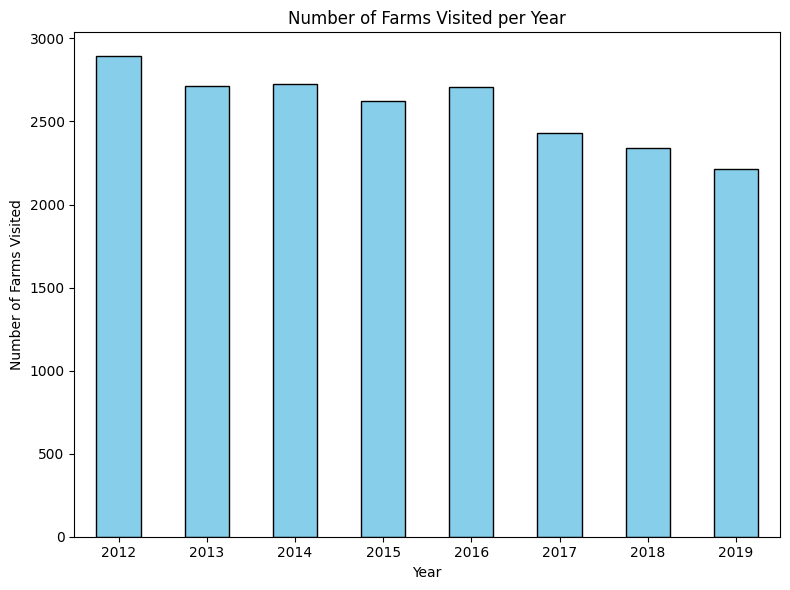

In [ ]:
# Group by year and count the number of unique farms visited each year
farms_visited_per_year = pivot_df.groupby('Year')['ID_independent'].nunique()

# Create a bar plot
plt.figure(figsize=(8, 6))
farms_visited_per_year.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Farms Visited per Year')
plt.xlabel('Year')
plt.ylabel('Number of Farms Visited')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
#count the number of values and NA

# List of columns to exclude
exclude_columns = ['ID_independent', 'Besuchsdatum', 'Year']

# Create a list of all columns without the excluded columns
columns = [col for col in pivot_df.columns if col not in exclude_columns]

In [ ]:
#count now the total 0, 1, 2 and NA
selected_columns = pivot_df[columns]

count_na = selected_columns.isna().sum().sum()
count_0 = (selected_columns == 0).sum().sum()
count_1 = (selected_columns == 1).sum().sum()
count_2 = (selected_columns == 2).sum().sum()

# Create a DataFrame to display the counts
counts_df = pd.DataFrame({
    'Category': ['NA', '0', '1', '2'],
    'Total Count': [count_na, count_0, count_1, count_2]
})

# Display the counts DataFrame
print(counts_df)

  Category  Total Count
0       NA         4500
1        0       159295
2        1        62952
3        2          403


In [ ]:
#count the number of values and NA

# List of columns to exclude
exclude_columns = ['ID_independent', 'Besuchsdatum', 'Year']

# Create a list of all columns without the excluded columns
columns = [col for col in pivot_df.columns if col not in exclude_columns]

# Count NA, 0, 1, and 2 values in each column
count_na = pivot_df[columns].isna().sum()
count_0 = (pivot_df[columns] == 0).sum()
count_1 = (pivot_df[columns] == 1).sum()
count_2 = (pivot_df[columns] == 2).sum()

# Create a summary DataFrame
summary = pd.DataFrame({
    'NA Count': count_na,
    '0 Count': count_0,
    '1 Count': count_1,
    '2 Count': count_2
})
# Display the summary DataFrame
print(summary)


                                        NA Count  0 Count  1 Count  2 Count
1.1 Besucherjournal                           15      668    19967        0
1.10 Fliegenbefall, -bekämpfung              206    17935     2259      250
1.11 Schadnagerspuren, -bekämpfung           228    18906     1439       77
1.2 Eingliederungsstall                       18    16332     4300        0
1.3 Datenauswertung                           15     6327    14308        0
1.4 Verladeeinrichtung                         0     6929    13721        0
1.5 Hygiene Eingangsbereich / Schleuse       207    14583     5829       31
1.6 Besucherhygiene                          184    20057      392       17
1.7 Instrumenten-/Gerätehygiene             2492    18056      100        2
1.8 Eingriffe - Kastration                   901    19694       43       12
1.9 Reinigung und Desinfektion               234    19808      594       14


The values seem to be the same

In [ ]:
pivot_df_backup=pivot_df

In [ ]:
#convert to categorical
# get column names of data frame in a list
col_names = list(pivot_df)
print("\nNames of dataframe columns")
print(col_names)

# loop to change each column to category type
for col in col_names:
    pivot_df[col] = pivot_df[col].astype('category',copy=False)


Names of dataframe columns
['ID_independent', 'Besuchsdatum', 'Year', '1.1 Besucherjournal', '1.10 Fliegenbefall, -bekämpfung', '1.11 Schadnagerspuren, -bekämpfung', '1.2 Eingliederungsstall', '1.3 Datenauswertung', '1.4 Verladeeinrichtung', '1.5 Hygiene Eingangsbereich / Schleuse', '1.6 Besucherhygiene', '1.7 Instrumenten-/Gerätehygiene', '1.8 Eingriffe - Kastration', '1.9 Reinigung und Desinfektion']


In [ ]:
#create a plot for each column

#create a list with the names of the columns except ID_independent
#column_names_list = [col for col in pivot_df.columns if col != 'ID_independent']

#for column_names_list in pivot_df.columns:
    # Count the occurrences of each category
    #category_counts = pivot_df[column_names_list].value_counts()

    # Sort the categories based on their order in the bin_labels list (if needed)
    # category_counts = category_counts.reindex(bin_labels)

    # Plot the bar chart
    #plt.figure()
    #category_counts.plot(kind='bar')
    #plt.title(f'Bar Plot for Column: {column_names_list}')
    #plt.xlabel('Categories')
    #plt.ylabel('Count')
    #plt.show()

In [ ]:
#create a column with the farm ID and put it as first column
pivot_df = pivot_df.reset_index()

# Rename the column containing row names to "Row Names"
pivot_df.rename(columns={'index': 'Row Names'}, inplace=True)

pivot_df

Row Names ID_independent Besuchsdatum  Year 1.1 Besucherjournal  \
0              0              1   2012-04-02  2012                 1.0   
1              1              2   2013-04-22  2013                 1.0   
2              2              3   2012-04-18  2012                 1.0   
3              3              4   2013-05-06  2013                 1.0   
4              4              5   2014-02-04  2014                 1.0   
...          ...            ...          ...   ...                 ...   
20645      20645          34312   2018-10-10  2018                 1.0   
20646      20646          34315   2019-02-13  2019                 1.0   
20647      20647          34317   2019-03-15  2019                 0.0   
20648      20648          34321   2019-07-04  2019                 1.0   
20649      20649          34323   2019-10-02  2019                 1.0   

      1.10 Fliegenbefall, -bekämpfung 1.11 Schadnagerspuren, -bekämpfung  \
0                                 0.0                                0.0   
1                                 0.0                                0.0   
2                                 0.0                                0.0   
3                                 0.0                                0.0   
4                                 0.0                                0.0   
...                               ...                                ...   
20645                             0.0                                0.0   
20646                             0.0                                0.0   
20647                             0.0                                0.0   
20648                             0.0                                0.0   
20649                             0.0                                0.0   

      1.2 Eingliederungsstall 1.3 Datenauswertung 1.4 Verladeeinrichtung  \
0                         0.0                 0.0                    0.0   
1                         0.0                 0.0                    0.0   
2                         0.0                 1.0                    1.0   
3                         1.0                 1.0                    1.0   
4                         1.0                 1.0                    1.0   
...                       ...                 ...                    ...   
20645                     0.0                 0.0                    0.0   
20646                     0.0                 1.0                    1.0   
20647                     0.0                 0.0                    0.0   
20648                     1.0                 1.0                    1.0   
20649                     0.0                 0.0                    0.0   

      1.5 Hygiene Eingangsbereich / Schleuse 1.6 Besucherhygiene  \
0                                        1.0                 0.0   
1                                        1.0                 0.0   
2                                        0.0                 0.0   
3                                        0.0                 0.0   
4                                        0.0                 0.0   
...                                      ...                 ...   
20645                                    1.0                 0.0   
20646                                    0.0                 0.0   
20647                                    NaN                 0.0   
20648                                    0.0                 0.0   
20649                                    1.0                 0.0   

      1.7 Instrumenten-/Gerätehygiene 1.8 Eingriffe - Kastration  \
0                                 0.0                        0.0   
1                                 0.0                        0.0   
2                                 0.0                        0.0   
3                                 0.0                        0.0   
4                                 0.0                        0.0   
...                               ...                        ...   

# Model


# Cluster

Slipt the dataset and check for clustering using K Modes:
- Imputation of missing values
- Elbow technique
- Silhouette score
- Cluster k Modes

In [ ]:
pip install scikit-learn

In [ ]:
pip install kmodes

In [ ]:
#select just the columns we will use
# List of columns to exclude
exclude_columns = ['ID_independent', 'Besuchsdatum', 'Year']
# Create a list of all columns without the excluded columns
columns = [col for col in pivot_df.columns if col not in exclude_columns]

split=pivot_df[columns]

split = split.drop('Row Names', axis=1)

In [ ]:
#imputation with mode (one possibility; later try the Predictive Imputation)
columns = split.columns.tolist()

# Replace NA values in each row with the mode of that row
def impute_row_mode(row):
    mode = row.mode().iloc[0]
    return row.fillna(mode)

# Apply the impute_row_mode function to each row in the DataFrame
split = split.apply(impute_row_mode, axis=1)
split

1.1 Besucherjournal  1.10 Fliegenbefall, -bekämpfung  \
0                      1.0                              0.0   
1                      1.0                              0.0   
2                      1.0                              0.0   
3                      1.0                              0.0   
4                      1.0                              0.0   
...                    ...                              ...   
20645                  1.0                              0.0   
20646                  1.0                              0.0   
20647                  0.0                              0.0   
20648                  1.0                              0.0   
20649                  1.0                              0.0   

       1.11 Schadnagerspuren, -bekämpfung  1.2 Eingliederungsstall  \
0                                     0.0                      0.0   
1                                     0.0                      0.0   
2                                     0.0                      0.0   
3                                     0.0                      1.0   
4                                     0.0                      1.0   
...                                   ...                      ...   
20645                                 0.0                      0.0   
20646                                 0.0                      0.0   
20647                                 0.0                      0.0   
20648                                 0.0                      1.0   
20649                                 0.0                      0.0   

       1.3 Datenauswertung  1.4 Verladeeinrichtung  \
0                      0.0                     0.0   
1                      0.0                     0.0   
2                      1.0                     1.0   
3                      1.0                     1.0   
4                      1.0                     1.0   
...                    ...                     ...   
20645                  0.0                     0.0   
20646                  1.0                     1.0   
20647                  0.0                     0.0   
20648                  1.0                     1.0   
20649                  0.0                     0.0   

       1.5 Hygiene Eingangsbereich / Schleuse  1.6 Besucherhygiene  \
0                                         1.0                  0.0   
1                                         1.0                  0.0   
2                                         0.0                  0.0   
3                                         0.0                  0.0   
4                                         0.0                  0.0   
...                                       ...                  ...   
20645                                     1.0                  0.0   
20646                                     0.0                  0.0   
20647                                     0.0                  0.0   
20648                                     0.0                  0.0   
20649                                     1.0                  0.0   

       1.7 Instrumenten-/Gerätehygiene  1.8 Eingriffe - Kastration  \
0                                  0.0                         0.0   
1                                  0.0                         0.0   
2                                  0.0                         0.0   
3                                  0.0                         0.0   
4                                  0.0                         0.0   
...                                ...                         ...   
20645                              0.0                         0.0   
20646                              0.0                         0.0   
20647                              0.0                         0.0   
20648                              0.0                         0.0   
20649                              0.0                         0.0   

       1.9 Reinigung und Desinfektion  
0                                 0.0 

In [ ]:
#check there are no NA anymore
# Count NA, 0, 1, and 2 values in the selected columns
count_na = split.isna().sum().sum()

# Create a DataFrame to display the counts
counts_df = pd.DataFrame({
    'Category': ['NA'],
    'Total Count': [count_na]
})

# Display the counts DataFrame
print(counts_df)

  Category  Total Count
0       NA            0


In [ ]:
#count the number of values in each column
count_0 = (split[columns] == 0).sum()
count_1 = (split[columns] == 1).sum()
count_2 = (split[columns] == 2).sum()

# Create a summary DataFrame
summary = pd.DataFrame({
    '0 Count': count_0,
    '1 Count': count_1,
    '2 Count': count_2
})
# Display the summary DataFrame
print(summary)

                                        0 Count  1 Count  2 Count
1.1 Besucherjournal                         682    19968        0
1.10 Fliegenbefall, -bekämpfung           18075     2325      250
1.11 Schadnagerspuren, -bekämpfung        19065     1508       77
1.2 Eingliederungsstall                   16349     4301        0
1.3 Datenauswertung                        6342    14308        0
1.4 Verladeeinrichtung                     6929    13721        0
1.5 Hygiene Eingangsbereich / Schleuse    14743     5876       31
1.6 Besucherhygiene                       20189      444       17
1.7 Instrumenten-/Gerätehygiene           20381      267        2
1.8 Eingriffe - Kastration                20458      180       12
1.9 Reinigung und Desinfektion            19971      665       14


In [ ]:
#check how much the average of the values in each column changed with the imputation
# Create a copy to avoid modifying the original DataFrame
numeric_df = split.copy()

# Convert categorical columns to numeric
numeric_df = numeric_df.apply(pd.to_numeric, errors='coerce')

# Calculate the average of each column
column_averages = numeric_df.mean()

column_averages

1.1 Besucherjournal                       0.966973
1.10 Fliegenbefall, -bekämpfung           0.136804
1.11 Schadnagerspuren, -bekämpfung        0.080484
1.2 Eingliederungsstall                   0.208281
1.3 Datenauswertung                       0.692881
1.4 Verladeeinrichtung                    0.664455
1.5 Hygiene Eingangsbereich / Schleuse    0.287554
1.6 Besucherhygiene                       0.023148
1.7 Instrumenten-/Gerätehygiene           0.013123
1.8 Eingriffe - Kastration                0.009879
1.9 Reinigung und Desinfektion            0.033559
dtype: float64

In [ ]:
#divide the dataset in 80-10-10
#from sklearn.model_selection import train_test_split

# Split the dataset into training (80%) and temporary (20%)
#Train, Temp = train_test_split(split, test_size=0.20, random_state=42)

# Split the temporary data into validation (10%) and test (10%)
#Validation, Test = train_test_split(Temp, test_size=0.50, random_state=42)

# Print the shapes of the resulting datasets to verify the splits
#print("Training set shape:", Train.shape)
#print("Validation set shape:", Validation.shape)
#print("Test set shape:", Test.shape)

In [ ]:
#for the unsupervised we do not need to divide the dataset, so we will use the entire data set
df=split

In [ ]:
#Train.dtypes
df.dtypes

1.1 Besucherjournal                       float64
1.10 Fliegenbefall, -bekämpfung           float64
1.11 Schadnagerspuren, -bekämpfung        float64
1.2 Eingliederungsstall                   float64
1.3 Datenauswertung                       float64
1.4 Verladeeinrichtung                    float64
1.5 Hygiene Eingangsbereich / Schleuse    float64
1.6 Besucherhygiene                       float64
1.7 Instrumenten-/Gerätehygiene           float64
1.8 Eingriffe - Kastration                float64
1.9 Reinigung und Desinfektion            float64
dtype: object

In [ ]:
# Convert all columns from float to integer
df = df.astype(int)

In [ ]:
#Variable types
df.dtypes

1.1 Besucherjournal                       int64
1.10 Fliegenbefall, -bekämpfung           int64
1.11 Schadnagerspuren, -bekämpfung        int64
1.2 Eingliederungsstall                   int64
1.3 Datenauswertung                       int64
1.4 Verladeeinrichtung                    int64
1.5 Hygiene Eingangsbereich / Schleuse    int64
1.6 Besucherhygiene                       int64
1.7 Instrumenten-/Gerätehygiene           int64
1.8 Eingriffe - Kastration                int64
1.9 Reinigung und Desinfektion            int64
dtype: object

Recalculate the values of mean, median and quartiles after imputation

In [ ]:
#with different methods we get slight differences in the mean values. It depends on the approaches used by the functions to deal with the nasn, most probably.
#in this way Nan are excluded - but this is using a dataset

# Calculate the average for each column (except ID_independent)
average_df = df.mean()

# Calculate the mean for each column (except ID_independent)
median_df = df.median()

# Calculate the 1st quantile (25th percentile) for each column (except ID_independent)
quantile_25_df = df.quantile(0.25)

# Calculate the 3rd quantile (75th percentile) for each column (except ID_independent)
quantile_75_df = df.quantile(0.75)

# Combine the results into a single DataFrame
result_df = pd.concat([average_df, median_df, quantile_25_df, quantile_75_df], axis=1)
result_df.columns = ['Average', 'Median', '1st Quantile', '3rd Quantile']

# Display the resulting DataFrame
print(result_df)

                                         Average  Median  1st Quantile  \
1.1 Besucherjournal                     0.966973     1.0           1.0   
1.10 Fliegenbefall, -bekämpfung         0.136804     0.0           0.0   
1.11 Schadnagerspuren, -bekämpfung      0.080484     0.0           0.0   
1.2 Eingliederungsstall                 0.208281     0.0           0.0   
1.3 Datenauswertung                     0.692881     1.0           0.0   
1.4 Verladeeinrichtung                  0.664455     1.0           0.0   
1.5 Hygiene Eingangsbereich / Schleuse  0.287554     0.0           0.0   
1.6 Besucherhygiene                     0.023148     0.0           0.0   
1.7 Instrumenten-/Gerätehygiene         0.013123     0.0           0.0   
1.8 Eingriffe - Kastration              0.009879     0.0           0.0   
1.9 Reinigung und Desinfektion          0.033559     0.0           0.0   

                                        3rd Quantile  
1.1 Besucherjournal                              1.0  
1

In [ ]:
# Check for NaN values
nan_mask = df.isna()

# Display the DataFrame and the NaN mask
print("Original DataFrame:")
print(df)
print("\nNaN Mask:")
print(nan_mask)

Original DataFrame:
       1.1 Besucherjournal  1.10 Fliegenbefall, -bekämpfung  \
0                        1                                0   
1                        1                                0   
2                        1                                0   
3                        1                                0   
4                        1                                0   
...                    ...                              ...   
20645                    1                                0   
20646                    1                                0   
20647                    0                                0   
20648                    1                                0   
20649                    1                                0   

       1.11 Schadnagerspuren, -bekämpfung  1.2 Eingliederungsstall  \
0                                       0                        0   
1                                       0                        0   
2            

Plot the values of each variable independently

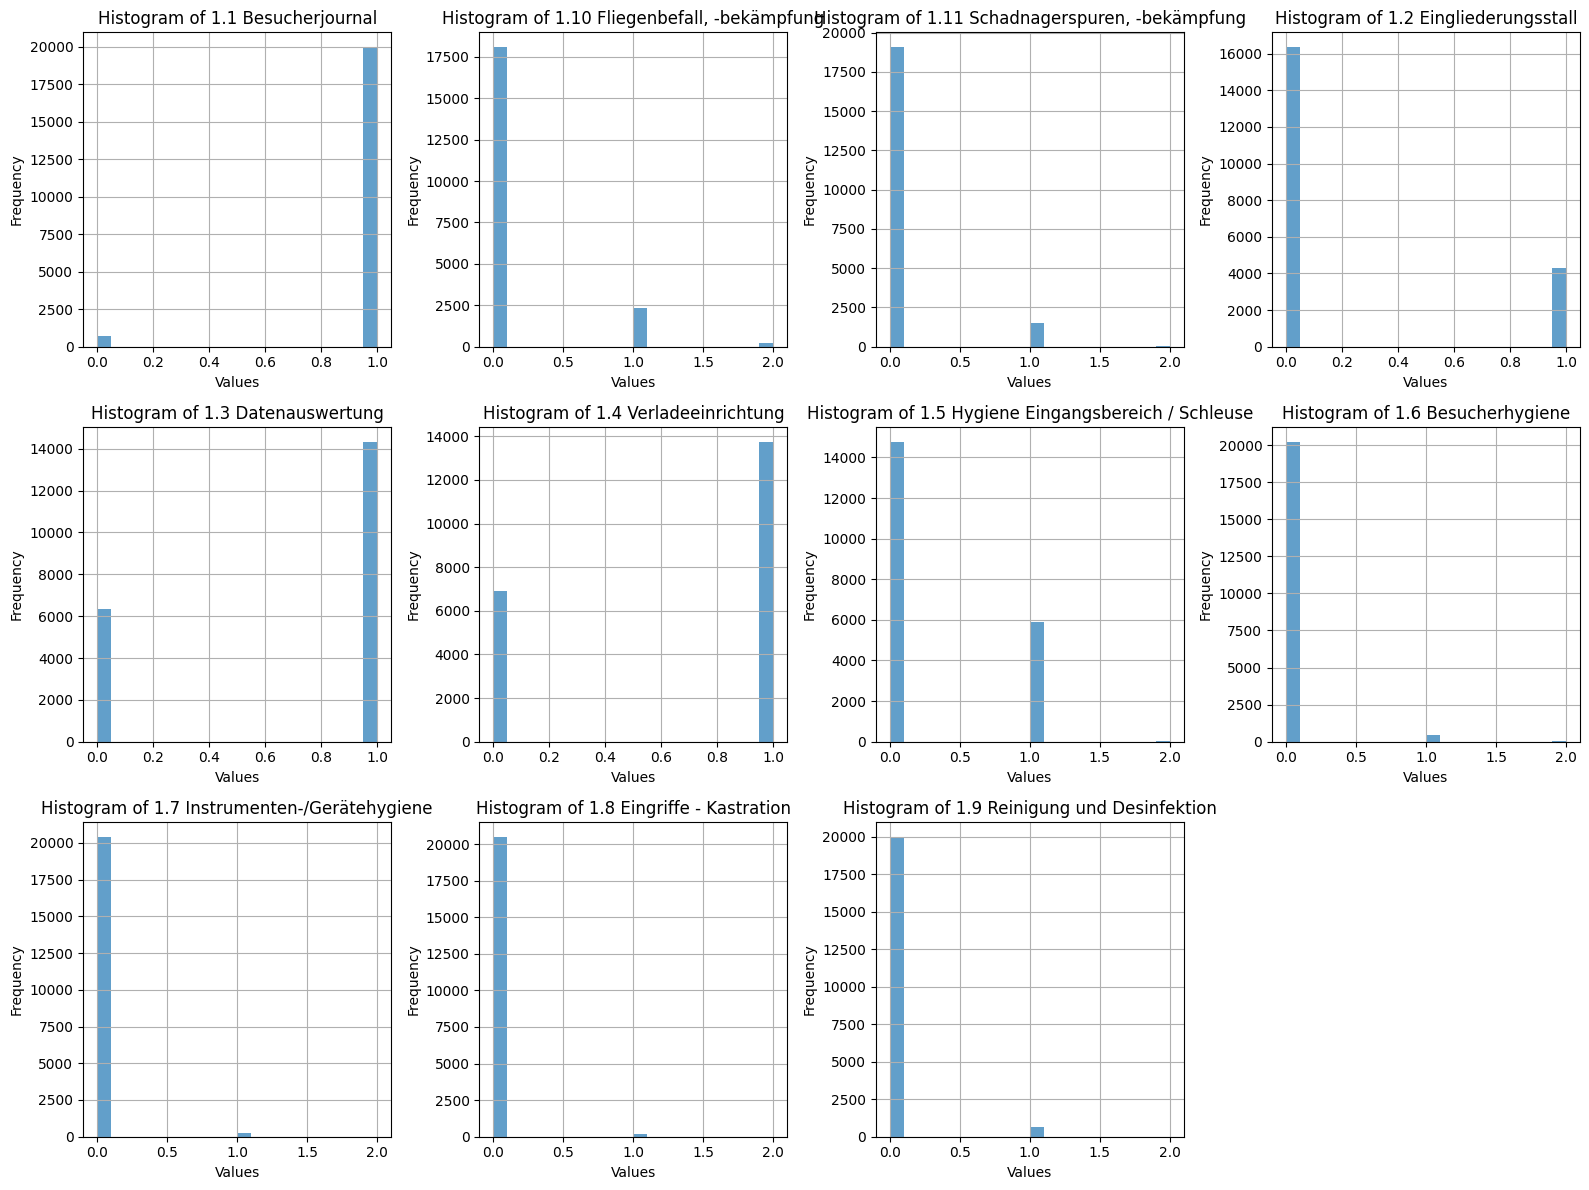

In [ ]:
import matplotlib.pyplot as plt

# Calculate the number of subplots needed
num_columns = df.shape[1]
num_rows = (num_columns + 3) // 4  # Ensure at least one plot if there's one column

# Plot histograms for each variable separately
fig, axs = plt.subplots(num_rows, 4, figsize=(16, num_rows * 4))  # Create subplots

for i, column in enumerate(df.columns):
    row_index = i // 4
    col_index = i % 4
    axs[row_index, col_index].hist(df[column], bins=20, alpha=0.7)
    axs[row_index, col_index].set_title('Histogram of ' + column)
    axs[row_index, col_index].set_xlabel('Values')
    axs[row_index, col_index].set_ylabel('Frequency')
    axs[row_index, col_index].grid(True)

# Hide any extra subplots if the number of columns isn't a multiple of 4
if num_columns % 4 != 0:
    for i in range(num_columns % 4, 4):
        axs[num_rows - 1, i].axis('off')

plt.tight_layout()
plt.show()


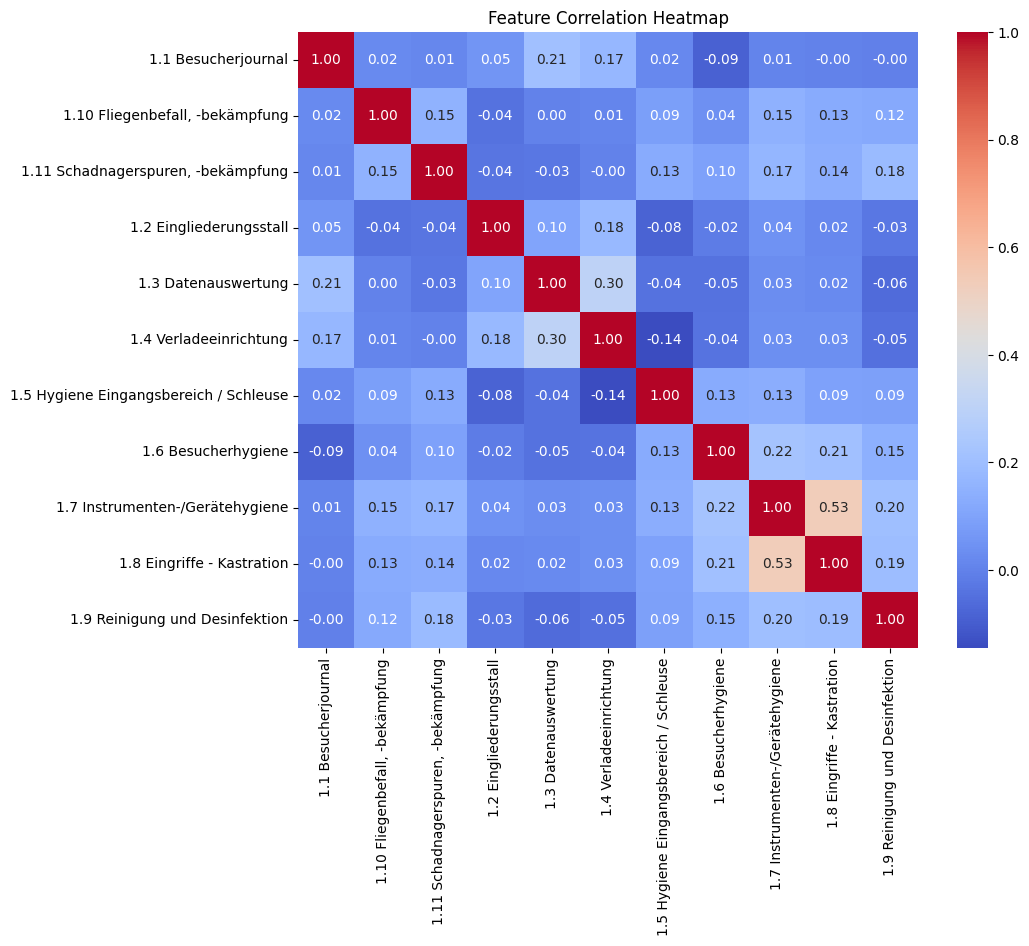

In [ ]:
#check for the existance of correlation between the biosecurity criteria

import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()


Determine number of clusters

**K modes requires a lot of computational capacity and colab generally turns off before the analysis with more than 40 clusters. As the data is numeric, we will use K means, which is less computatioal demanding (and therefore, faster).**
----------------------------------------------------------------------

In [ ]:
df

1.1 Besucherjournal  1.10 Fliegenbefall, -bekämpfung  \
0                        1                                0   
1                        1                                0   
2                        1                                0   
3                        1                                0   
4                        1                                0   
...                    ...                              ...   
20645                    1                                0   
20646                    1                                0   
20647                    0                                0   
20648                    1                                0   
20649                    1                                0   

       1.11 Schadnagerspuren, -bekämpfung  1.2 Eingliederungsstall  \
0                                       0                        0   
1                                       0                        0   
2                                       0                        0   
3                                       0                        1   
4                                       0                        1   
...                                   ...                      ...   
20645                                   0                        0   
20646                                   0                        0   
20647                                   0                        0   
20648                                   0                        1   
20649                                   0                        0   

       1.3 Datenauswertung  1.4 Verladeeinrichtung  \
0                        0                       0   
1                        0                       0   
2                        1                       1   
3                        1                       1   
4                        1                       1   
...                    ...                     ...   
20645                    0                       0   
20646                    1                       1   
20647                    0                       0   
20648                    1                       1   
20649                    0                       0   

       1.5 Hygiene Eingangsbereich / Schleuse  1.6 Besucherhygiene  \
0                                           1                    0   
1                                           1                    0   
2                                           0                    0   
3                                           0                    0   
4                                           0                    0   
...                                       ...                  ...   
20645                                       1                    0   
20646                                       0                    0   
20647                                       0                    0   
20648                                       0                    0   
20649                                       1                    0   

       1.7 Instrumenten-/Gerätehygiene  1.8 Eingriffe - Kastration  \
0                                    0                           0   
1                                    0                           0   
2                                    0                           0   
3                                    0                           0   
4                                    0                           0   
...                                ...                         ...   
20645                                0                           0   
20646                                0                           0   
20647                                0                           0   
20648                                0                           0   
20649                                0                           0   

       1.9 Reinigung und Desinfektion  
0                                   0 

Histogram of the pairwise distances of all points in a data set; it can give an indication if there more than one cluster exists.

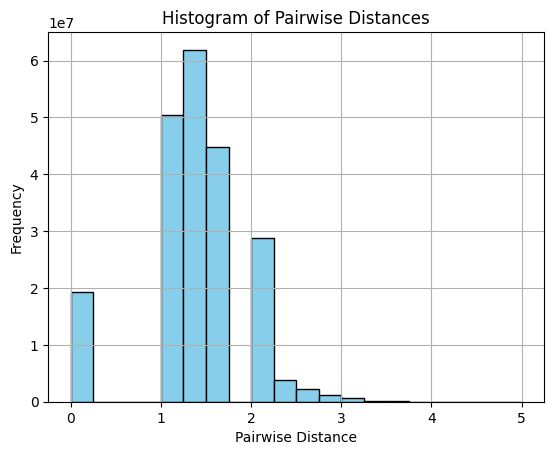

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.spatial.distance import pdist

# Step 1: Calculate pairwise distances
pairwise_distances = pdist(df.values, metric='euclidean')

# Step 2: Flatten the pairwise distance matrix
pairwise_distances_flat = pairwise_distances.flatten()

# Step 3: Plot the histogram
plt.hist(pairwise_distances_flat, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Pairwise Distances')
plt.xlabel('Pairwise Distance')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


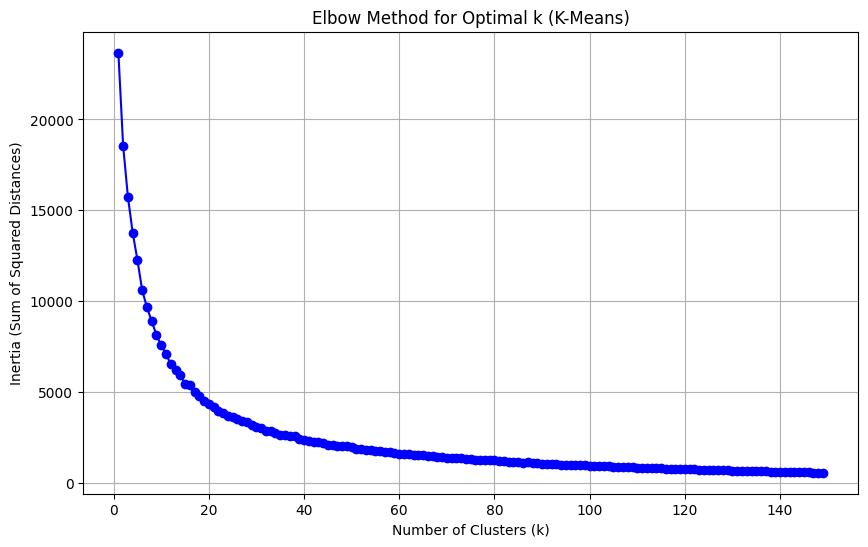

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Define a range of cluster numbers
clusters = range(1,150)

# Initialize an empty list to store the inertia values (sum of squared distances)
inertia_values = []

# Calculate the inertia for different numbers of clusters
for k in clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df)
    inertia_values.append(kmeans.inertia_)

# Plot the inertia values for different cluster numbers
plt.figure(figsize=(10, 6))
plt.plot(clusters, inertia_values, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal k (K-Means)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.grid(True)


plt.show()

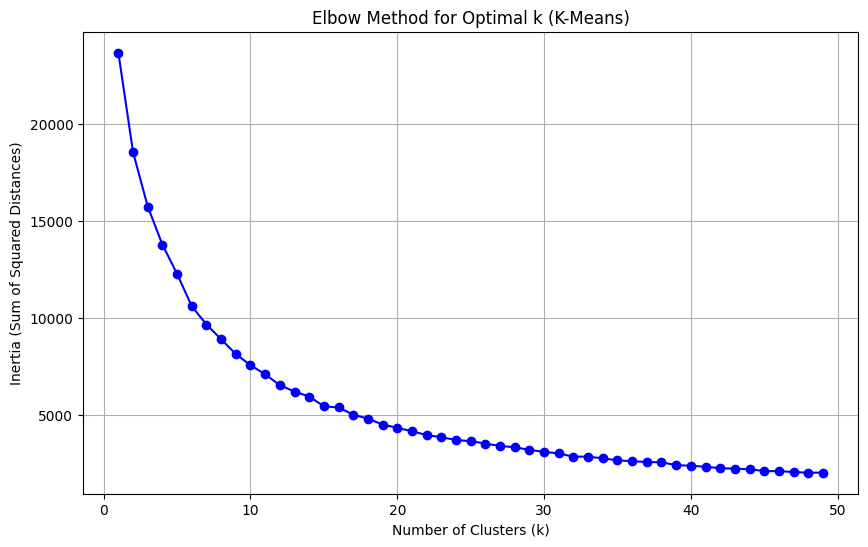

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Define a range of cluster numbers
clusters = range(1,50)

# Initialize an empty list to store the inertia values (sum of squared distances)
inertia_values = []

# Calculate the inertia for different numbers of clusters
for k in clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df)
    inertia_values.append(kmeans.inertia_)

# Plot the inertia values for different cluster numbers
plt.figure(figsize=(10, 6))
plt.plot(clusters, inertia_values, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal k (K-Means)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.grid(True)


plt.show()

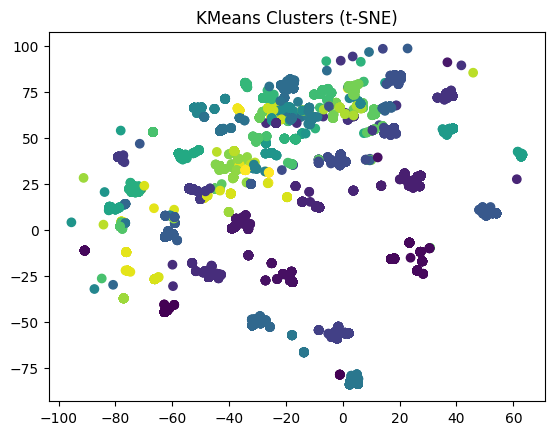

In [ ]:
# t-SNE (for potentially non-linear relationships)
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(df)

# Scatter plots with PCA or t-SNE data colored by cluster labels
if tsne_data is not None:
    plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=kmeans.labels_)
    plt.title("KMeans Clusters (t-SNE)")
    plt.show()

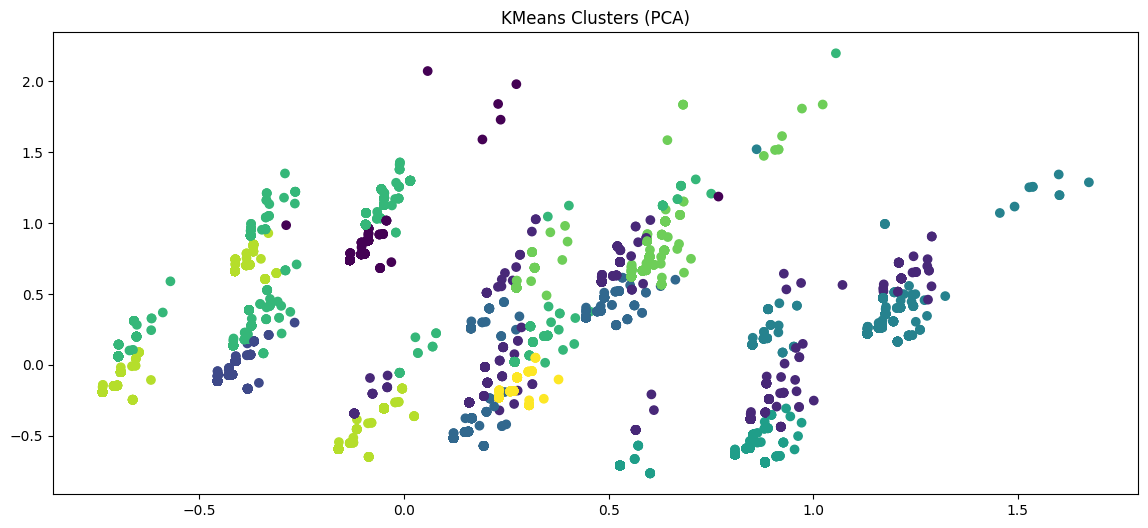

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE

# PCA (for potentially linear relationships)
pca = PCA(n_components=2)  # Reduce to 2D for visualization
pca_data = pca.fit_transform(df)

# Scatter plots with PCA or t-SNE data colored by cluster labels
if pca_data is not None:
    plt.scatter(pca_data[:, 0], pca_data[:, 1], c=kmeans.labels_)
    plt.title("KMeans Clusters (PCA)")
    plt.show()

##################################################

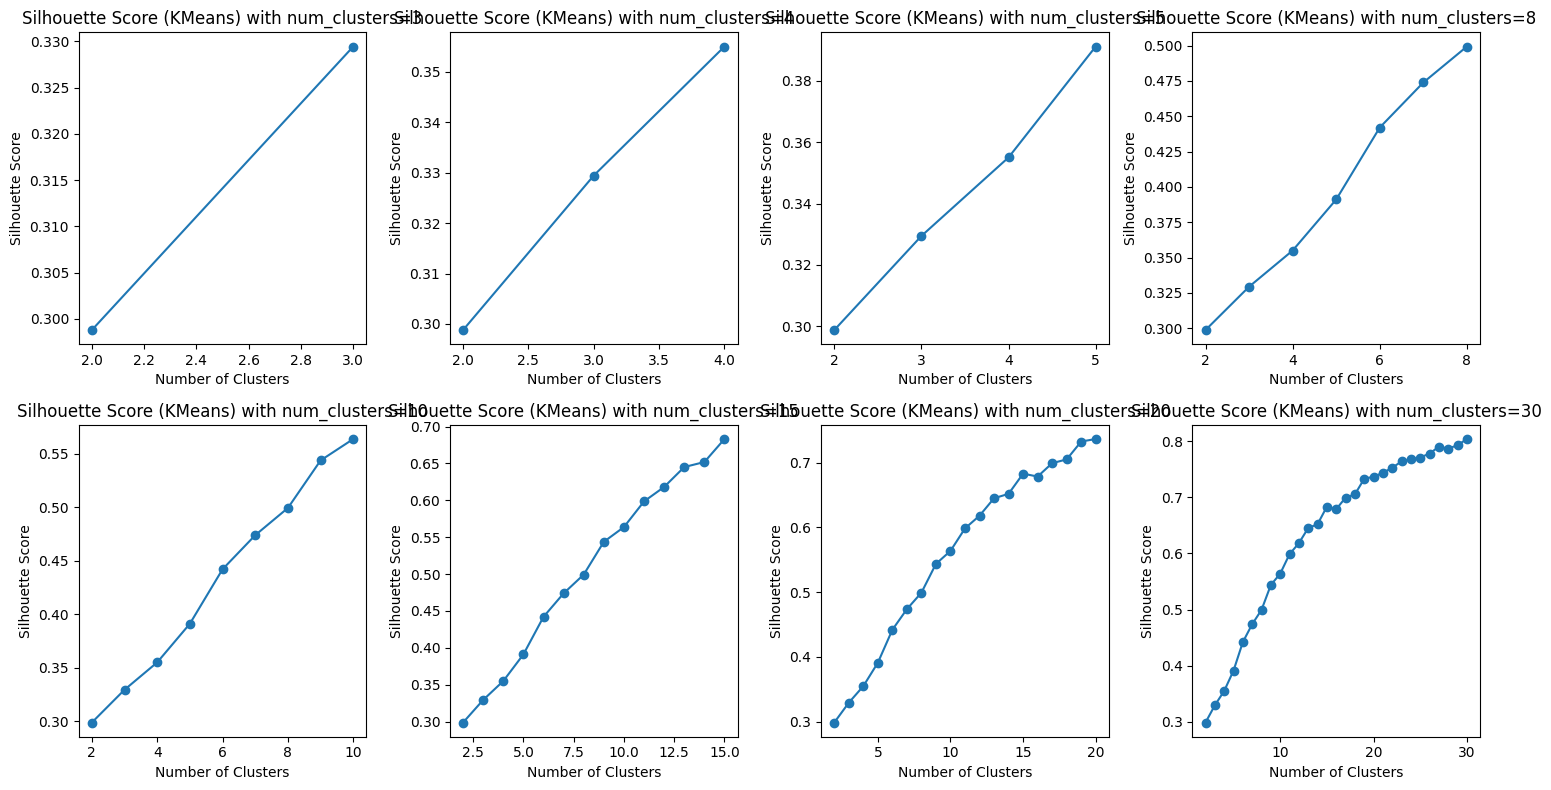

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 4, figsize=(15, 8))

# Define number of clusters
num_clusters_list = [3,4,5,8,10,15,20,30]

# Iterate over different numbers of clusters
for i, num_clusters in enumerate(num_clusters_list):
    silhouette_scores = []

    # Iterate over different numbers of clusters within the specified range
    for clusters in range(2, num_clusters + 1):
        kmeans = KMeans(n_clusters=clusters, random_state=42, max_iter=60)
        cluster_labels = kmeans.fit_predict(df)
        silhouette_avg = silhouette_score(df, cluster_labels)
        silhouette_scores.append(silhouette_avg)

    # Use the enumerate variable i to determine the position in the 2x4 grid
    row, col = divmod(i, 4)

    # Plot inside the loop to create separate plots for each i
    ax[row, col].plot(range(2, num_clusters + 1), silhouette_scores, marker='o')
    ax[row, col].set_xlabel('Number of Clusters')
    ax[row, col].set_ylabel('Silhouette Score')
    ax[row, col].set_title(f'Silhouette Score (KMeans) with num_clusters={num_clusters}')

plt.tight_layout()
plt.show()



Silhouette score plots

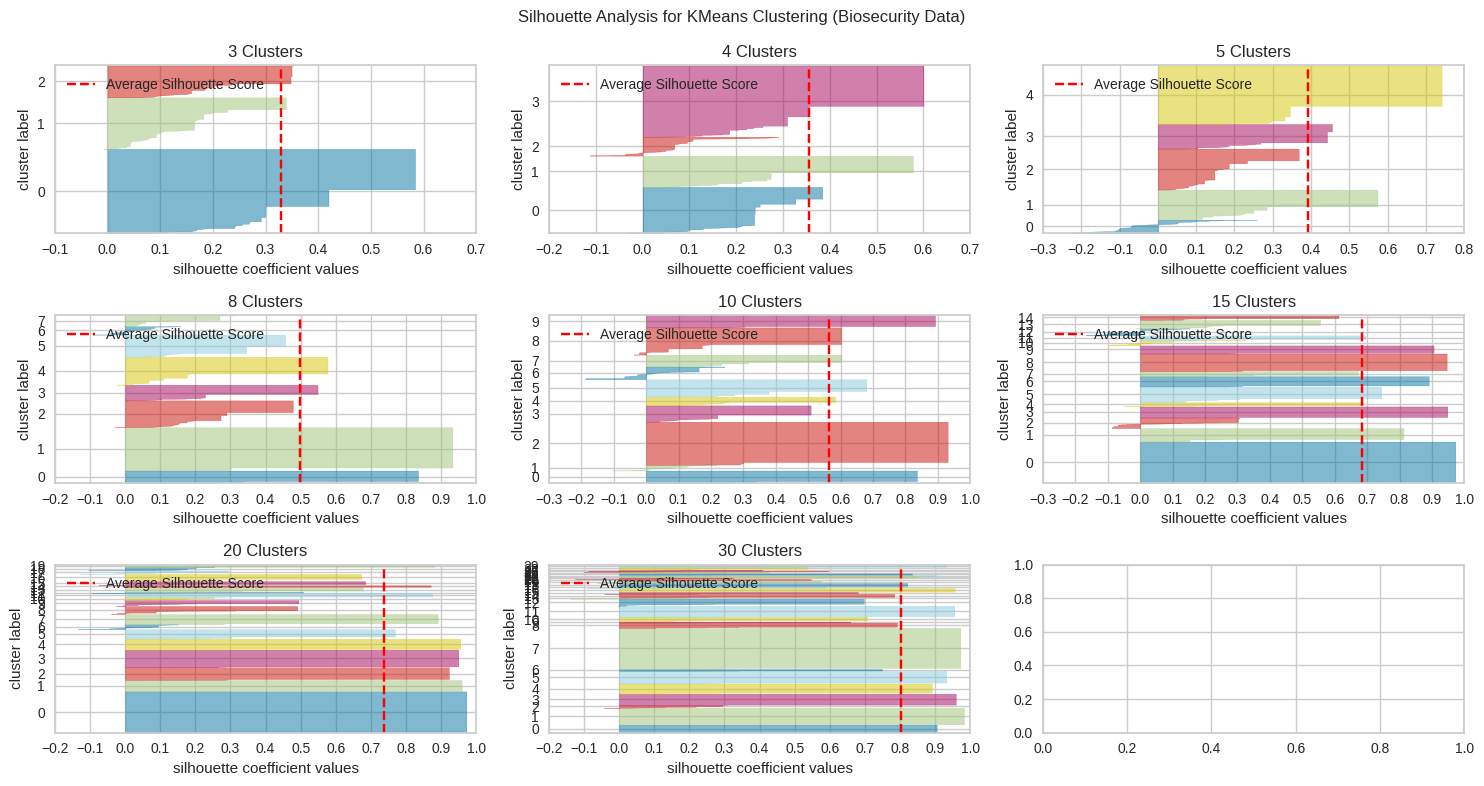

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


fig, ax = plt.subplots(3, 3, figsize=(15, 8))

cluster_counts = [3,4,5,8,10,15,20,30]

for i, count in enumerate(cluster_counts):
    # Create KMeans instance
    kmeans = KMeans(n_clusters=count, random_state=42)

    # Fit the model on data
    cluster_labels = kmeans.fit_predict(df)

    # Create SilhouetteVisualizer instance with kmeans instance and fitted data
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=ax[i // 3][i % 3])
    visualizer.fit(df)  # No need to pass cluster_labels as kmeans generates them
    visualizer.finalize()

    # Add title for each subplot based on cluster count
    ax[i // 3][i % 3].set_title(f"{count} Clusters")

plt.suptitle("Silhouette Analysis for KMeans Clustering (Biosecurity Data)", fontsize=12)
plt.tight_layout()
plt.show()


With K Modes

Change the numbers to categories to try with k-modes

In [ ]:
df_modes=df

import pandas as pd

# Define a dictionary for mapping values
conversion_dict = {0: "best", 1: "medium", 2: "worse"}

# Apply the conversion to each column using a list comprehension
df_modes = df_modes.replace(conversion_dict)

# Print or display the modified DataFrame
df_modes



1.1 Besucherjournal 1.10 Fliegenbefall, -bekämpfung  \
0                  medium                            best   
1                  medium                            best   
2                  medium                            best   
3                  medium                            best   
4                  medium                            best   
...                   ...                             ...   
20645              medium                            best   
20646              medium                            best   
20647                best                            best   
20648              medium                            best   
20649              medium                            best   

      1.11 Schadnagerspuren, -bekämpfung 1.2 Eingliederungsstall  \
0                                   best                    best   
1                                   best                    best   
2                                   best                    best   
3                                   best                  medium   
4                                   best                  medium   
...                                  ...                     ...   
20645                               best                    best   
20646                               best                    best   
20647                               best                    best   
20648                               best                  medium   
20649                               best                    best   

      1.3 Datenauswertung 1.4 Verladeeinrichtung  \
0                    best                   best   
1                    best                   best   
2                  medium                 medium   
3                  medium                 medium   
4                  medium                 medium   
...                   ...                    ...   
20645                best                   best   
20646              medium                 medium   
20647                best                   best   
20648              medium                 medium   
20649                best                   best   

      1.5 Hygiene Eingangsbereich / Schleuse 1.6 Besucherhygiene  \
0                                     medium                best   
1                                     medium                best   
2                                       best                best   
3                                       best                best   
4                                       best                best   
...                                      ...                 ...   
20645                                 medium                best   
20646                                   best                best   
20647                                   best                best   
20648                                   best                best   
20649                                 medium                best   

      1.7 Instrumenten-/Gerätehygiene 1.8 Eingriffe - Kastration  \
0                                best                       best   
1                                best                       best   
2                                best                       best   
3                                best                       best   
4                                best                       best   
...                               ...                        ...   
20645                            best                       best   
20646                            best                       best   
20647                            best                       best   
20648                            best                       best   
20649                            best                       best   

      1.9 Reinigung und Desinfektion  
0                               best  
1                               best  
2                               best  
3                               best  
4 

Elbow method

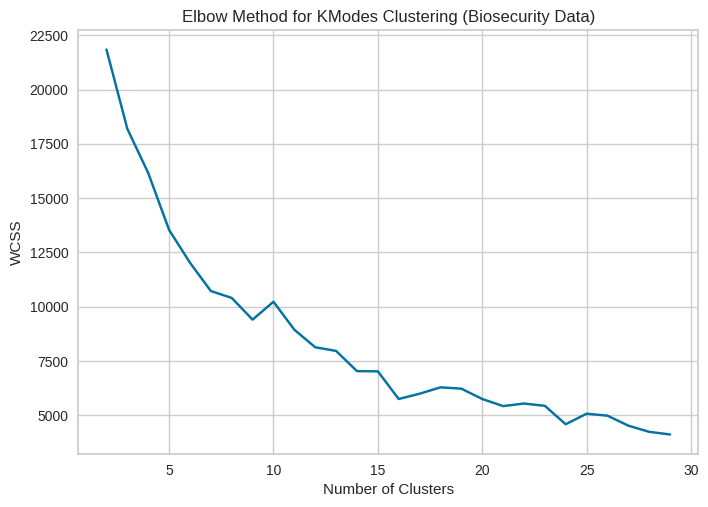

In [ ]:
from kmodes.kmodes import KModes
import matplotlib.pyplot as plt

cluster_range = range(2, 30)
wcss_scores = []

for n_clusters in cluster_range:
  # Create KModes instance for categorical data clustering
  kmodes = KModes(n_clusters=n_clusters, random_state=42, init='Huang')

  # Fit the model on data
  kmodes.fit(df_modes)

  # Calculate WCSS for this number of clusters
  wcss_scores.append(kmodes.cost_)  # Access WCSS from KModes model

# Plot WCSS vs number of clusters
plt.plot(cluster_range, wcss_scores)
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.title("Elbow Method for KModes Clustering (Biosecurity Data)")
plt.show()


Silhouette score

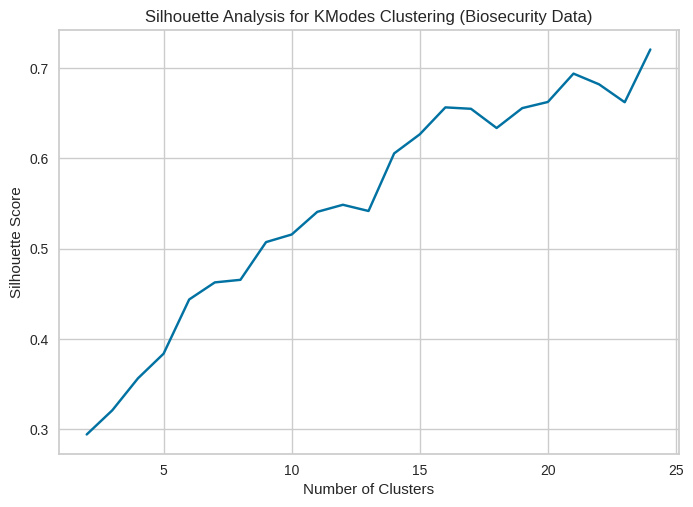

In [ ]:
from kmodes.kmodes import KModes
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

cluster_range = range(2, 25)
silhouette_scores = []

for n_clusters in cluster_range:
  # Create KModes
  kmodes = KModes(n_clusters=n_clusters, random_state=42, init='Huang')

  # Fit the model on data
  kmodes.fit(df_modes)

  # Calculate silhouette score for this number of clusters
  silhouette_score_val = silhouette_score(df, kmodes.labels_)
  silhouette_scores.append(silhouette_score_val)

# Plot silhouette scores vs number of clusters
plt.plot(cluster_range, silhouette_scores)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis for KModes Clustering (Biosecurity Data)")
plt.show()


**t_SNE**

Define the perplexity value

In [ ]:
from sklearn.manifold import TSNE
import numpy as np
import plotly.express as px

perplexity = np.arange(1, 50, 1)
divergence = []

for i in perplexity:
    model = TSNE(n_components=2, init="pca", perplexity=i)
    reduced = model.fit_transform(df)
    divergence.append(model.kl_divergence_)

fig = px.line(x=perplexity, y=divergence, markers=True)  # Use px.line for line plot
fig.update_layout(xaxis_title="Perplexity Values", yaxis_title="Divergence")
fig.update_traces(line_color="red", line_width=1)
fig.show()


In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=6) # Reduce to 2D for visualization
tsne_data = tsne.fit_transform(df)
tsne.kl_divergence_

0.22707882523536682

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=8) # Reduce to 2D for visualization
tsne_data = tsne.fit_transform(df)
tsne.kl_divergence_

0.31319093704223633

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=10) # Reduce to 2D for visualization
tsne_data = tsne.fit_transform(df)
tsne.kl_divergence_

0.2668655216693878

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=40) # Reduce to 2D for visualization
tsne_data = tsne.fit_transform(df)
tsne.kl_divergence_

0.28990301489830017

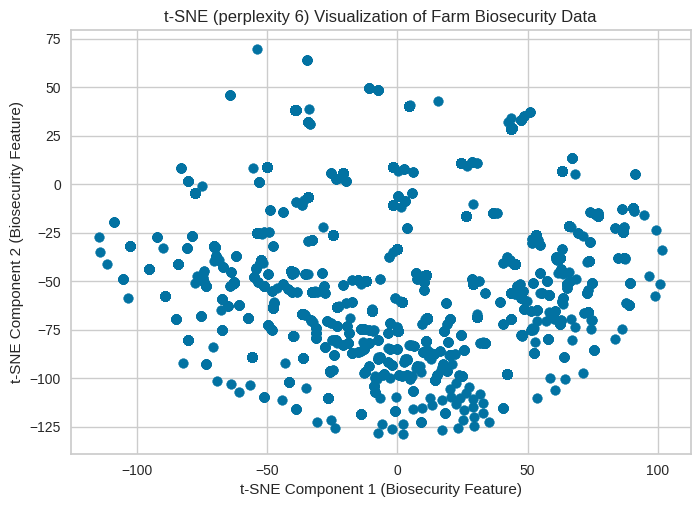

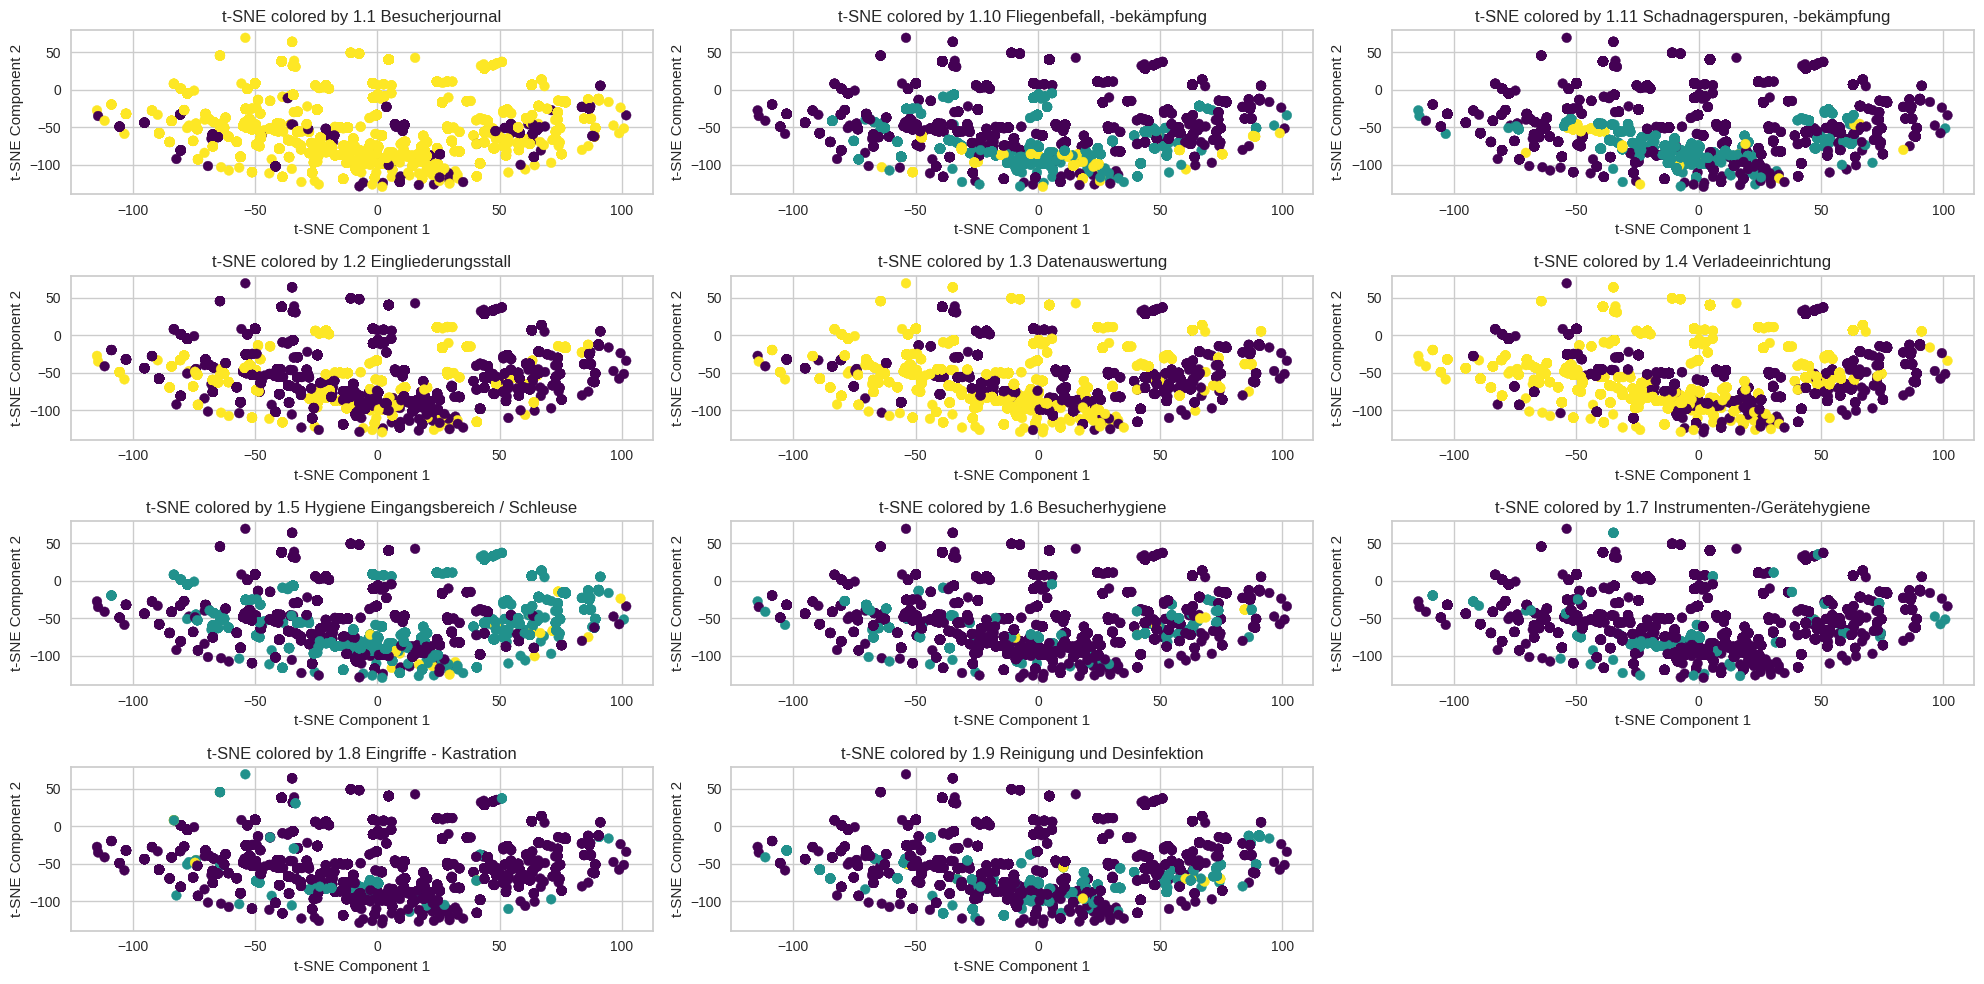

In [ ]:
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.manifold import TSNE

# Number of plots
num_plots = 11

# color map
cmap = plt.cm.get_cmap('viridis')

# Get all column names except the first one
column_names = df[0:]

# Apply t-SNE
tsne = TSNE(n_components=2 , perplexity=6) # Reduce to 2D for visualization
tsne_data = tsne.fit_transform(df)

# Separate the data into two components
tsne_features = tsne_data[:, 0]
tsne_targets = tsne_data[:, 1]

# General Plot
plt.scatter(tsne_features, tsne_targets)
plt.xlabel('t-SNE Component 1 (Biosecurity Feature)')
plt.ylabel('t-SNE Component 2 (Biosecurity Feature)')
plt.title('t-SNE (perplexity 6) Visualization of Farm Biosecurity Data')
plt.grid(True)
plt.show()

plt.figure(figsize=(20, 10))

# Loop through each column name and create a scatter plot with color coding
for i, col_name in enumerate(column_names):
    # Create a scatter plot
    plt.subplot(4, 3, i + 1)
    plt.scatter(tsne_features, tsne_targets, c=df[col_name], cmap=cmap)

    # Optional: Add labels and title for each plot
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.title(f't-SNE colored by {col_name}')

    plt.grid(True)

plt.tight_layout()
plt.show()


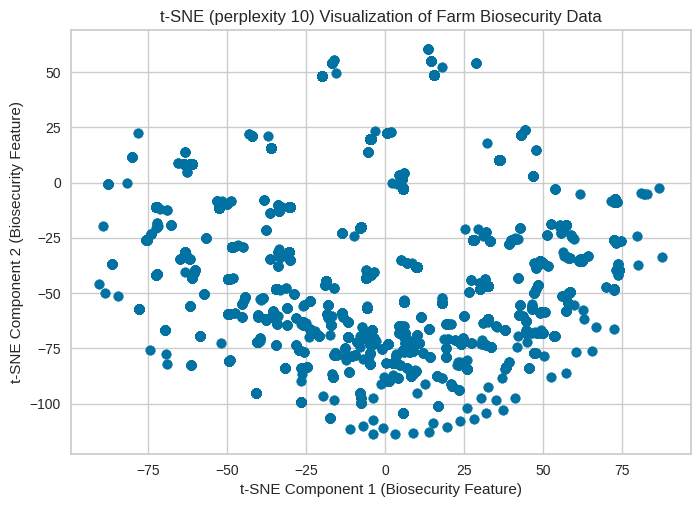

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.manifold import TSNE

# Define number of plots
num_plots = 11

# Create a color map
cmap = plt.cm.get_cmap('viridis')

# Get all column names except the first one
column_names = df[0:]

# Apply t-SNE to all features
tsne = TSNE(n_components=2 , perplexity=10)
tsne_data = tsne.fit_transform(df)

# Separate data into two components
tsne_features = tsne_data[:, 0]
tsne_targets = tsne_data[:, 1]

# General Plot
plt.scatter(tsne_features, tsne_targets)
plt.xlabel('t-SNE Component 1 (Biosecurity Feature)')
plt.ylabel('t-SNE Component 2 (Biosecurity Feature)')
plt.title('t-SNE (perplexity 10) Visualization of Farm Biosecurity Data')
plt.grid(True)
plt.show()

plt.figure(figsize=(20, 10))



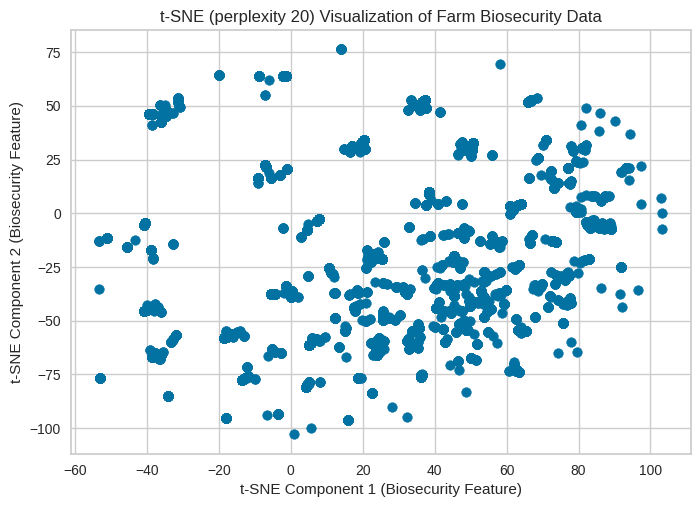

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.manifold import TSNE

# Define the number of plots
num_plots = 11

# Create a color map
cmap = plt.cm.get_cmap('viridis')

# Get all column names except the first one
column_names = df[0:]

# Apply t-SNE to all features
tsne = TSNE(n_components=2 , perplexity=20)
tsne_data = tsne.fit_transform(df)

# Separate the data into two components for plotting
tsne_features = tsne_data[:, 0]
tsne_targets = tsne_data[:, 1]

# General Plot
plt.scatter(tsne_features, tsne_targets)
plt.xlabel('t-SNE Component 1 (Biosecurity Feature)')
plt.ylabel('t-SNE Component 2 (Biosecurity Feature)')
plt.title('t-SNE (perplexity 20) Visualization of Farm Biosecurity Data')
plt.grid(True)
plt.show()

plt.figure(figsize=(20, 10))



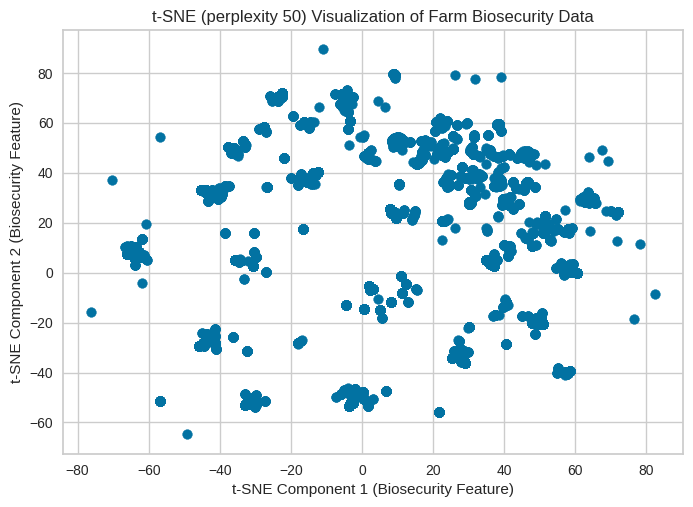

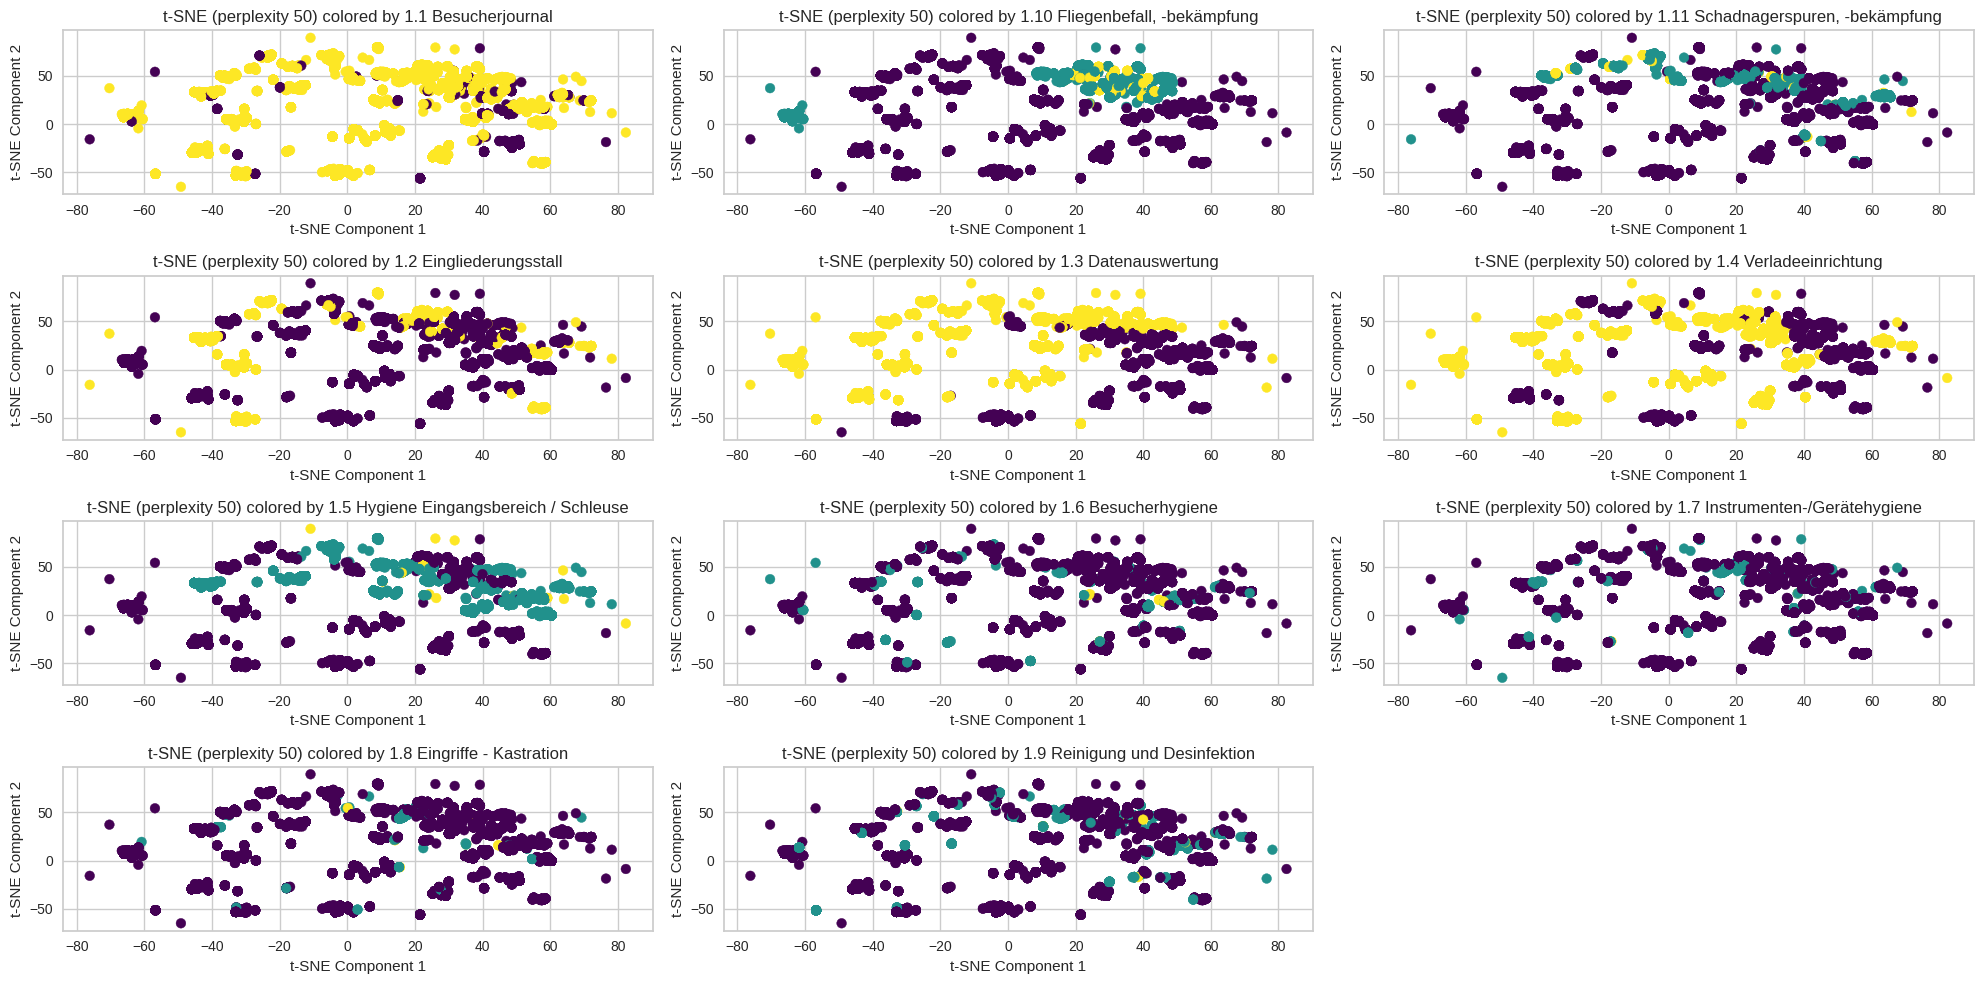

In [ ]:
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.manifold import TSNE

# Define the number of plots
num_plots = 11

# Create a color map
cmap = plt.cm.get_cmap('viridis')

# Get all column names except the first one
column_names = df[0:]

# Apply t-SNE to all features (excluding ID)
tsne = TSNE(n_components=2 , perplexity=50)
tsne_data = tsne.fit_transform(df)

# Separate the data into two components
tsne_features = tsne_data[:, 0]
tsne_targets = tsne_data[:, 1]

# General Plot
plt.scatter(tsne_features, tsne_targets)
plt.xlabel('t-SNE Component 1 (Biosecurity Feature)')
plt.ylabel('t-SNE Component 2 (Biosecurity Feature)')
plt.title('t-SNE (perplexity 50) Visualization of Farm Biosecurity Data')
plt.grid(True)
plt.show()

# Increase the figure width
plt.figure(figsize=(20, 10))

# Loop through each column name and create a scatter plot with color coding
for i, col_name in enumerate(column_names):
    # Create a scatter plot
    plt.subplot(4, 3, i + 1)
    plt.scatter(tsne_features, tsne_targets, c=df[col_name], cmap=cmap)

    # Optional: Add labels and title for each plot
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.title(f't-SNE (perplexity 50) colored by {col_name}')

    plt.grid(True)

plt.tight_layout()
plt.show()

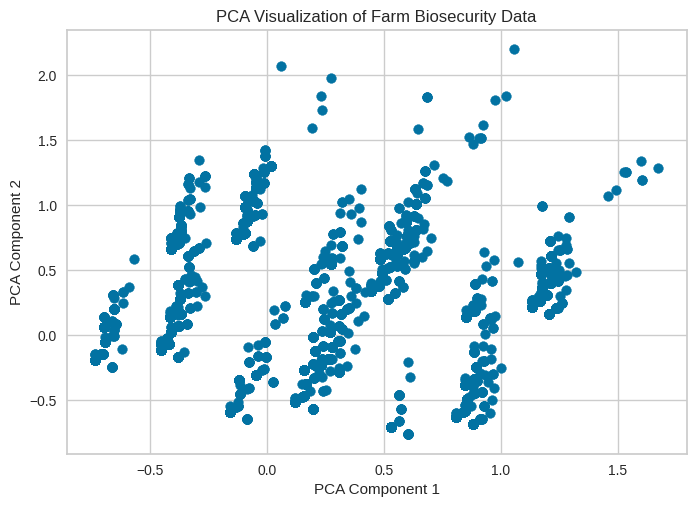

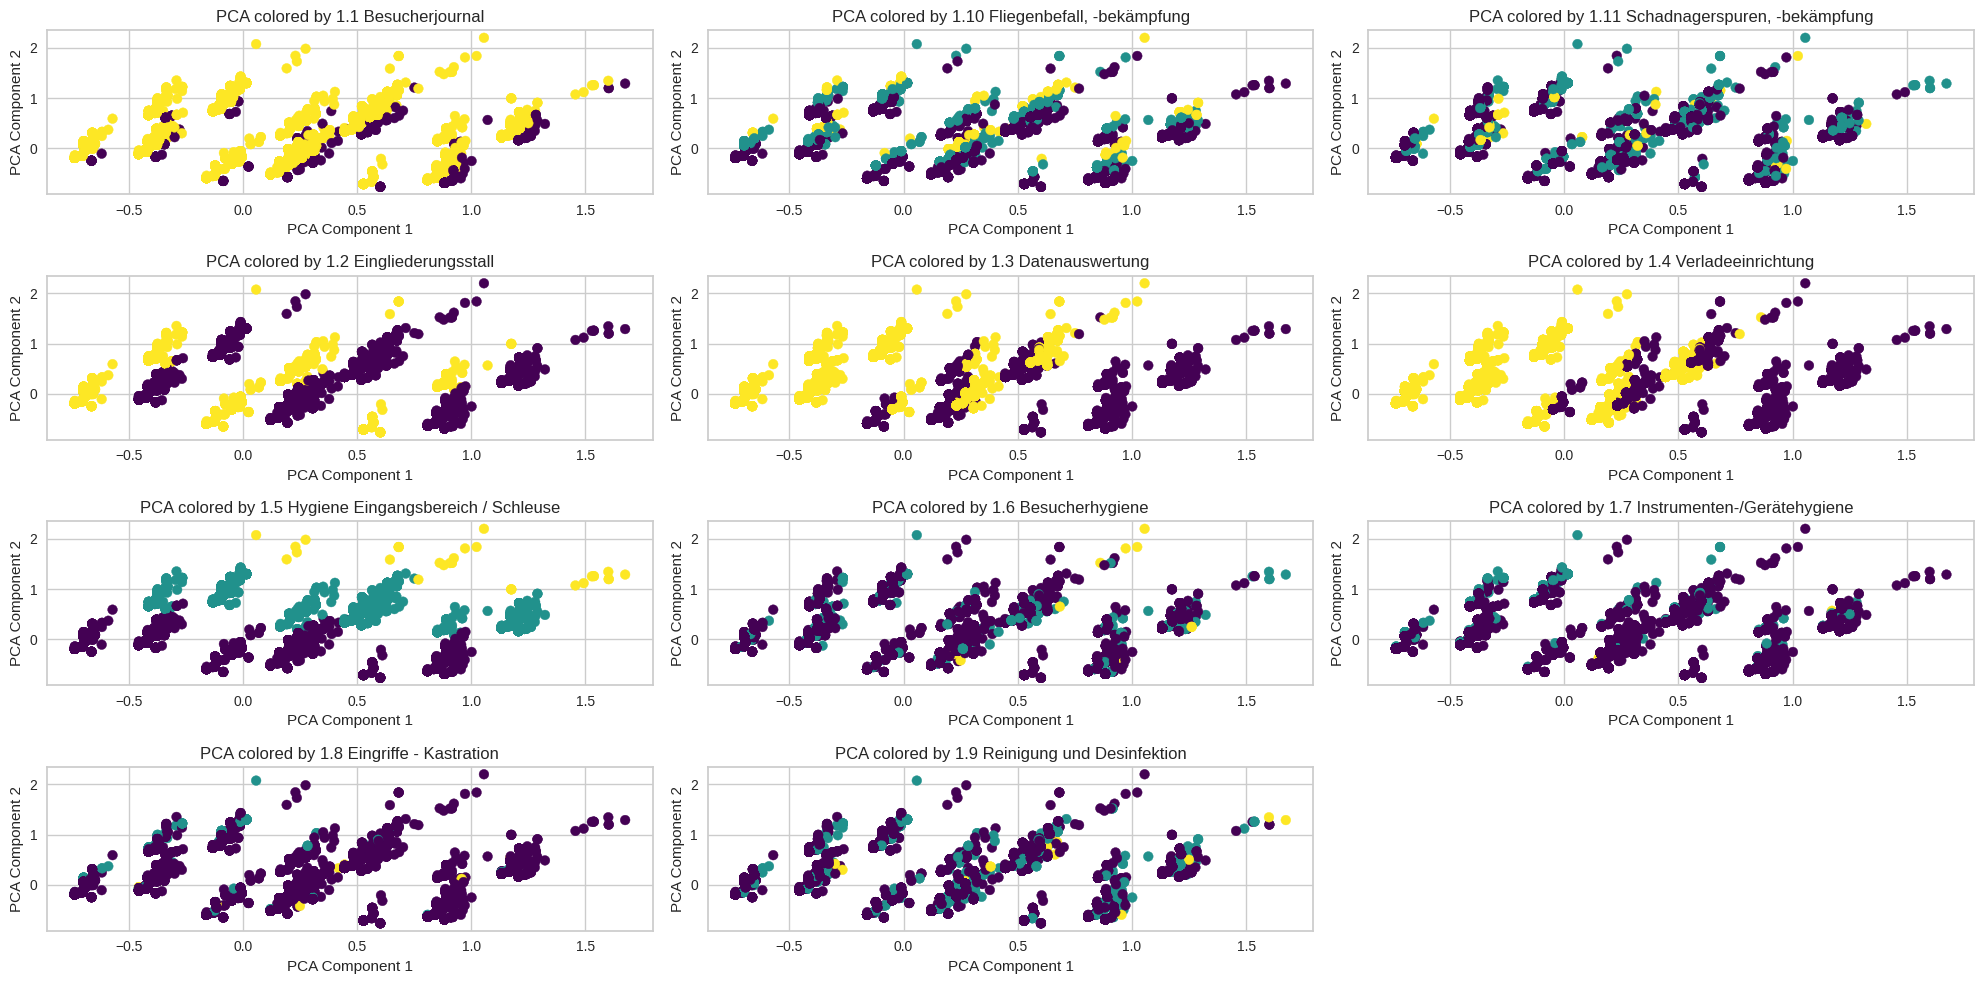

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Define the number of plots
num_plots = 11

# Get all column names except the first one
column_names = df[0:]

# Apply PCA to all features
pca = PCA(n_components=2)
pca_data = pca.fit_transform(df)

# Separate the data into two components
pca_features = pca_data[:, 0]
pca_targets = pca_data[:, 1]

# General PCA Plot
plt.scatter(pca_features, pca_targets)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Visualization of Farm Biosecurity Data')
plt.grid(True)
plt.show()

# Increase the figure width
plt.figure(figsize=(20, 10))

# Loop through each column name and create a scatter plot with color coding
for i, col_name in enumerate(column_names):
    plt.subplot(4, 3, i + 1)
    plt.scatter(pca_features, pca_targets, c=df[col_name], cmap='viridis')

    # Optional: Add labels and title for each plot
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title(f'PCA colored by {col_name}')

    plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances


def plot_tsne_with_kl_divergence(data, perplexity_values):
  """
  This function tests different perplexity values, calculates KL divergence,
  and plots the resulting t-SNE embeddings.

  Args:
      data: A pandas dataframe containing your high-dimensional data.
      perplexity_values: A list of integer values for perplexity to be tested.
  """
  # Select all features except the first one
  data_features = df

  for perplexity in perplexity_values:
    # t-SNE with current perplexity
    tsne = TSNE(n_components=2, perplexity=perplexity)
    tsne_data = tsne.fit_transform(data_features)

    # Separate the data into two components
    tsne_features = tsne_data[:, 0]
    tsne_targets = tsne_data[:, 1]

    # Calculate KL divergence using pairwise distances with a chosen metric
    original_distances = pairwise_distances(data_features, metric='euclidean')
    embedded_distances = pairwise_distances(tsne_data)
    kl_divergence = np.mean(original_distances.flatten() - embedded_distances.flatten())

    # Create a scatter plot
    plt.scatter(tsne_features, tsne_targets)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.title(f't-SNE Perplexity: {perplexity}, KL Divergence: {kl_divergence:.4f}')
    plt.grid(True)
    plt.show()


data = df
#choose perplexity values
perplexity_values = [5, 10, 20,40, 50,60,100]

plot_tsne_with_kl_divergence(data, perplexity_values)


###############################################################################################

Reduce dimentions and use k-means

Perplexity 8

In [ ]:
df

1.1 Besucherjournal  1.10 Fliegenbefall, -bekämpfung  \
0                        1                                0   
1                        1                                0   
2                        1                                0   
3                        1                                0   
4                        1                                0   
...                    ...                              ...   
20645                    1                                0   
20646                    1                                0   
20647                    0                                0   
20648                    1                                0   
20649                    1                                0   

       1.11 Schadnagerspuren, -bekämpfung  1.2 Eingliederungsstall  \
0                                       0                        0   
1                                       0                        0   
2                                       0                        0   
3                                       0                        1   
4                                       0                        1   
...                                   ...                      ...   
20645                                   0                        0   
20646                                   0                        0   
20647                                   0                        0   
20648                                   0                        1   
20649                                   0                        0   

       1.3 Datenauswertung  1.4 Verladeeinrichtung  \
0                        0                       0   
1                        0                       0   
2                        1                       1   
3                        1                       1   
4                        1                       1   
...                    ...                     ...   
20645                    0                       0   
20646                    1                       1   
20647                    0                       0   
20648                    1                       1   
20649                    0                       0   

       1.5 Hygiene Eingangsbereich / Schleuse  1.6 Besucherhygiene  \
0                                           1                    0   
1                                           1                    0   
2                                           0                    0   
3                                           0                    0   
4                                           0                    0   
...                                       ...                  ...   
20645                                       1                    0   
20646                                       0                    0   
20647                                       0                    0   
20648                                       0                    0   
20649                                       1                    0   

       1.7 Instrumenten-/Gerätehygiene  1.8 Eingriffe - Kastration  \
0                                    0                           0   
1                                    0                           0   
2                                    0                           0   
3                                    0                           0   
4                                    0                           0   
...                                ...                         ...   
20645                                0                           0   
20646                                0                           0   
20647                                0                           0   
20648                                0                           0   
20649                                0                           0   

       1.9 Reinigung und Desinfektion  
0                                   0 

In [ ]:
#df = df.drop('cluster', axis=1)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne_8 = TSNE(n_components=2, perplexity=8)
tsne_data_8 = tsne.fit_transform(df)

In [ ]:
from sklearn.manifold import TSNE

tsne_30 = TSNE(n_components=2, perplexity=30)
tsne_data_30 = tsne.fit_transform(df)

NameError: name 'tsne' is not defined

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Define a reasonable range of cluster numbers
clusters = range(1, 30)

# Initialize an empty list to store inertia values
inertia_values = []

# Calculate the inertia for different numbers of clusters
for k in clusters:
  kmeans = KMeans(n_clusters=k, random_state=42)
  kmeans.fit(tsne_data_8)
  inertia_values.append(kmeans.inertia_)

# Plot the inertia values for different cluster numbers
plt.figure(figsize=(10, 6))
plt.plot(clusters, inertia_values, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal k (K-Means)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.grid(True)

# Annotate the plot with the elbow point
plt.annotate('Elbow',
             xy=(5, inertia_values[15]),
             xytext=(80,80),
             textcoords='offset points',
             arrowprops=dict(arrowstyle='->', lw=1),
             fontsize=12,
             color='red'
             )

plt.show()


NameError: name 'tsne_data_8' is not defined

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Define a reasonable range of cluster numbers
clusters = range(1, 30)

# Initialize an empty list to store inertia values
inertia_values = []

# Calculate the inertia for different numbers of clusters
for k in clusters:
  kmeans = KMeans(n_clusters=k, random_state=42)
  kmeans.fit(tsne_data_30)
  inertia_values.append(kmeans.inertia_)

# Plot the inertia values for different cluster numbers
plt.figure(figsize=(10, 6))
plt.plot(clusters, inertia_values, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal k (K-Means)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.grid(True)

# Annotate the plot with the elbow point
plt.annotate('Elbow',
             xy=(5, inertia_values[15]),
             xytext=(80,80),
             textcoords='offset points',
             arrowprops=dict(arrowstyle='->', lw=1),
             fontsize=12,
             color='red'
             )

plt.show()

NameError: name 'tsne_data_30' is not defined

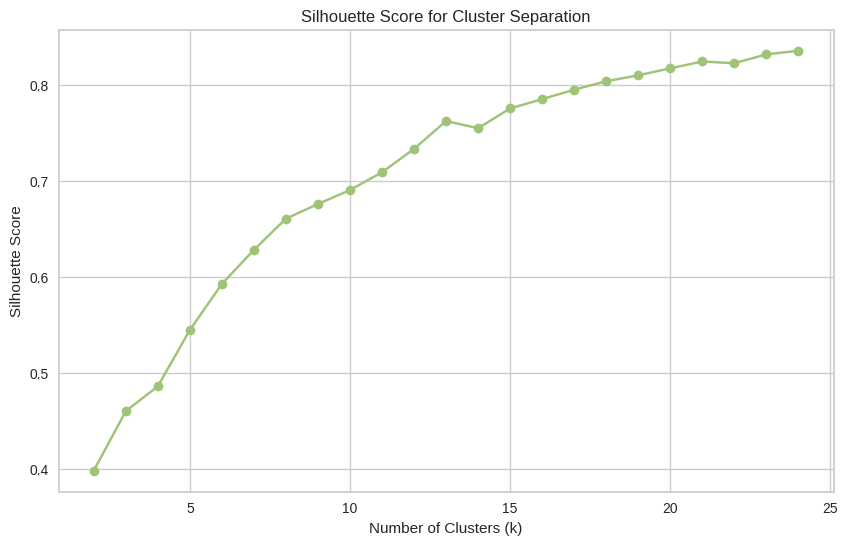

Chosen k based on silhouette score: 0.83560246


In [ ]:
from sklearn.metrics import silhouette_score

# Define a reasonable range of cluster numbers
clusters = range(2, 25)

# Initialize empty lists to store silhouette scores and chosen k
silhouette_scores = []
chosen_k = None

# Calculate silhouette score for different numbers of clusters
for k in clusters:
  kmeans = KMeans(n_clusters=k, random_state=42)
  kmeans.fit(tsne_data)
  silhouette_score_val = silhouette_score(tsne_data, kmeans.labels_)
  silhouette_scores.append(silhouette_score_val)

  # Optional: Choose k based on highest silhouette score
  if not chosen_k or silhouette_score_val > chosen_k:
    chosen_k = silhouette_score_val

# Plot the silhouette scores for different cluster numbers
plt.figure(figsize=(10, 6))
plt.plot(clusters, silhouette_scores, marker='o', linestyle='-', color='g')
plt.title('Silhouette Score for Cluster Separation')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# chosen_k for KMeans clustering
print("Chosen k based on silhouette score:", chosen_k)




#########################################################################################

Now we are going to perform clustering with different numbers of clusters and see how well they fit

In [ ]:
#df = df.drop('cluster_labels', axis=1)

KeyError: "['cluster_labels'] not found in axis"

In [ ]:
df

1.1 Besucherjournal  1.10 Fliegenbefall, -bekämpfung  \
0                        1                                0   
1                        1                                0   
2                        1                                0   
3                        1                                0   
4                        1                                0   
...                    ...                              ...   
20645                    1                                0   
20646                    1                                0   
20647                    0                                0   
20648                    1                                0   
20649                    1                                0   

       1.11 Schadnagerspuren, -bekämpfung  1.2 Eingliederungsstall  \
0                                       0                        0   
1                                       0                        0   
2                                       0                        0   
3                                       0                        1   
4                                       0                        1   
...                                   ...                      ...   
20645                                   0                        0   
20646                                   0                        0   
20647                                   0                        0   
20648                                   0                        1   
20649                                   0                        0   

       1.3 Datenauswertung  1.4 Verladeeinrichtung  \
0                        0                       0   
1                        0                       0   
2                        1                       1   
3                        1                       1   
4                        1                       1   
...                    ...                     ...   
20645                    0                       0   
20646                    1                       1   
20647                    0                       0   
20648                    1                       1   
20649                    0                       0   

       1.5 Hygiene Eingangsbereich / Schleuse  1.6 Besucherhygiene  \
0                                           1                    0   
1                                           1                    0   
2                                           0                    0   
3                                           0                    0   
4                                           0                    0   
...                                       ...                  ...   
20645                                       1                    0   
20646                                       0                    0   
20647                                       0                    0   
20648                                       0                    0   
20649                                       1                    0   

       1.7 Instrumenten-/Gerätehygiene  1.8 Eingriffe - Kastration  \
0                                    0                           0   
1                                    0                           0   
2                                    0                           0   
3                                    0                           0   
4                                    0                           0   
...                                ...                         ...   
20645                                0                           0   
20646                                0                           0   
20647                                0                           0   
20648                                0                           0   
20649                                0                           0   

       1.9 Reinigung und Desinfektion  
0                                   0 

In [ ]:
from sklearn.cluster import KMeans
# Define chosen k based on elbow method and/or silhouette score
chosen_k = 3

# Perform KMeans clustering with chosen k
kmeans = KMeans(n_clusters=chosen_k, random_state=42)
kmeans.fit(df)

# Assign cluster labels to each data point
cluster_labels_3 = kmeans.labels_

In [ ]:
unique_clusters = set(cluster_labels_3)
print(unique_clusters)

{0, 1, 2}


In [ ]:
from sklearn.cluster import KMeans

chosen_k = 10

# Perform KMeans clustering
kmeans = KMeans(n_clusters=chosen_k, random_state=42)
kmeans.fit(df)

# Assign cluster labels to each data point
cluster_labels_10 = kmeans.labels_

In [ ]:

chosen_k = 15

# Perform KMeans clustering
kmeans = KMeans(n_clusters=chosen_k, random_state=42)
kmeans.fit(df)

# Assign cluster labels to each data point
cluster_labels_15 = kmeans.labels_

In [ ]:
#create new df
df_3= df.copy()
df_10= df.copy()
df_15= df.copy()

In [ ]:
#convert the labels to the same type of variable
cluster_labels_3=cluster_labels_3.astype(np.int64)
cluster_labels_10=cluster_labels_10.astype(np.int64)
cluster_labels_15=cluster_labels_15.astype(np.int64)

In [ ]:
unique_clusters = np.unique(cluster_labels_3)
print(unique_clusters)

[0 1 2]


In [ ]:
# Add a new column named "cluster" to original dataframe (df)
df_3['cluster'] = cluster_labels_3.reshape(-1, 1)
df_10['cluster'] = cluster_labels_10.reshape(-1, 1)
df_15['cluster'] = cluster_labels_15.reshape(-1, 1)

In [ ]:
unique_values = df_3.iloc[:, -1].unique()
print(unique_values)

[1 0 2]


In [ ]:
unique_values = df_10.iloc[:, -1].unique()
print(unique_values)

[4 2 8 0 5 3 9 1 7 6]


In [ ]:
unique_values = df_15.iloc[:, -1].unique()
print(unique_values)

[13  0  8  1  3  5  6 11  4  2  9 10 12 14  7]


The next one can be removed because it is using the reduced data

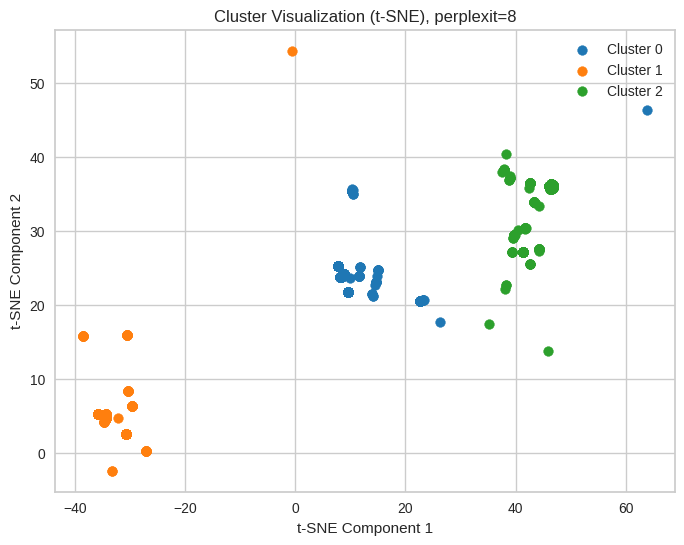

In [ ]:
import matplotlib.pyplot as plt

# Create a unique color map for the number of clusters
cmap = plt.cm.get_cmap('tab10')

# Create a scatter plot with colors based on cluster labels
plt.figure(figsize=(8, 6))
unique_clusters = np.unique(cluster_labels_3)
for cluster, color in zip(unique_clusters, cmap(unique_clusters)):
  cluster_data = tsne_data[cluster_labels == cluster]
  plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster}', c=color)

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Cluster Visualization (t-SNE), perplexit=8')
plt.legend()
plt.grid(True)
plt.show()


###########################

Visualize using t-SNE the labels

Test different numbers of clusters and different perplexity values

3 clusters; perplexity 8

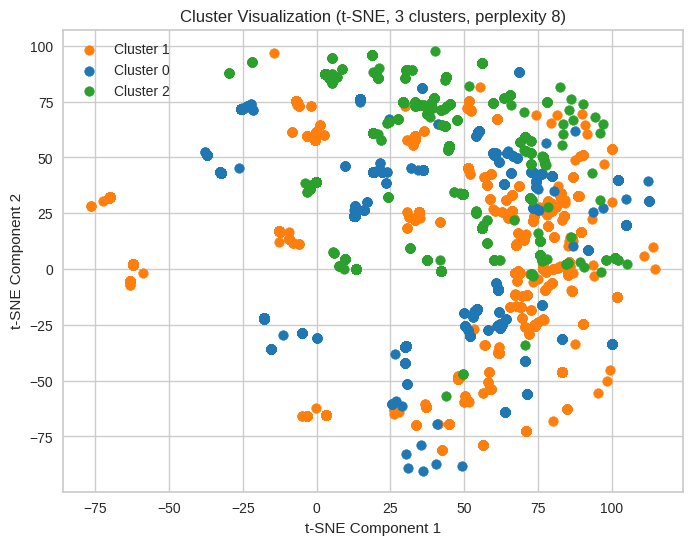

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Reduce data to 2 dimensions using t-SNE
tsne_model = TSNE(n_components=2, perplexity=8)
tsne_data_3 = tsne_model.fit_transform(df_3.iloc[:, :-1])

# Create a scatter plot with colors based on cluster labels
unique_clusters = df_3['cluster'].unique()
cmap = plt.cm.get_cmap('tab10')

plt.figure(figsize=(8, 6))
for cluster, color in zip(unique_clusters, cmap(unique_clusters)):
  cluster_data = tsne_data_3[df_3['cluster'] == cluster]
  plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster}', c=color)

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Cluster Visualization (t-SNE, 3 clusters, perplexity 8)')
plt.legend()
plt.grid(True)
plt.show()

3 clusters, perplexity 50

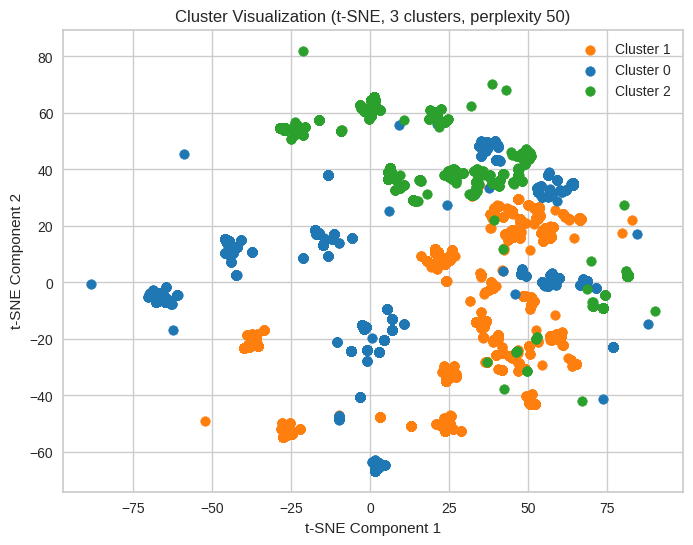

In [ ]:
# Reduce data to 2 dimensions using t-SNE
tsne_model = TSNE(n_components=2, perplexity=50)
tsne_data_3 = tsne_model.fit_transform(df_3.iloc[:, :-1])

# scatter plot with colors based on cluster labels
unique_clusters = df_3['cluster'].unique()
unique_clusters=unique_clusters.astype(np.int64)

cmap = plt.cm.get_cmap('tab10')

plt.figure(figsize=(8, 6))
for cluster, color in zip(unique_clusters, cmap(unique_clusters)):
  cluster_data = tsne_data_3[df_3['cluster'] == cluster]
  plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster}', c=color)

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Cluster Visualization (t-SNE, 3 clusters, perplexity 50)')
plt.legend()
plt.grid(True)
plt.show()

10 clusters, perplexity 8

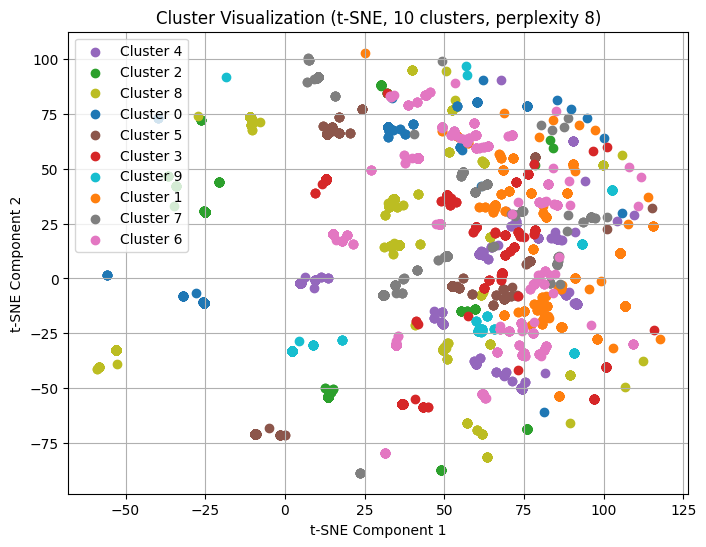

In [ ]:
# Reduce data to 2 dimensions using t-SNE
tsne_model = TSNE(n_components=2, perplexity=8)
tsne_data_10 = tsne_model.fit_transform(df_10.iloc[:, :-1])

#scatter plot with colors based on cluster labels
unique_clusters = df_10['cluster'].unique()
cmap = plt.cm.get_cmap('tab10')

plt.figure(figsize=(8, 6))
for cluster, color in zip(unique_clusters, cmap(unique_clusters)):
  cluster_data = tsne_data_10[df_10['cluster'] == cluster]
  plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster}', c=color)

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Cluster Visualization (t-SNE, 10 clusters, perplexity 8)')
plt.legend()
plt.grid(True)
plt.show()

10 clusters, perplexity 50

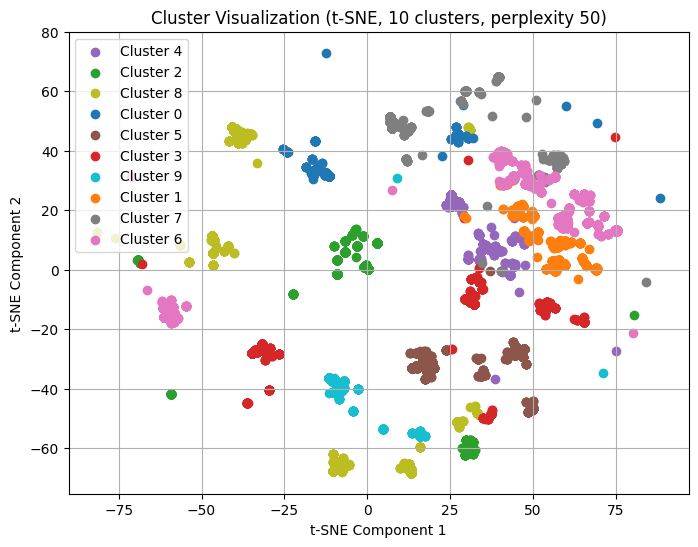

In [ ]:
# Reduce data to 2 dimensions using t-SNE
tsne_model = TSNE(n_components=2, perplexity=50)
tsne_data_10 = tsne_model.fit_transform(df_10.iloc[:, :-1])

#scatter plot with colors based on cluster labels
unique_clusters = df_10['cluster'].unique()
cmap = plt.cm.get_cmap('tab10')

plt.figure(figsize=(8, 6))
for cluster, color in zip(unique_clusters, cmap(unique_clusters)):
  cluster_data = tsne_data_10[df_10['cluster'] == cluster]
  plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster}', c=color)

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Cluster Visualization (t-SNE, 10 clusters, perplexity 50)')
plt.legend()
plt.grid(True)
plt.show()

15 clusters, perplexity 8

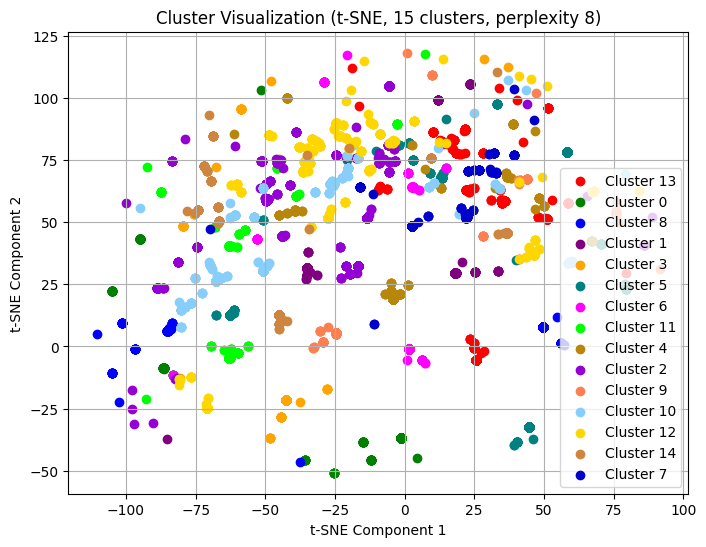

In [ ]:
# Reduce data to 2 dimensions using t-SNE
tsne_model = TSNE(n_components=2, perplexity=8)
tsne_data_15 = tsne_model.fit_transform(df_15.iloc[:, :-1])

# scatter plot with colors based on cluster labels
unique_clusters = df_15['cluster'].unique()
custom_colors = [
    'red', 'green', 'blue', 'purple', 'orange',
    'teal', 'fuchsia', 'lime', 'darkgoldenrod', 'darkviolet',
    'coral', 'lightskyblue', 'gold', 'peru', 'mediumblue'
]

plt.figure(figsize=(8, 6))
for cluster, color in zip(unique_clusters, custom_colors):
  cluster_data = tsne_data_15[df_15['cluster'] == cluster]
  plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster}', c=color)

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Cluster Visualization (t-SNE, 15 clusters, perplexity 8)')
plt.legend()
plt.grid(True)
plt.show()

15 clusters, perplexity 50

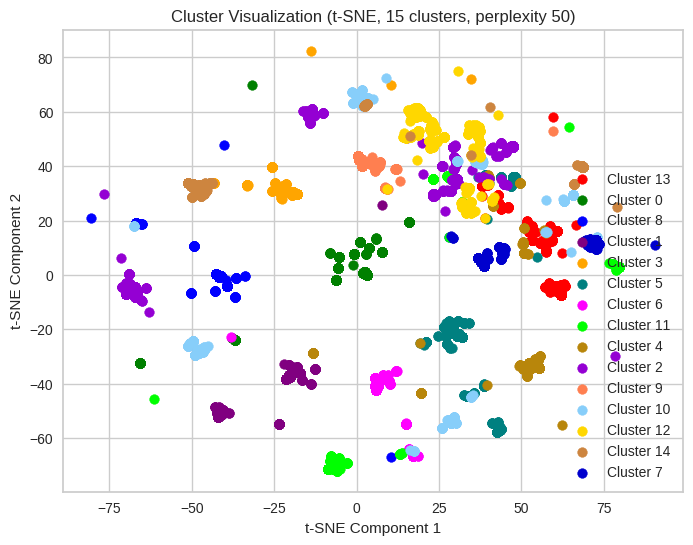

In [ ]:
# Reduce data to 2 dimensions using t-SNE
tsne_model = TSNE(n_components=2, perplexity=50)
tsne_data_15 = tsne_model.fit_transform(df_15.iloc[:, :-1])

# scatter plot with colors based on cluster labels
unique_clusters = df_15['cluster'].unique()
custom_colors = [
    'red', 'green', 'blue', 'purple', 'orange',
    'teal', 'fuchsia', 'lime', 'darkgoldenrod', 'darkviolet',
    'coral', 'lightskyblue', 'gold', 'peru', 'mediumblue'
]

plt.figure(figsize=(8, 6))
for cluster, color in zip(unique_clusters, custom_colors):
  cluster_data = tsne_data_15[df_15['cluster'] == cluster]
  plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster}', c=color)

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Cluster Visualization (t-SNE, 15 clusters, perplexity 50)')
plt.legend()
plt.grid(True)
plt.show()


################### with the reduced data

6 clusters, perplexity 8, reduced

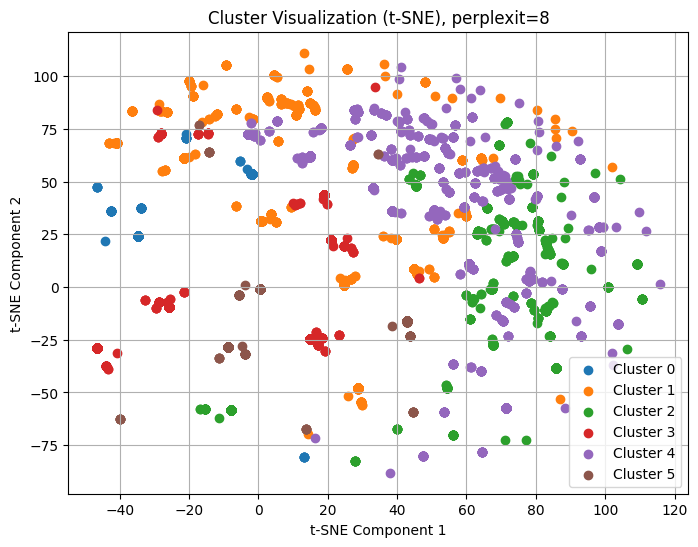

In [ ]:

chosen_k = 6

tsne_data_30
# Perform KMeans clustering
kmeans = KMeans(n_clusters=chosen_k, random_state=42)
kmeans.fit(tsne_data_8)

# Assign cluster labels to each data point
cluster_labels = kmeans.labels_

# Add a new column named "cluster" to dataframe
df['cluster'] = cluster_labels

import matplotlib.pyplot as plt

# Create a unique color map for the number of clusters
cmap = plt.cm.get_cmap('tab10')

# Create a scatter plot with colors based on cluster labels
plt.figure(figsize=(8, 6))
unique_clusters = np.unique(cluster_labels)
for cluster, color in zip(unique_clusters, cmap(unique_clusters)):
  cluster_data = tsne_data[cluster_labels == cluster]
  plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster}', c=color)

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Cluster Visualization (t-SNE), perplexit=8')
plt.legend()
plt.grid(True)
plt.show()

6 clusters, perplexity 30, reduced

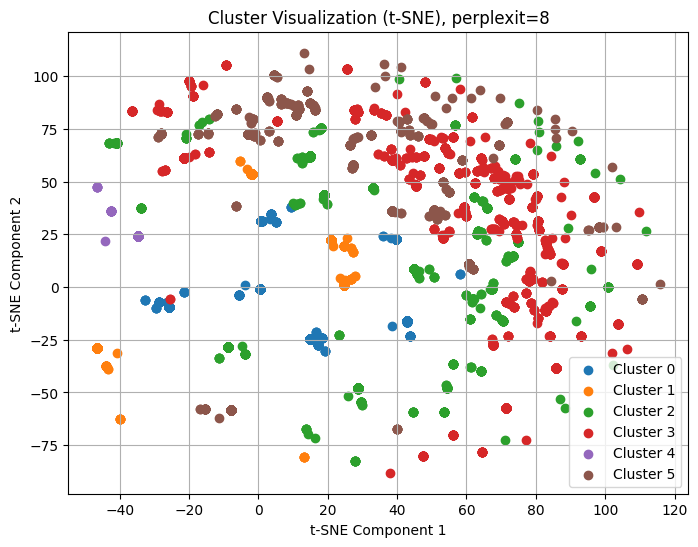

In [ ]:

chosen_k = 6

# Perform KMeans clustering with chosen k
kmeans = KMeans(n_clusters=chosen_k, random_state=42)
kmeans.fit(tsne_data_30)

# Assign cluster labels to each data point
cluster_labels = kmeans.labels_

# Add a new column named "cluster" to dataframe
df['cluster'] = cluster_labels

import matplotlib.pyplot as plt

# Create a unique color map for the number of clusters
cmap = plt.cm.get_cmap('tab10')

# Create a scatter plot with colors based on cluster labels
plt.figure(figsize=(8, 6))
unique_clusters = np.unique(cluster_labels)
for cluster, color in zip(unique_clusters, cmap(unique_clusters)):
  cluster_data = tsne_data[cluster_labels == cluster]
  plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster}', c=color)

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Cluster Visualization (t-SNE), perplexit=8')
plt.legend()
plt.grid(True)
plt.show()

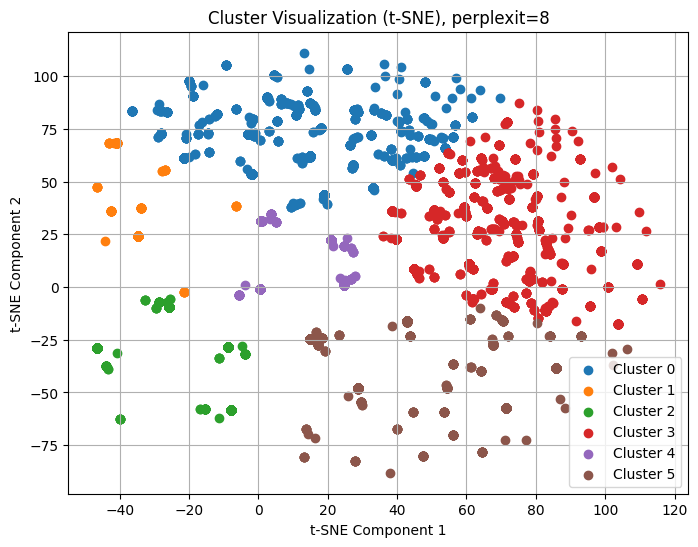

In [ ]:

chosen_k = 6

# Perform KMeans clustering with chosen k
kmeans = KMeans(n_clusters=chosen_k, random_state=42)
kmeans.fit(tsne_data)

# Assign cluster labels to each data point
cluster_labels = kmeans.labels_

# Add a new column named "cluster" to dataframe
df['cluster'] = cluster_labels

import matplotlib.pyplot as plt

# Create a unique color map for the number of clusters
cmap = plt.cm.get_cmap('tab10')

# Create a scatter plot with colors based on cluster labels
plt.figure(figsize=(8, 6))
unique_clusters = np.unique(cluster_labels)
for cluster, color in zip(unique_clusters, cmap(unique_clusters)):
  cluster_data = tsne_data[cluster_labels == cluster]
  plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster}', c=color)

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Cluster Visualization (t-SNE), perplexit=8')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

chosen_k = 6

# Perform KMeans clustering with chosen k
kmeans = KMeans(n_clusters=chosen_k, random_state=42)
kmeans.fit(df)

# Assign cluster labels to each data point
cluster_labels = kmeans.labels_

# Add a new column named "cluster" to dataframe
df['cluster'] = cluster_labels

# Reduce data to 2 dimensions using t-SNE
tsne_model = TSNE(n_components=2, random_state=42)
tsne_data = tsne_model.fit_transform(df.iloc[:, :-1])

import matplotlib.pyplot as plt

# Create a unique color map for the number of clusters
unique_clusters = df['cluster'].unique()
cmap = plt.cm.get_cmap('tab10')

# Create a scatter plot with colors based on cluster labels
plt.figure(figsize=(8, 6))
unique_clusters = np.unique(cluster_labels)
for cluster, color in zip(unique_clusters, cmap(unique_clusters)):
  cluster_data = tsne_data[df['cluster'] == cluster]
  plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster}', c=color)

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Cluster Visualization (t-SNE), perplexit=8')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Create a unique color map for the number of clusters
cmap = plt.cm.get_cmap('tab10')

# Create a scatter plot with colors based on cluster labels
plt.figure(figsize=(8, 6))
unique_clusters = np.unique(cluster_labels)
for cluster, color in zip(unique_clusters, cmap(unique_clusters)):
  cluster_data = tsne_data[cluster_labels == cluster]
  plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster}', c=color)

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Cluster Visualization (t-SNE), complexity=2')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Perform k-means clustering
kmeans = KMeans(n_clusters=6)
cluster_labels = kmeans.fit_predict(df)

# Assign labels based on clusters
labels = cluster_labels

# Apply LDA
lda = LinearDiscriminantAnalysis()
lda.fit(df, labels)

# Extract the explained variance ratio of each component
explained_variance_ratio = lda.explained_variance_ratio_

# Print the explained variance ratio of each component
print("Explained Variance Ratio of each Component:", explained_variance_ratio)


**PCA**

In [ ]:
#see the centroinds

# Define the numbers of clusters
num_clusters = 3

# Iterate over different numbers of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42, max_iter=50)
cluster_labels = kmeans.fit_predict(df)
silhouette_avg = silhouette_score(df, cluster_labels)
silhouette_scores.append(silhouette_avg)

centroids = kmeans.cluster_centers_
pd.DataFrame(centroids,columns=df.columns)

NameError: name 'silhouette_score' is not defined

**Lets try with 5 clusters - which do not seem to be too bad, with a silhouette score of almost 40**

---------------------------------------------------------------

In [ ]:
# Apply K-means clustering

#create a new dataset that will receive the labels
df_cluster=df.copy()

#define number of cluster
num_clusters = 3

#k means
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(df_cluster)

# Assign cluster labels to DataFrame
df_cluster['Cluster'] = cluster_labels

**To visualize the clusters, as we have 11 columns we will need to reduce the dimentionality for a easier visualization. We can apply PCA.**

-----------------------------------

In [ ]:
columns_list = df_cluster.columns.tolist()

# Print the list of columns
print(columns_list)

['1.1 Besucherjournal', '1.10 Fliegenbefall, -bekämpfung', '1.11 Schadnagerspuren, -bekämpfung', '1.2 Eingliederungsstall', '1.3 Datenauswertung', '1.4 Verladeeinrichtung', '1.5 Hygiene Eingangsbereich / Schleuse', '1.6 Besucherhygiene', '1.7 Instrumenten-/Gerätehygiene', '1.8 Eingriffe - Kastration', '1.9 Reinigung und Desinfektion', 'Cluster']


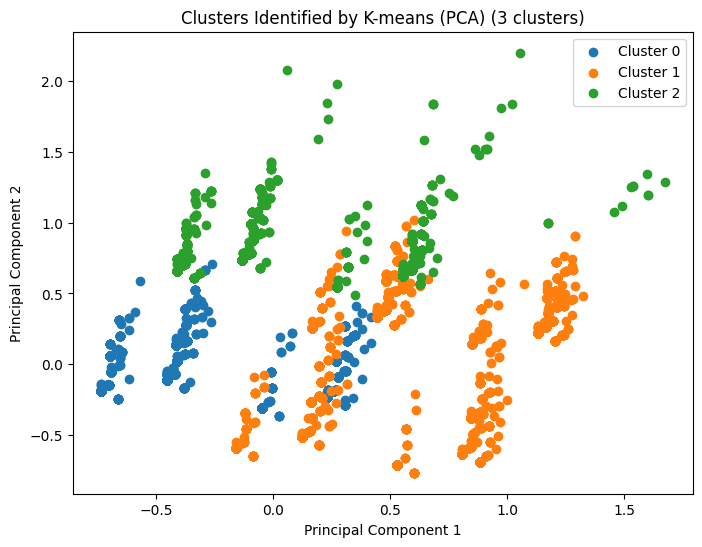

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Select the columns for clustering
cols = ['1.1 Besucherjournal', '1.10 Fliegenbefall, -bekämpfung', '1.11 Schadnagerspuren, -bekämpfung',
        '1.2 Eingliederungsstall', '1.3 Datenauswertung', '1.4 Verladeeinrichtung',
        '1.5 Hygiene Eingangsbereich / Schleuse', '1.6 Besucherhygiene',
        '1.7 Instrumenten-/Gerätehygiene', '1.8 Eingriffe - Kastration', '1.9 Reinigung und Desinfektion']

# Select the columns for clustering
X = df_cluster[cols]

# Apply PCA to reduce the dimensionality to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create a scatter plot of the clusters
plt.figure(figsize=(8, 6))

# Scatter plot for each cluster
for cluster_label in range(num_clusters):
    plt.scatter(X_pca[df_cluster['Cluster'] == cluster_label, 0],
                X_pca[df_cluster['Cluster'] == cluster_label, 1],
                label=f'Cluster {cluster_label}')

plt.title('Clusters Identified by K-means (PCA) (3 clusters)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


Calculate co-variance

6 clusters

In [ ]:

#create a new dataset that will receive the labels
df_cluster=df.copy()

#define number of cluster
num_clusters = 6

#k means
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(df_cluster)

# Assign cluster labels to DataFrame
df_cluster['Cluster'] = cluster_labels

In [ ]:
columns_list = df_cluster.columns.tolist()

# Print the list of columns
print(columns_list)

['1.1 Besucherjournal', '1.10 Fliegenbefall, -bekämpfung', '1.11 Schadnagerspuren, -bekämpfung', '1.2 Eingliederungsstall', '1.3 Datenauswertung', '1.4 Verladeeinrichtung', '1.5 Hygiene Eingangsbereich / Schleuse', '1.6 Besucherhygiene', '1.7 Instrumenten-/Gerätehygiene', '1.8 Eingriffe - Kastration', '1.9 Reinigung und Desinfektion', 'Cluster']


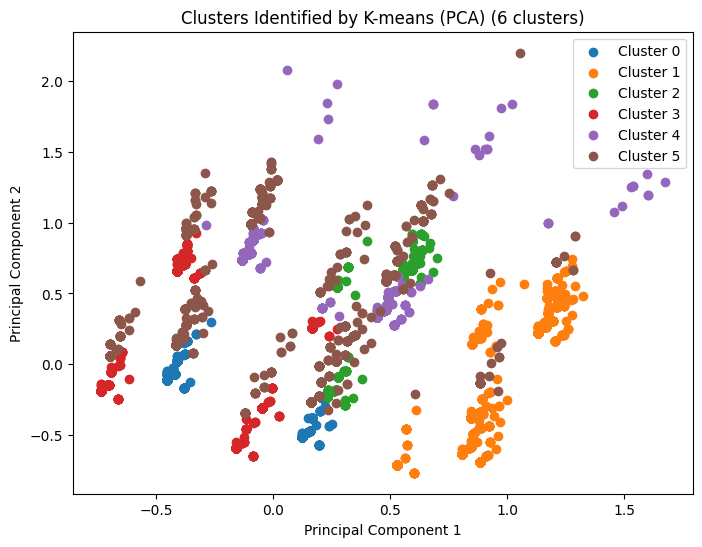

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Select the columns for clustering
cols = ['1.1 Besucherjournal', '1.10 Fliegenbefall, -bekämpfung', '1.11 Schadnagerspuren, -bekämpfung',
        '1.2 Eingliederungsstall', '1.3 Datenauswertung', '1.4 Verladeeinrichtung',
        '1.5 Hygiene Eingangsbereich / Schleuse', '1.6 Besucherhygiene',
        '1.7 Instrumenten-/Gerätehygiene', '1.8 Eingriffe - Kastration', '1.9 Reinigung und Desinfektion']

# Select the columns for clustering
X = df_cluster[cols]

# Apply PCA to reduce the dimensionality to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create a scatter plot of the clusters
plt.figure(figsize=(8, 6))

# Scatter plot for each cluster
for cluster_label in range(num_clusters):
    plt.scatter(X_pca[df_cluster['Cluster'] == cluster_label, 0],
                X_pca[df_cluster['Cluster'] == cluster_label, 1],
                label=f'Cluster {cluster_label}')

plt.title('Clusters Identified by K-means (PCA) (6 clusters)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


**Does not seem very good; let's try with 10**

-------------------------------------------------------------


In [ ]:
# Apply K-means clustering

#create a new dataset that will receive the labels
df_cluster=df.copy()

#define number of cluster
num_clusters = 10

#k means
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(df_cluster)

# Assign cluster labels to DataFrame
df_cluster['Cluster'] = cluster_labels

In [ ]:
columns_list = df_cluster.columns.tolist()

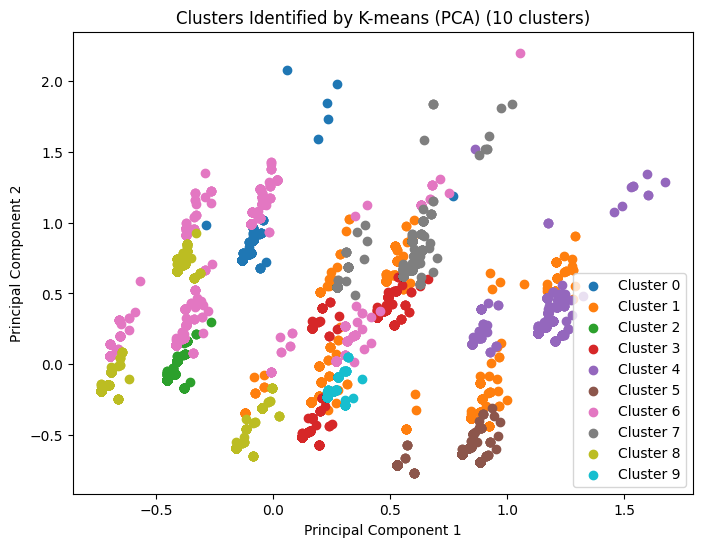

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Select the columns for clustering
cols = ['1.1 Besucherjournal', '1.10 Fliegenbefall, -bekämpfung', '1.11 Schadnagerspuren, -bekämpfung',
        '1.2 Eingliederungsstall', '1.3 Datenauswertung', '1.4 Verladeeinrichtung',
        '1.5 Hygiene Eingangsbereich / Schleuse', '1.6 Besucherhygiene',
        '1.7 Instrumenten-/Gerätehygiene', '1.8 Eingriffe - Kastration', '1.9 Reinigung und Desinfektion']

# Select the columns for clustering
X = df_cluster[cols]

# Apply PCA to reduce the dimensionality to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create a scatter plot of the clusters
plt.figure(figsize=(8, 6))

# Scatter plot for each cluster
for cluster_label in range(num_clusters):
    plt.scatter(X_pca[df_cluster['Cluster'] == cluster_label, 0],
                X_pca[df_cluster['Cluster'] == cluster_label, 1],
                label=f'Cluster {cluster_label}')

plt.title('Clusters Identified by K-means (PCA) (10 clusters)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

____________________________________________________________________________
**Let's try with 15**

In [ ]:
#create a new dataset that will receive the labels
df_cluster=df.copy()

#define number of cluster
num_clusters = 15

#k means
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(df_cluster)

# Assign cluster labels to DataFrame
df_cluster['Cluster'] = cluster_labels

In [ ]:
columns_list = df_cluster.columns.tolist()

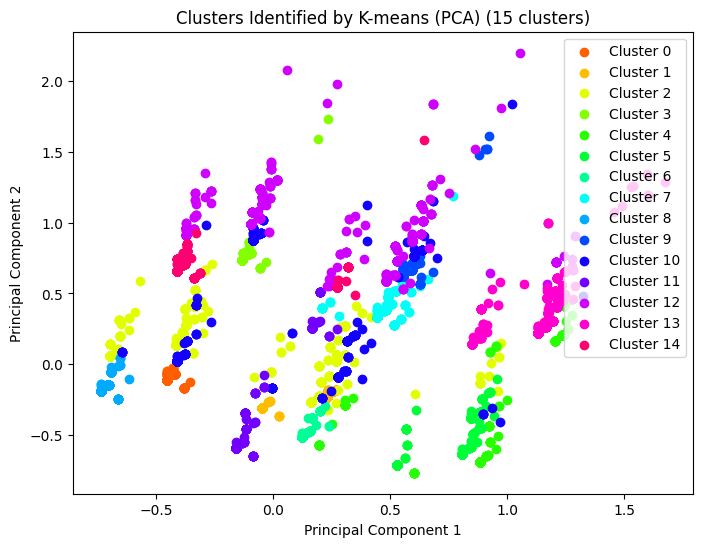

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Select the columns for clustering
cols = ['1.1 Besucherjournal', '1.10 Fliegenbefall, -bekämpfung', '1.11 Schadnagerspuren, -bekämpfung',
        '1.2 Eingliederungsstall', '1.3 Datenauswertung', '1.4 Verladeeinrichtung',
        '1.5 Hygiene Eingangsbereich / Schleuse', '1.6 Besucherhygiene',
        '1.7 Instrumenten-/Gerätehygiene', '1.8 Eingriffe - Kastration', '1.9 Reinigung und Desinfektion']

# Select the columns for clustering
X = df_cluster[cols]

# Apply PCA to reduce the dimensionality to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create a scatter plot of the clusters
plt.figure(figsize=(8, 6))

# Generate a color palette with 15 distinct colors
palette = sns.color_palette('hsv', num_clusters)

# Scatter plot for each cluster with distinct colors
for cluster_label in range(num_clusters):
    plt.scatter(
        X_pca[df_cluster['Cluster'] == cluster_label, 0],
        X_pca[df_cluster['Cluster'] == cluster_label, 1],
        label=f'Cluster {cluster_label}',
        color=palette[cluster_label]
    )

plt.title('Clusters Identified by K-means (PCA) (15 clusters)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

Could it be due to correlations? Lets check.

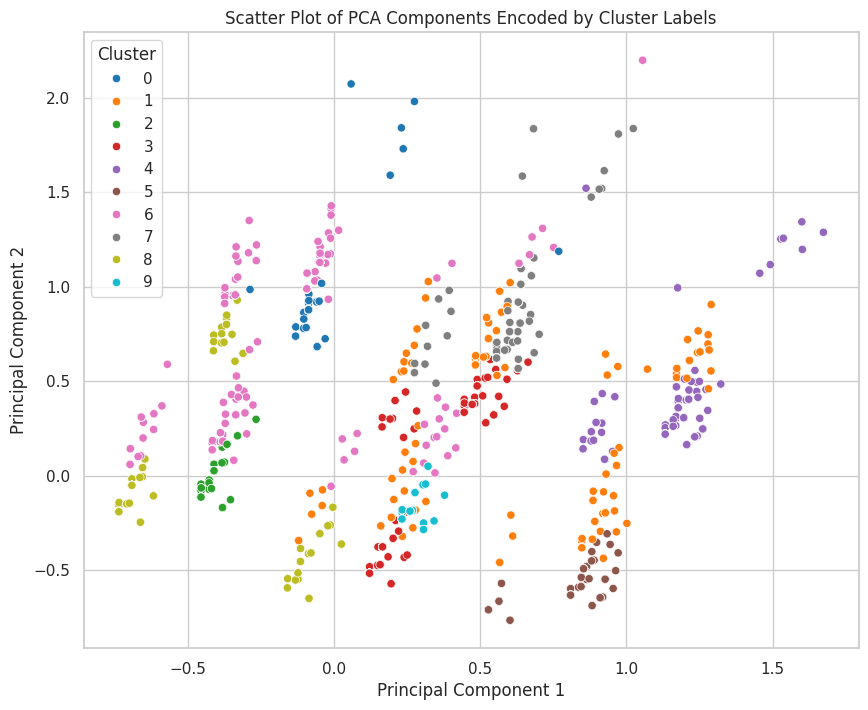

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of the plot
sns.set(style="whitegrid")

# Create the scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df_cluster['Cluster'], palette='tab10', legend='full')
plt.title('Scatter Plot of PCA Components Encoded by Cluster Labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

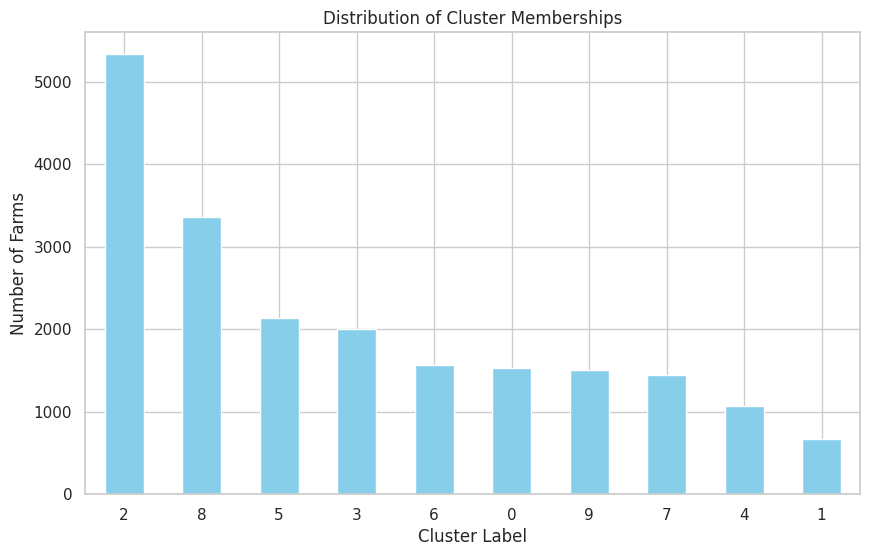

In [ ]:
import matplotlib.pyplot as plt

# Count the occurrences of each cluster label
cluster_counts = df_cluster['Cluster'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 6))
cluster_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Cluster Memberships')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Farms')
plt.xticks(rotation=0)
plt.show()


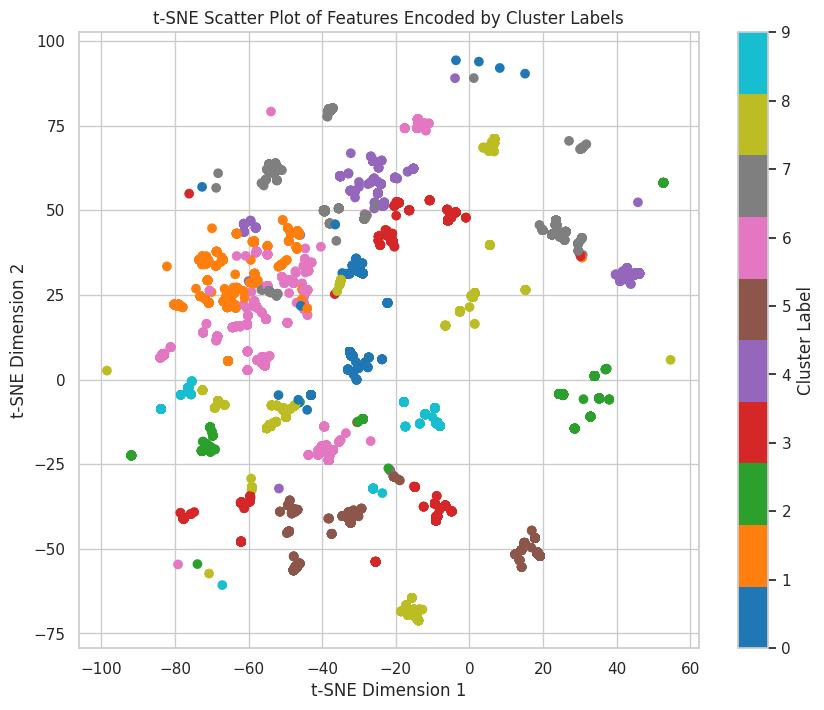

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Select all columns except the one containing the cluster labels
X = df_cluster.drop(columns=['Cluster'])

# Initialize t-SNE

tsne = TSNE(n_components=2, random_state=42)

# Fit and transform the data to reduce dimensions
X_tsne = tsne.fit_transform(X)

# Create a scatter plot of the reduced dimensions
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df_cluster['Cluster'], cmap='tab10')
plt.title('t-SNE Scatter Plot of Features Encoded by Cluster Labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(label='Cluster Label')
plt.show()



**Hierarchical clustering**

-------------------------------------------------------------



In [ ]:
df_c= df.copy()

In [ ]:
df = df = df.drop("Cluster", axis=1)

In [ ]:
df=df_c

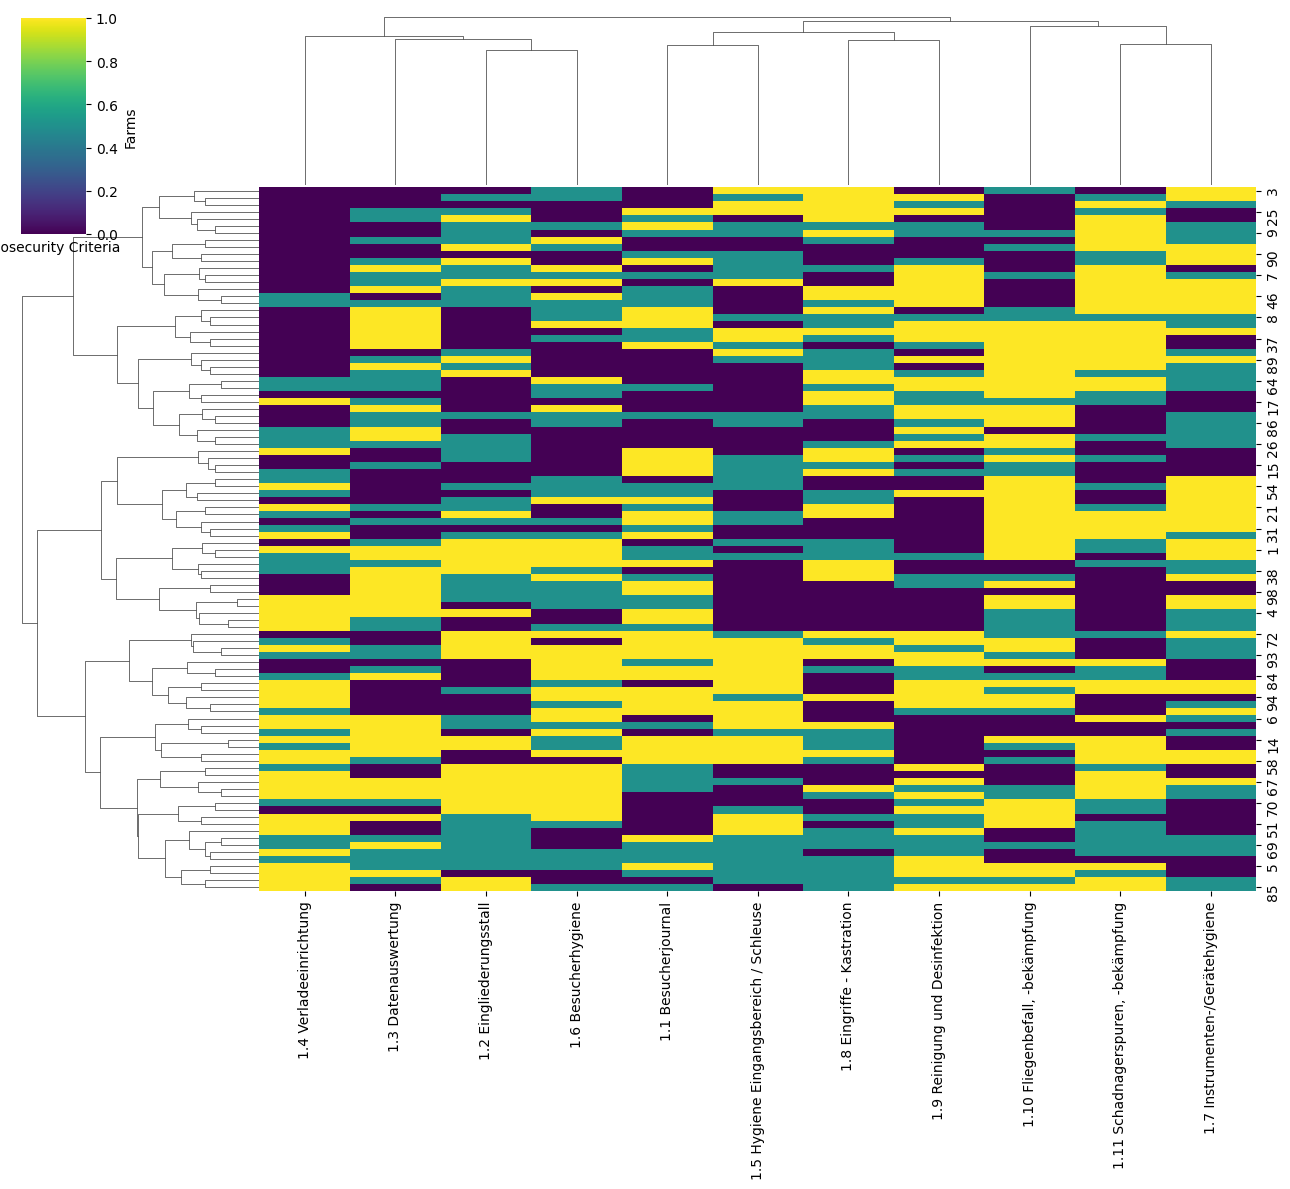

In [ ]:
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.setrecursionlimit(10000)

# Calculate the distance matrix
distance_matrix = pdist(df.values, metric='euclidean')

# Convert the distance matrix to a squareform distance matrix
distance_matrix_square = squareform(distance_matrix)

# Hierarchical clustering
n_clusters = 15
clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward').fit(df)

# Visualization
# Plot a dendrogram
sns.clustermap(df, method='ward', cmap='viridis', figsize=(13, 12), standard_scale=4)
plt.xlabel('Biosecurity Criteria')
plt.ylabel('Farms')
plt.show()

# Assign cluster labels to each farm
df['Cluster'] = clustering.labels_


In [ ]:
df = df = df.drop("Cluster", axis=1)

1.1 Besucherjournal  1.10 Fliegenbefall, -bekämpfung  \
0                        1                                0   
1                        1                                0   
2                        1                                0   
3                        1                                0   
4                        1                                0   
...                    ...                              ...   
20645                    1                                0   
20646                    1                                0   
20647                    0                                0   
20648                    1                                0   
20649                    1                                0   

       1.11 Schadnagerspuren, -bekämpfung  1.2 Eingliederungsstall  \
0                                       0                        0   
1                                       0                        0   
2                                       0                        0   
3                                       0                        1   
4                                       0                        1   
...                                   ...                      ...   
20645                                   0                        0   
20646                                   0                        0   
20647                                   0                        0   
20648                                   0                        1   
20649                                   0                        0   

       1.3 Datenauswertung  1.4 Verladeeinrichtung  \
0                        0                       0   
1                        0                       0   
2                        1                       1   
3                        1                       1   
4                        1                       1   
...                    ...                     ...   
20645                    0                       0   
20646                    1                       1   
20647                    0                       0   
20648                    1                       1   
20649                    0                       0   

       1.5 Hygiene Eingangsbereich / Schleuse  1.6 Besucherhygiene  \
0                                           1                    0   
1                                           1                    0   
2                                           0                    0   
3                                           0                    0   
4                                           0                    0   
...                                       ...                  ...   
20645                                       1                    0   
20646                                       0                    0   
20647                                       0                    0   
20648                                       0                    0   
20649                                       1                    0   

       1.7 Instrumenten-/Gerätehygiene  1.8 Eingriffe - Kastration  \
0                                    0                           0   
1                                    0                           0   
2                                    0                           0   
3                                    0                           0   
4                                    0                           0   
...                                ...                         ...   
20645                                0                           0   
20646                                0                           0   
20647                                0                           0   
20648                                0                           0   
20649                                0                           0   

       1.9 Reinigung und Desinfektion  
0                                   0 

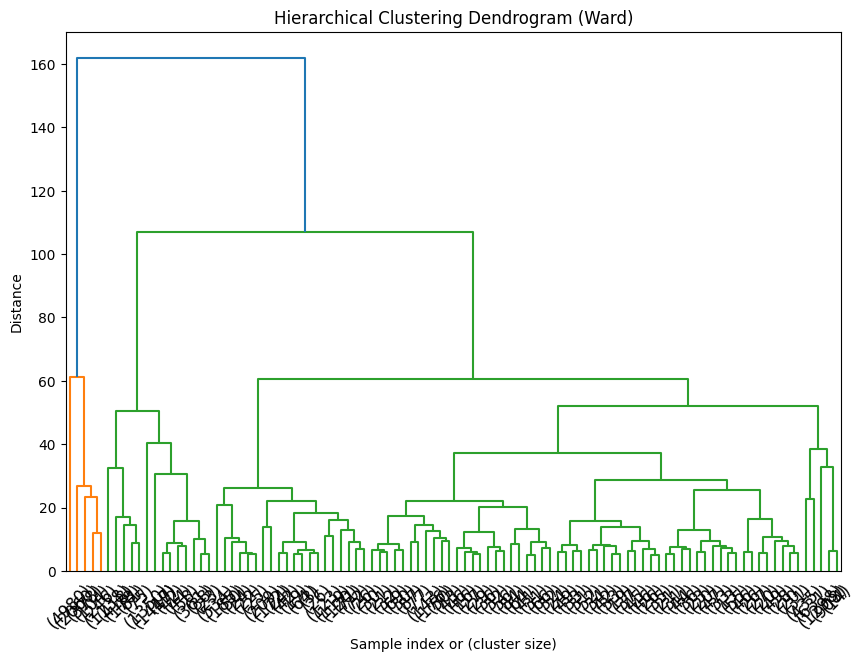

In [ ]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster

# Compute the distance matrix
# Using Euclidean distance
ward = linkage(df, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(ward, truncate_mode='lastp', p=100, leaf_rotation=90., leaf_font_size=12.)
plt.title('Hierarchical Clustering Dendrogram (Ward)')
plt.xlabel('Sample index or (cluster size)')
plt.ylabel('Distance')
plt.show()




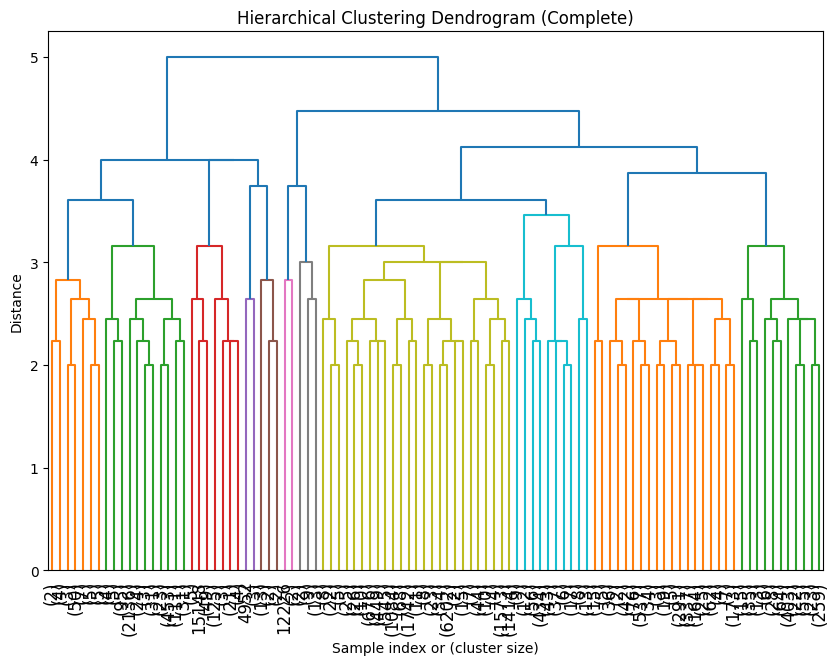

In [ ]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster

# Compute the distance matrix
# Using Euclidean distance
complete = linkage(df,method='complete', metric='euclidean')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(complete, truncate_mode='lastp', p=100, leaf_rotation=90., leaf_font_size=12.)
plt.title('Hierarchical Clustering Dendrogram (Complete)')
plt.xlabel('Sample index or (cluster size)')
plt.ylabel('Distance')
plt.show()

In [ ]:
from scipy.cluster.hierarchy import linkage, fcluster

# Define the desired number of clusters
k = 3

# Assign data points to clusters based on the linkage and k
cluster_labels = fcluster(ward, k, criterion='maxclust')

In [ ]:
df['Cluster'] = cluster_labels

In [ ]:
unique_clusters = df['Cluster'].unique()
unique_clusters

array([3, 1, 2], dtype=int32)

In [ ]:
from sklearn.decomposition import PCA

# Exclude the cluster label column
data_for_pca = df.iloc[:, :11]

# Perform PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data_for_pca)

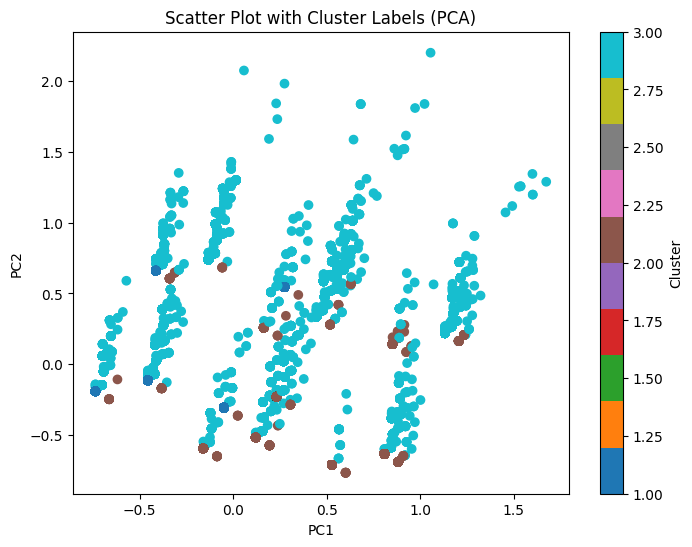

In [ ]:
import matplotlib.pyplot as plt

# Use a colormap
cmap = 'tab10'

# Scatter plot with clear separation
plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=df['Cluster'], cmap=cmap)

# Add labels and title
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Scatter Plot with Cluster Labels (PCA)')
plt.colorbar(label='Cluster')
plt.show()

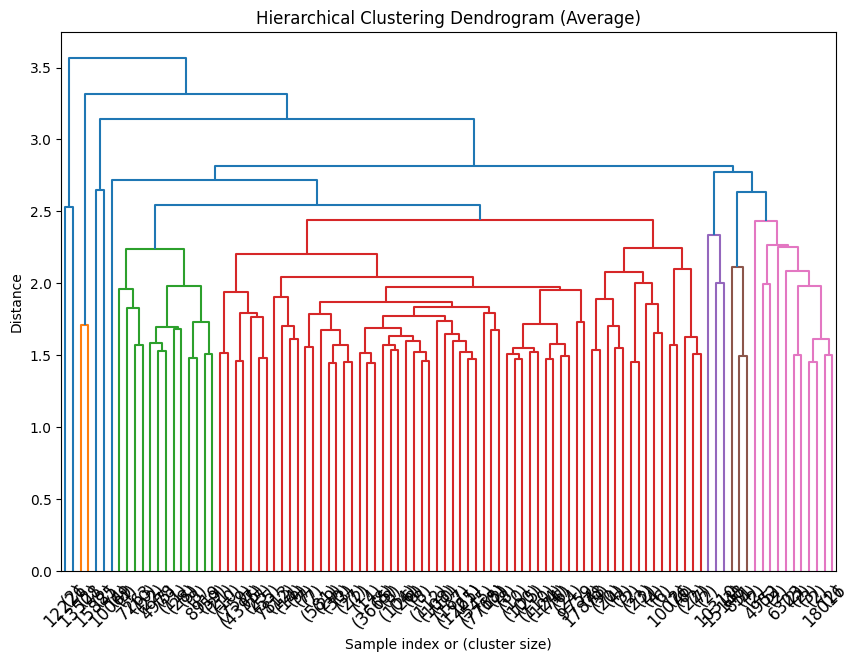

In [ ]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster

# Compute the distance matrix
# Using Euclidean distance
average = linkage(df, method='average', metric='euclidean')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(average, truncate_mode='lastp', p=100, leaf_rotation=45., leaf_font_size=12.)
plt.title('Hierarchical Clustering Dendrogram (Average)')
plt.xlabel('Sample index or (cluster size)')
plt.ylabel('Distance')
plt.show()

In [ ]:
#calculate number of clusters for the ward method
from scipy.cluster.hierarchy import fcluster

fw = fcluster(ward, 5, criterion='maxclust')

#print(f"Clusters: {f1}")
number_of_clusters = len(set(fw))
print(f"Total number of clusters: {number_of_clusters}")

Total number of clusters: 5


In [ ]:
#calculate number of clusters for the complete
from scipy.cluster.hierarchy import fcluster

fc = fcluster(complete, 2, criterion='maxclust')

number_of_clusters = len(set(fc))
print(f"Total number of clusters: {number_of_clusters}")

Total number of clusters: 2


In [ ]:
#calculate number of clusters for the average
from scipy.cluster.hierarchy import fcluster

fa = fcluster(average, 2, criterion='maxclust')

number_of_clusters = len(set(fa))
print(f"Total number of clusters: {number_of_clusters}")

Total number of clusters: 2


In [ ]:
# Determine the number of clusters
# Let's use a threshold to cut the dendrogram
max_d = 100
clusters = fcluster(Z, max_d, criterion='distance')

# Alternatively, specify the number of clusters directly
k = 5
clusters_k = fcluster(Z, k, criterion='maxclust')

# Add the cluster labels to the DataFrame
df['cluster'] = clusters

# Display the resulting clusters
print(df['cluster'].value_counts())

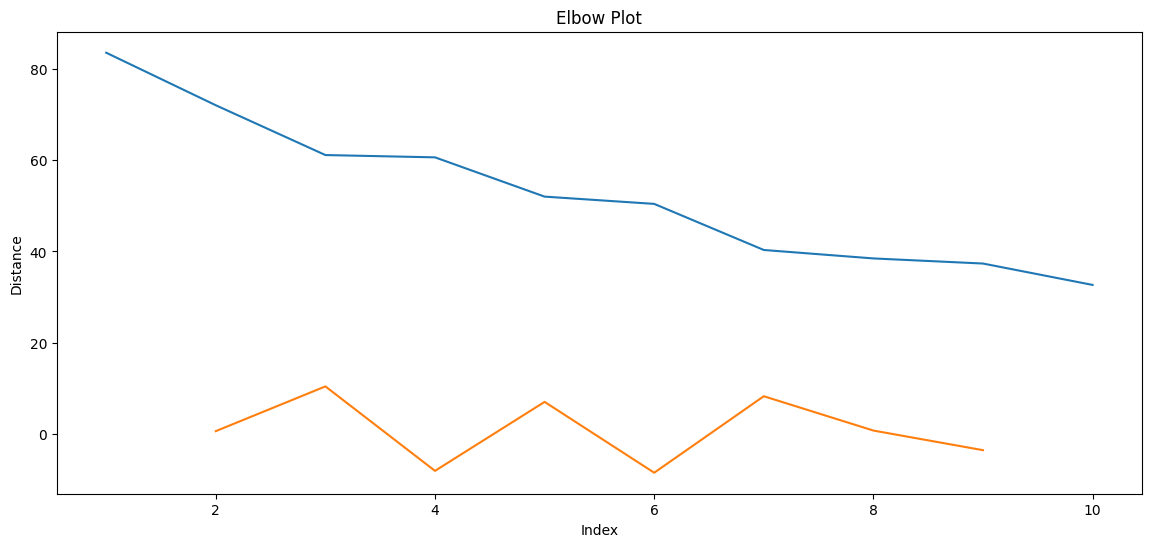

Suggested number of clusters: 3


In [ ]:
#using elbow plot to find the number of
from scipy.cluster.hierarchy import linkage
import matplotlib.pyplot as plt

# Plot the elbow
last = Z[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.title('Elbow Plot')
plt.xlabel('Index')
plt.ylabel('Distance')
plt.show()

k = acceleration_rev.argmax() + 2
print("Suggested number of clusters:", k)


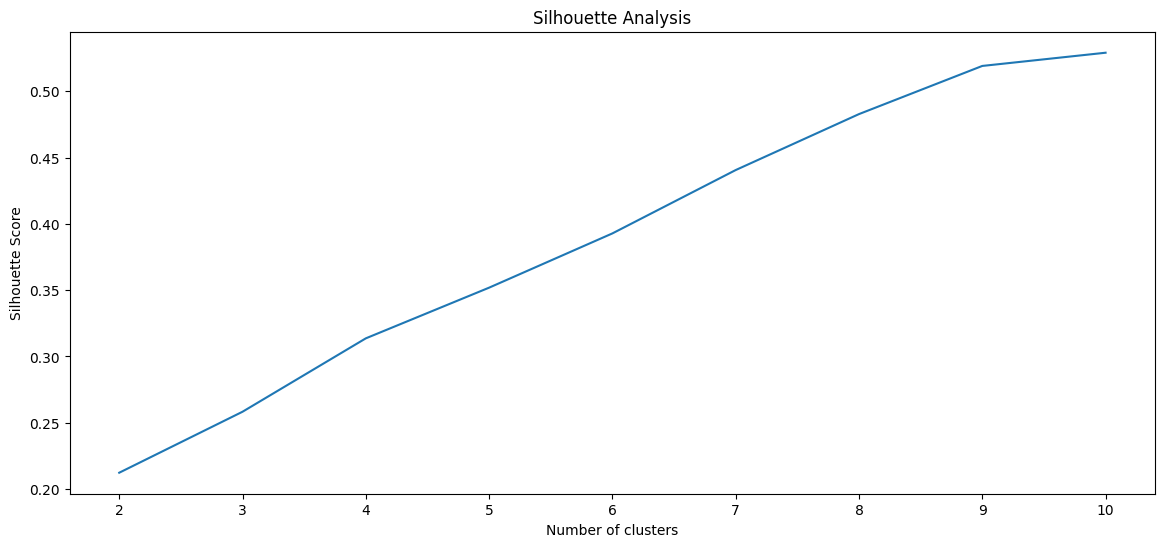

Best number of clusters by silhouette score: 10


In [ ]:
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import fcluster

# Test silhouette score for different number of clusters
range_n_clusters = list(range(2, 11))
silhouette_avg = []

for num_clusters in range_n_clusters:
    cluster_labels = fcluster(Z, num_clusters, criterion='maxclust')
    silhouette_avg.append(silhouette_score(df, cluster_labels))

plt.plot(range_n_clusters, silhouette_avg)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()

best_num_clusters = range_n_clusters[silhouette_avg.index(max(silhouette_avg))]
print("Best number of clusters by silhouette score:", best_num_clusters)


In [ ]:
df= df_c

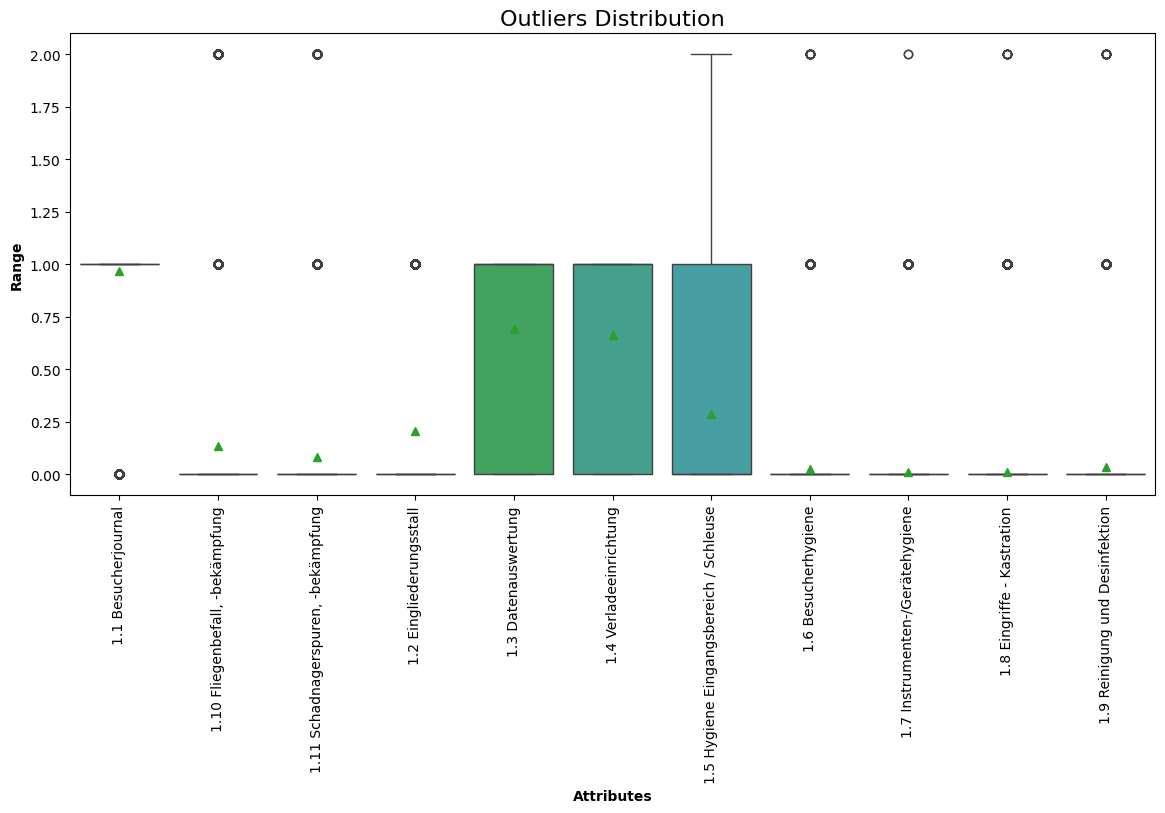

In [ ]:
def show_boxplot(df):
  plt.rcParams['figure.figsize'] = [14, 6]
  sns.boxplot(
      data=df,
      orient="v",
      showmeans=True
  )
  plt.xticks(rotation=90)
  plt.title("Outliers Distribution", fontsize=16)
  plt.ylabel("Range", fontweight='bold')
  plt.xlabel("Attributes", fontweight='bold')

show_boxplot(df)

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram

complete_clustering = linkage(df, method="complete", metric="euclidean")
average_clustering = linkage(df, method="average", metric="euclidean")
single_clustering = linkage(df, method="single", metric="euclidean")

In [ ]:
pip install gower

In [ ]:
df=df_c

In [ ]:
df = df.astype(float)

In [ ]:
import gower

# Compute Gower distance matrix
distance_matrix = gower.gower_matrix(df)

In [ ]:
from sklearn.metrics import pairwise_distances

# Define a function to compute Gower distance in chunks
def gower_distance(X):
    """
    Compute the Gower distance matrix in a memory-efficient way.
    """
    n_samples, n_features = X.shape
    D = np.zeros((n_samples, n_samples))

    for i in range(n_samples):
        for j in range(i + 1, n_samples):
            sum_num = 0.0
            sum_den = 0.0
            for k in range(n_features):
                range_k = np.max(X[:, k]) - np.min(X[:, k])
                if range_k != 0:
                    sum_num += np.abs(X[i, k] - X[j, k]) / range_k
                sum_den += 1
            D[i, j] = sum_num / sum_den
            D[j, i] = D[i, j]

    return D

# Compute Gower distance matrix
distance_matrix = gower_distance(df.values)


In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# hierarchical clustering using the computed distance matrix
Z = linkage(distance_matrix, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram (Gower Distance)')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
import gower

# Compute Gower distance matrix
distance_matrix = gower.gower_matrix(df)

# hierarchical clustering using AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0, affinity='precomputed', linkage='ward')
clustering.fit(distance_matrix)

# Create linkage matrix for dendrogram
counts = np.zeros(clustering.children_.shape[0])
n_samples = len(clustering.labels_)
for i, merge in enumerate(clustering.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([clustering.children_, clustering.distances_, counts]).astype(float)

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram (AgglomerativeClustering)')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()


In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Perform hierarchical clustering using the computed distance matrix
Z = linkage(distance_matrix, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram (Gower Distance)')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

In [ ]:
rom scipy.cluster.hierarchy import fcluster

# Determine the optimal number of clusters by cutting the dendrogram
max_d = 1.0
clusters = fcluster(Z, max_d, criterion='distance')

# Plot dendrogram with threshold
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.axhline(y=max_d, color='r', linestyle='--')
plt.title('Hierarchical Clustering Dendrogram with Cutoff Line')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

# Print the number of clusters
num_clusters = len(np.unique(clusters))
print(f'Number of clusters: {num_clusters}')

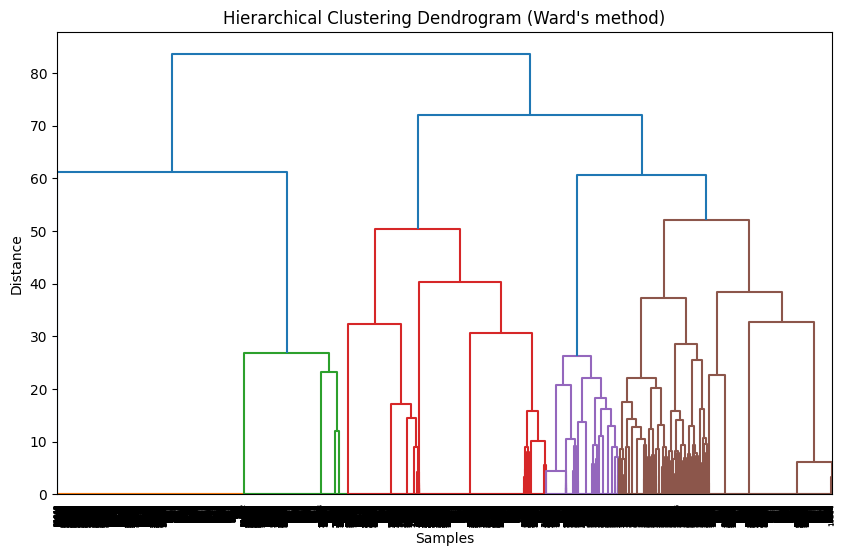

In [ ]:
plt.figure(figsize=(10, 6))
dendrogram(ward_linkage)
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.title("Hierarchical Clustering Dendrogram (Ward's method)")
plt.show()


In [ ]:
df_c= df.copy()

In [ ]:
df_c['FarmID'] = np.arange(1, len(df_c) + 1)

In [ ]:
pip install --upgrade scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 18.9 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.4
    Uninstalling scipy-1.11.4:
      Successfully uninstalled scipy-1.11.4


In [ ]:
import pandas as pd
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
%matplotlib inline

names = df['FarmID']

# Select only the biosecurity criteria columns
X = df.iloc[:, :11]

# Perform hierarchical clustering with Ward's method
Z = hierarchy.linkage(X, method='ward')

# Generate and plot the dendrogram
plt.figure(figsize=(10, 25))

dn = dendrogram(Z, labels=names, orientation='right')

# Save the dendrogram as an image
plt.savefig("biosecurity_clusters.svg", format="svg")

# Explore the dendrogram to identify clusters
plt.show()



KeyError: -4

<Figure size 1000x2500 with 0 Axes>

In [ ]:
print(Z < 0)

[[False False False False]
 [False False False False]
 [False False False False]
 ...
 [False False False False]
 [False False False False]
 [False False False False]]


In [ ]:
print(X.values[X.values < 0])

[]


In [ ]:
#Hierarchical clustering Single Link (MIN)plt.show()

from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
%matplotlib inline

# Create a new column 'FarmID' with values from 1 to the number of rows
df['FarmID'] = np.arange(1, len(df_c) + 1)

names = df['FarmID']
X = df.drop(['FarmID'],axis=1)
Z = hierarchy.linkage(X.values, method='single')
dn = hierarchy.dendrogram(Z,labels=names.tolist(),orientation='right')

plt.show()

In [ ]:
df = df.drop('FarmID', axis=1)  # Specify axis=1 for columns

In [ ]:
df_c= df.copy()